In [1219]:
# Data Management/Investigation
import wbdata
import pandas as pd
import numpy as np
import country_converter as coco
import missingno as miss
import datetime
from pandas.api.types import CategoricalDtype # Ordering categories

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

In [335]:
# Configure display so that all columns will be visible
pd.set_option('display.max_columns', None)

# Read in Data: GTD

In [2]:
gtd = pd.read_excel("Data/00 Global Terrorism Database/globalterrorismdb_0919dist.xlsx")

In [4]:
gtd1993 = pd.read_excel("Data/00 Global Terrorism Database/gtd1993_0919dist.xlsx")

In [1119]:
# Check if the column names match
list(gtd.columns)==list(gtd1993.columns)

True

In [1120]:
# Consolidate
gtdfinal = gtd.append(gtd1993)

In [2238]:
# Add column for civilian casualties
# NAN will be those with missing data in either total or terrorist casualties
gtdfinal["nkillciv"] = gtdfinal["nkill"]-gtdfinal["nkillter"]
# Add column for civilian injuries
gtdfinal["nwoundciv"] = gtdfinal["nwound"]-gtdfinal["nwoundte"]
gtdfinal["nwoundciv"] = gtdfinal["nwoundciv"].clip(lower=0)

In [2239]:
#Set unknown to NAN
gtdfinal["nperps"]=gtdfinal["nperps"].replace(-99,np.nan)
gtdfinal["nperps"]=gtdfinal["nperps"].replace(-9,np.nan)
gtdfinal["nperpcap"]=gtdfinal["nperpcap"].replace(-99,np.nan)
gtdfinal["nperpcap"]=gtdfinal["nperpcap"].replace(-9,np.nan)
gtdfinal["ishostkid"]=gtdfinal["ishostkid"].replace(-9,np.nan)
gtdfinal["nhostkid"]=gtdfinal["nhostkid"].replace(-99,np.nan)
gtdfinal["ransom"]=gtdfinal["ransom"].replace(-9,np.nan)
gtdfinal["ransompaid"]=gtdfinal["ransom"].replace(-99,np.nan)
gtdfinal["ransompaid"]=gtdfinal["ransom"].replace(-9,np.nan)
gtdfinal["INT_LOG"]=gtdfinal["INT_LOG"].replace(-9,np.nan)
gtdfinal["claimed"]=gtdfinal["claimed"].replace(-9,np.nan)

In [ ]:
print(sum(np.isnan(gtdfinal["nkillciv"])))
print(sum(~np.isnan(gtdfinal["nkillciv"])))

In [ ]:
print(sum(np.isnan(gtdfinal["nwoundciv"])))
print(sum(~np.isnan(gtdfinal["nwoundciv"])))

In [ ]:
# Take number of monthly incidents per country-year
gtd_yr = pd.crosstab([gtdfinal.iyear,gtdfinal.country_txt],[gtdfinal.imonth])

In [ ]:
# There are columns where month = 0. This is okay. Minimal error.

gtd_month0 = gtdfinal[gtdfinal["imonth"]==0][["iyear","country_txt"]]
pd.crosstab(gtd_month0.iyear,1)

In [ ]:
#Take number of quarterly incidents per country-year
gtd_yr["num_Q1"] = gtd_yr[1]+gtd_yr[2]+gtd_yr[3]
gtd_yr["num_Q2"] = gtd_yr[4]+gtd_yr[5]+gtd_yr[6]
gtd_yr["num_Q3"] = gtd_yr[7]+gtd_yr[8]+gtd_yr[9]
gtd_yr["num_Q4"] = gtd_yr[10]+gtd_yr[11]+gtd_yr[12]

# Keep only the quarterly values
gtd_yr=gtd_yr.loc[:,["num_Q1","num_Q2","num_Q3","num_Q4"]]

# Take annual count
gtd_yr["num_yr"]=gtdfinal.groupby(["iyear","country_txt"])["eventid"].count()

#Rearrange columns
gtd_yr = gtd_yr.filter(['num_yr','num_Q1', 'num_Q2', 'num_Q3', 'num_Q4'])

In [ ]:
# Sum relevant variables per country-year
gtdsums = gtdfinal.groupby(["iyear","country_txt"])['crit1','crit2','crit3','multiple','success','suicide','individual',
                                          'nperps','nperpcap','claimed','nkill','nkillter','nkillciv','nwound',
                                          'nwoundte','nwoundciv','ishostkid','nhostkid','ransom','ransompaid',
                                          'INT_LOG'].sum()

In [ ]:
gtd_yr = pd.merge(gtd_yr,gtdsums,left_index=True,right_index=True)

In [ ]:
gtd_yr

## Fix categorical variables

`attacktype`

In [ ]:
# Create dummies per attacktype1
gtdfinal_attacktype1 = pd.get_dummies(gtdfinal.attacktype1_txt)
# Create dummies per attacktype2
gtdfinal_attacktype2 = pd.get_dummies(gtdfinal.attacktype2_txt)
# Create dummies per attacktype3
gtdfinal_attacktype3 = pd.get_dummies(gtdfinal.attacktype3_txt)

#Combine dummies
gtdfinal_attacktype = gtdfinal_attacktype1+gtdfinal_attacktype2+gtdfinal_attacktype3

In [ ]:
#Check if we can collapse some categories
gtdfinal_attacktype.sum(axis=0).sort_values(ascending=False)

In [ ]:
gtdfinal_attacktype.columns

In [ ]:
# Bin columns
gtdfinal_attacktype["Hostage Taking"] = gtdfinal_attacktype[['Hostage Taking (Barricade Incident)', 
                                                      'Hostage Taking (Kidnapping)']].sum(axis=1)

#Drop subsumed columns
gtdfinal_attacktype = gtdfinal_attacktype.drop(['Hostage Taking (Barricade Incident)','Hostage Taking (Kidnapping)'],axis=1)

We won't collapse nor drop other columns since the attack types appear distinct and crucial.

In [ ]:
# Drop "Unknown" column
gtdfinal_attacktype=gtdfinal_attacktype.drop(['Unknown'],axis=1)

#Fix duplicate attack types (turn all values into 0 or 1 only)
gtdfinal_attacktype = gtdfinal_attacktype.clip(upper=1)

# Concatenate dummy columns to gtdfinal master dataset
gtdfinal = pd.concat([gtdfinal,gtdfinal_attacktype],axis=1)

# Sum per country-year
gtdcount_attacktype = gtdfinal.groupby(["iyear","country_txt"])[gtdfinal_attacktype.columns].sum()

# Merge with gtd_yr
gtd_yr = pd.merge(gtd_yr,gtdcount_attacktype,left_index=True,right_index=True)

In [ ]:
gtd_yr

`targtype`

Convert to dummy per incident

In [ ]:
# Create dummies per targtype1
gtdfinal_targtype1 = pd.get_dummies(gtdfinal.targtype1_txt)
# Create dummies per targtype2
gtdfinal_targtype2 = pd.get_dummies(gtdfinal.targtype2_txt)
# Create dummies per targtype3
gtdfinal_targtype3 = pd.get_dummies(gtdfinal.targtype3_txt)

#Combine dummies
gtdfinal_targtype = gtdfinal_targtype1+gtdfinal_targtype2+gtdfinal_targtype3

#Drop column with all NAs
gtdfinal_targtype = gtdfinal_targtype.drop(['Abortion Related'],axis=1)

In [ ]:
# Check frequency (might be better to bin some categories)
gtdfinal_targtype.sum(axis=0).sort_values(ascending=False)

In [ ]:
# Bin government and small-value columns
gtdfinal_targtype["Government"] = gtdfinal_targtype["Government (General)"] + gtdfinal_targtype['Government (Diplomatic)']
gtdfinal_targtype["Targ_Others"] = gtdfinal_targtype[['Educational Institution','Journalists & Media','Violent Political Party', 'Airports & Aircraft', 
                   'NGO','Telecommunication', 'Tourists', 'Maritime', 'Food or Water Supply','Other']].sum(axis=1)

#Drop subsumed columns
gtdfinal_targtype = gtdfinal_targtype.drop(['Educational Institution',"Government (General)",'Government (Diplomatic)','Journalists & Media','Violent Political Party', 'Airports & Aircraft', 
                   'NGO','Telecommunication', 'Tourists', 'Maritime', 'Food or Water Supply','Other'],axis=1)

# Drop "Unknown" column
gtdfinal_targtype=gtdfinal_targtype.drop(['Unknown'],axis=1)

#Fix duplicate attack types (turn all values into 0 or 1 only)
gtdfinal_targtype = gtdfinal_targtype.clip(upper=1)

# Concatenate dummy columns to gtdfinal master dataset
gtdfinal = pd.concat([gtdfinal,gtdfinal_targtype],axis=1)

# Sum per country-year
gtdcount_targtype = gtdfinal.groupby(["iyear","country_txt"])[gtdfinal_targtype.columns].sum()

# Merge with gtd_yr
gtd_yr = pd.merge(gtd_yr,gtdcount_targtype,left_index=True,right_index=True)

`weaptype`

Convert to dummy per incident

In [ ]:
# Create dummies per type1
gtdfinal_weaptype1 = pd.get_dummies(gtdfinal.weaptype1_txt)
# Create dummies per type2
gtdfinal_weaptype2 = pd.get_dummies(gtdfinal.weaptype2_txt)
# Create dummies per type3
gtdfinal_weaptype3 = pd.get_dummies(gtdfinal.weaptype3_txt)
# Create dummies per type4
gtdfinal_weaptype4 = pd.get_dummies(gtdfinal.weaptype4_txt)

#Combine dummies
gtdfinal_weaptype = gtdfinal_weaptype1+gtdfinal_weaptype2+gtdfinal_weaptype3+gtdfinal_weaptype4

In [ ]:
# Check frequency (might be better to bin some categories)
gtdfinal_weaptype.sum(axis=0).sort_values(ascending=False)

In [ ]:
gtdfinal_weaptype.sum(axis=0).sort_values(ascending=False).index

In [ ]:
# Drop "Unknown" column
gtdfinal_weaptype=gtdfinal_weaptype.drop(['Unknown'],axis=1)

# Bin small-value columns
gtdfinal_weaptype["Weap_Others"] = gtdfinal_weaptype[['Melee', 'Chemical','Other', 'Sabotage Equipment',
                                                 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
                                                 'Fake Weapons', 'Radiological', 'Biological']].sum(axis=1)
#Drop subsumed columns
gtdfinal_weaptype = gtdfinal_weaptype.drop(['Melee', 'Chemical','Other', 'Sabotage Equipment',
                                                 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
                                                 'Fake Weapons', 'Radiological', 'Biological'],axis=1)

#Fix duplicate types (turn all values into 0 or 1 only)
gtdfinal_weaptype = gtdfinal_weaptype.clip(upper=1)

# Concatenate dummy columns to gtdfinal master dataset
gtdfinal = pd.concat([gtdfinal,gtdfinal_weaptype],axis=1)

In [ ]:
# Sum per country-year
gtdcount_weaptype = gtdfinal.groupby(["iyear","country_txt"])[gtdfinal_weaptype.columns].sum()

# Merge with gtd_yr
gtd_yr = pd.merge(gtd_yr,gtdcount_weaptype,left_index=True,right_index=True)

In [ ]:
# Identify data source
gtd_yr["Source_GTD"]=1

In [ ]:
gtd_yr

In [ ]:
gtd_yr=gtd_yr.reset_index()

In [ ]:
gtd_yr

In [ ]:
# Check if all country names can be standardized
cc = coco.CountryConverter()
country_raw = list(pd.unique(gtd_yr["country_txt"]))
country_cc = cc.convert(names=country_raw, to='name_short')
country_cc

For simplicity, we can drop the countries that were not found in the country converter module. These would likely not have the partner predictor variables from the other data sources as well.

In [ ]:
#Standardize country names
country_raw_all = list(gtd_yr["country_txt"])
country_cc_all = cc.convert(names=country_raw_all, to='name_short')
gtd_yr=gtd_yr.assign(ctry_std = country_cc_all)

In [ ]:
# Drop "not found"
gtd_yr = gtd_yr[gtd_yr["ctry_std"]!="not found"]

In [ ]:
gtd_yr

In [ ]:
# Combine duplicates if any
gtd_yr=gtd_yr.groupby(["iyear","ctry_std"]).sum().reset_index()

In [ ]:
gtd_yr

In [ ]:
# Assess missingness from 1970 onwards
miss.matrix(gtd_yr)

In [ ]:
# Identify data source
gtd_yr["Source_GTD"]=1

In [ ]:
gtd_yr

# Read in data - Correlates of War Project - Country Codes

In [715]:
# 03 Correlates of War Project--World Religion
COWcountrycodes = pd.read_csv("Data/03 Correlates of War Project--World Religion/COW country codes.csv")

In [716]:
COWcountrycodes

StateAbb  CCode                        StateNme
0        USA      2        United States of America
1        CAN     20                          Canada
2        BHM     31                         Bahamas
3        CUB     40                            Cuba
4        CUB     40                            Cuba
..       ...    ...                             ...
238      NAU    970                           Nauru
239      MSI    983                Marshall Islands
240      PAL    986                           Palau
241      FSM    987  Federated States of Micronesia
242      WSM    990                           Samoa

[243 rows x 3 columns]

In [811]:
#Check for duplicate CCodes
temp = pd.DataFrame(COWcountrycodes["CCode"].value_counts(ascending=False))
temp

CCode
366      2
40       2
315      2
600      2
385      2
..     ...
835      1
830      1
317      1
316      1
2        1

[217 rows x 1 columns]

In [809]:
#Count duplicate rows
len(temp[temp["CCode"]==2])

26

In [812]:
COWcountrycodes=COWcountrycodes.drop_duplicates()

In [868]:
COWcountrycodes

StateAbb  CCode                        StateNme
0        USA      2        United States of America
1        CAN     20                          Canada
2        BHM     31                         Bahamas
3        CUB     40                            Cuba
5        HAI     41                           Haiti
..       ...    ...                             ...
238      NAU    970                           Nauru
239      MSI    983                Marshall Islands
240      PAL    986                           Palau
241      FSM    987  Federated States of Micronesia
242      WSM    990                           Samoa

[217 rows x 3 columns]

# Read in data - Correlates of War Project - Religion

In [869]:
# 03 Correlates of War Project--World Religion
religion = pd.read_csv("Data/03 Correlates of War Project--World Religion/WRP_national.csv")

In [870]:
# Match country code with Correlates of War country codes
religion_yr = religion.merge(COWcountrycodes,left_on="state",right_on="CCode",how="left")
# Take data from 1970 onwards
religion_yr = religion_yr[religion_yr["year"]>=1970]

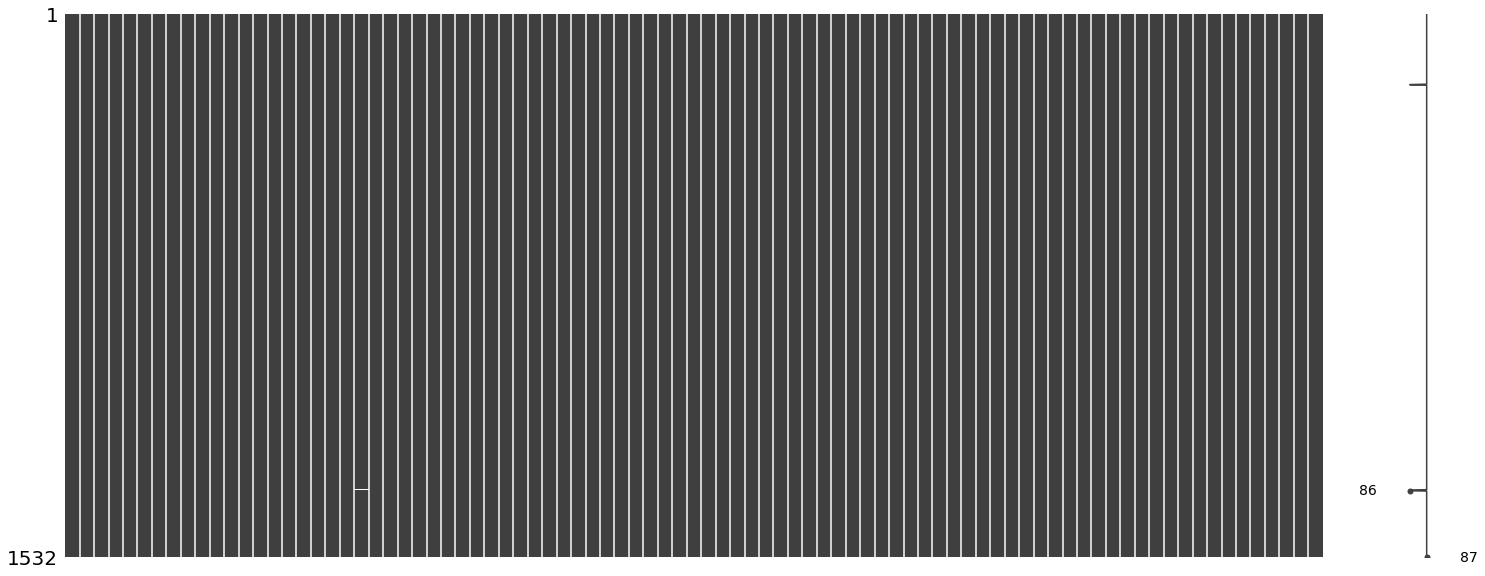

In [872]:
# Assess missingness from 1970 onwards
miss.matrix(religion_yr)

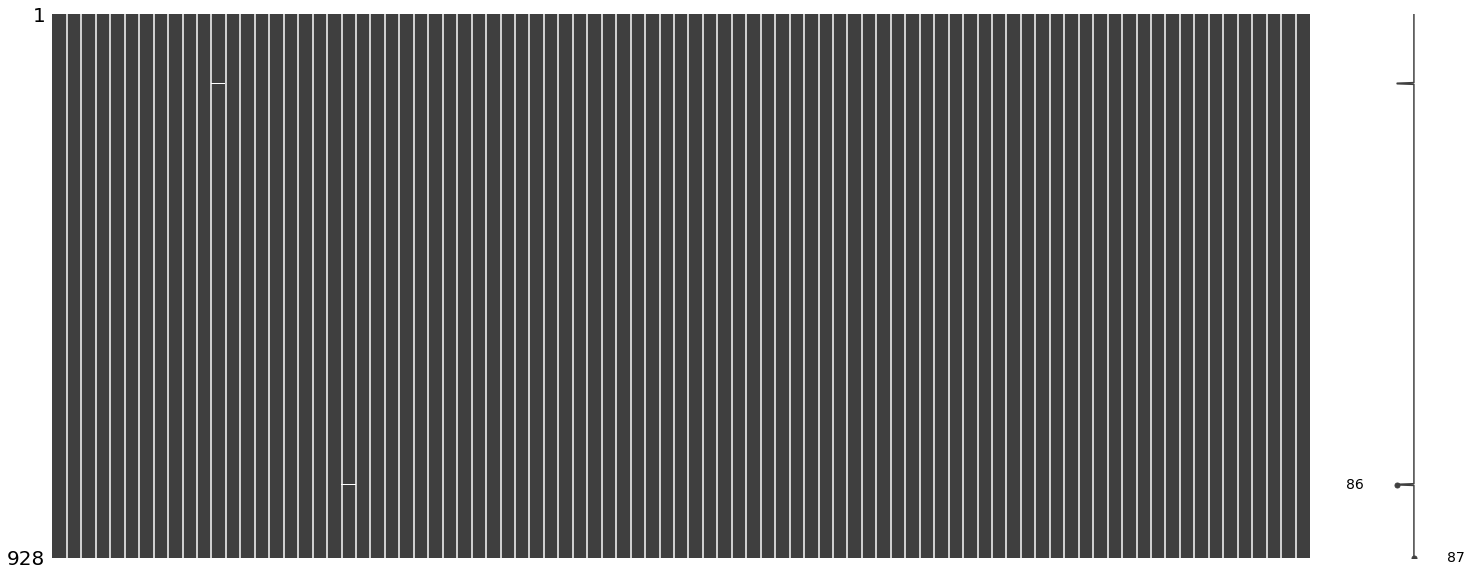

In [875]:
# Assess missingness from 1990 onwards
miss.matrix(religion_yr[religion_yr["year"]>=1990])

In [877]:
religion_yr.columns

Index(['year', 'state', 'name', 'chrstprot', 'chrstcat', 'chrstorth',
       'chrstang', 'chrstothr', 'chrstgen', 'judorth', 'jdcons', 'judref',
       'judothr', 'judgen', 'islmsun', 'islmshi', 'islmibd', 'islmnat',
       'islmalw', 'islmahm', 'islmothr', 'islmgen', 'budmah', 'budthr',
       'budothr', 'budgen', 'zorogen', 'hindgen', 'sikhgen', 'shntgen',
       'bahgen', 'taogen', 'jaingen', 'confgen', 'syncgen', 'anmgen',
       'nonrelig', 'othrgen', 'sumrelig', 'pop', 'chrstprotpct', 'chrstcatpct',
       'chrstorthpct', 'chrstangpct', 'chrstothrpct', 'chrstgenpct',
       'judorthpct', 'judconspct', 'judrefpct', 'judothrpct', 'judgenpct',
       'islmsunpct', 'islmshipct', 'islmibdpct', 'islmnatpct', 'islmalwpct',
       'islmahmpct', 'islmothrpct', 'islmgenpct', 'budmahpct', 'budthrpct',
       'budothrpct', 'budgenpct', 'zorogenpct', 'hindgenpct', 'sikhgenpct',
       'shntgenpct', 'bahgenpct', 'taogenpct', 'jaingenpct', 'confgenpct',
       'syncgenpct', 'anmgenpct', 'nonrel

In [881]:
# Bin by major religion
religion_yr["christianity_pct"] = religion_yr[['chrstprotpct', 'chrstcatpct','chrstorthpct', 'chrstangpct',
                                                     'chrstothrpct', 'chrstgenpct']].sum(axis=1)
religion_yr["judaism_pct"] = religion_yr[['judorthpct', 'judconspct', 'judrefpct', 'judothrpct', 'judgenpct']].sum(axis=1)
religion_yr["islam_pct"] = religion_yr[['islmsunpct', 'islmshipct', 'islmibdpct', 'islmnatpct', 'islmalwpct',
                                              'islmahmpct', 'islmothrpct', 'islmgenpct']].sum(axis=1)
religion_yr["buddhism_pct"] = religion_yr[['budmahpct', 'budthrpct','budothrpct', 'budgenpct']].sum(axis=1)

In [883]:
# Filter impt variables
religion_pct_yr=religion_yr.filter(["year","StateNme",'christianity_pct','judaism_pct','islam_pct','buddhism_pct',
                                   'zorogenpct', 'hindgenpct', 'sikhgenpct','shntgenpct', 'bahgenpct', 'taogenpct',
                                    'jaingenpct', 'confgenpct','syncgenpct', 'anmgenpct', 'nonreligpct', 'othrgenpct'])

In [885]:
# Check if all country names can be standardized
cc = coco.CountryConverter()
country_raw = list(pd.unique(religion_pct_yr["StateNme"]))
country_cc = cc.convert(names=country_raw, to='name_short')
country_cc

German Federal Republic not found in regex
German Democratic Republic not found in regex
Yugoslavia not found in regex
Republic of Vietnam not found in regex


['United States',
 'Canada',
 'Bahamas',
 'Cuba',
 'Haiti',
 'Dominican Republic',
 'Jamaica',
 'Trinidad and Tobago',
 'Barbados',
 'Dominica',
 'Grenada',
 'St. Lucia',
 'St. Vincent and the Grenadines',
 'Antigua and Barbuda',
 'St. Kitts and Nevis',
 'Mexico',
 'Belize',
 'Guatemala',
 'Honduras',
 'El Salvador',
 'Nicaragua',
 'Costa Rica',
 'Panama',
 'Colombia',
 'Venezuela',
 'Guyana',
 'Suriname',
 'Ecuador',
 'Peru',
 'Brazil',
 'Bolivia',
 'Paraguay',
 'Chile',
 'Argentina',
 'Uruguay',
 'United Kingdom',
 'Ireland',
 'Netherlands',
 'Belgium',
 'Luxembourg',
 'France',
 'Monaco',
 'Liechtenstein',
 'Switzerland',
 'Spain',
 'Andorra',
 'Portugal',
 'Germany',
 'not found',
 'not found',
 'Poland',
 'Austria',
 'Hungary',
 'Czech Republic',
 'Czech Republic',
 'Slovakia',
 'Italy',
 'San Marino',
 'Malta',
 'Albania',
 'Montenegro',
 'Macedonia',
 'Croatia',
 'not found',
 'Bosnia and Herzegovina',
 'Kosovo',
 'Slovenia',
 'Greece',
 'Cyprus',
 'Bulgaria',
 'Moldova',
 'Roma

For simplicity, we can drop the 4 countries that were not found in the country converter module.

In [886]:
#Standardize country names
country_raw_all = list(religion_pct_yr["StateNme"])
country_cc_all = cc.convert(names=country_raw_all, to='name_short')
religion_pct_yr=religion_pct_yr.assign(ctry_std = country_cc_all)

German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Republic of Vietnam not found in regex


In [888]:
# Rearrange and drop other country columns
religion_pct_yr=religion_pct_yr.filter(["year","ctry_std",'christianity_pct','judaism_pct','islam_pct','buddhism_pct',
                                   'zorogenpct', 'hindgenpct', 'sikhgenpct','shntgenpct', 'bahgenpct', 'taogenpct',
                                    'jaingenpct', 'confgenpct','syncgenpct', 'anmgenpct', 'nonreligpct', 'othrgenpct'])

In [890]:
# Drop "not found"
religion_pct_yr = religion_pct_yr[religion_pct_yr["ctry_std"]!="not found"]

In [891]:
# Combine duplicates
religion_pct_yr = religion_pct_yr.groupby(["year","ctry_std"]).mean().reset_index()

In [892]:
# Identify data source
religion_pct_yr["Source_WorldReligionsProject"]=1

In [893]:
religion_pct_yr

year     ctry_std  christianity_pct  judaism_pct  islam_pct  \
0     1970  Afghanistan            0.0012       0.0000     1.9785   
1     1970      Albania            0.5520       0.0002     0.9676   
2     1970      Algeria            0.0158       0.0000     1.9804   
3     1970    Argentina            1.9378       0.0396     0.0004   
4     1970    Australia            1.8590       0.0098     0.0040   
...    ...          ...               ...          ...        ...   
1502  2010    Venezuela            1.9000       0.0012     0.0020   
1503  2010      Vietnam            0.1820       0.0000     0.0022   
1504  2010        Yemen            0.0000       0.0000     1.9800   
1505  2010       Zambia            1.7400       0.0002     0.0110   
1506  2010     Zimbabwe            1.6377       0.0018     0.0214   

      buddhism_pct  zorogenpct  hindgenpct  sikhgenpct  shntgenpct  bahgenpct  \
0           0.0006      0.0003      0.0084      0.0002         0.0     0.0000   
1           0.0000      0.0000      0.0000      0.0000         0.0     0.0000   
2           0.0000      0.0000      0.0000      0.0000         0.0     0.0000   
3           0.0008      0.0000      0.0000      0.0000         0.0     0.0001   
4           0.0018      0.0000      0.0004      0.0002         0.0     0.0007   
...            ...         ...         ...         ...         ...        ...   
1502        0.0008      0.0000      0.0000      0.0000         0.0     0.0003   
1503        0.9800      0.0000      0.0006      0.0000         0.0     0.0037   
1504        0.0000      0.0000      0.0000      0.0000         0.0     0.0000   
1505        0.0006      0.0000      0.0050      0.0000         0.0     0.0111   
1506        0.0000      0.0000      0.0015      0.0000         0.0     0.0021   

      taogenpct  jaingenpct  confgenpct  syncgenpct  anmgenpct  nonreligpct  \
0           0.0         0.0         0.0      0.0000     0.0008       0.0001   
1           0.0         0.0         0.0      0.0000     0.0000       0.2400   
2           0.0         0.0         0.0      0.0000     0.0000       0.0000   
3           0.0         0.0         0.0      0.0000     0.0013       0.0046   
4           0.0         0.0         0.0      0.0004     0.0004       0.0598   
...         ...         ...         ...         ...        ...          ...   
1502        0.0         0.0         0.0      0.0002     0.0019       0.0439   
1503        0.0         0.0         0.0      0.0093     0.0400       0.3640   
1504        0.0         0.0         0.0      0.0000     0.0000       0.0000   
1505        0.0         0.0         0.0      0.0000     0.1049       0.0018   
1506        0.0         0.0         0.0      0.0000     0.1354       0.0256   

      othrgenpct  Source_WorldReligionsProject  
0         0.0001                             1  
1         0.0000                             1  
2         0.0018                             1  
3         0.0048                             1  
4         0.0008                             1  
...          ...                           ...  
1502      0.0016                             1  
1503      0.0003                             1  
1504      0.0100                             1  
1505      0.0013                             1  
1506      0.0049                             1  

[1507 rows x 19 columns]

# Read in data - Harvard Human Rights Protection Scores

In [833]:
# 02 Harvard Dataverse--Human Rights Protection
humanrights = pd.read_csv("Data/02 Harvard Dataverse--Human Rights Protection/HumanRightsProtectionScores_v3.01.csv")

In [834]:
# Match country code with Correlates of War country codes
humrights_yr = humanrights.merge(COWcountrycodes,left_on="COW",right_on="CCode",how="left")
# Take data from 1970 onwards
humrights_yr = humrights_yr[humrights_yr["YEAR"]>=1970]

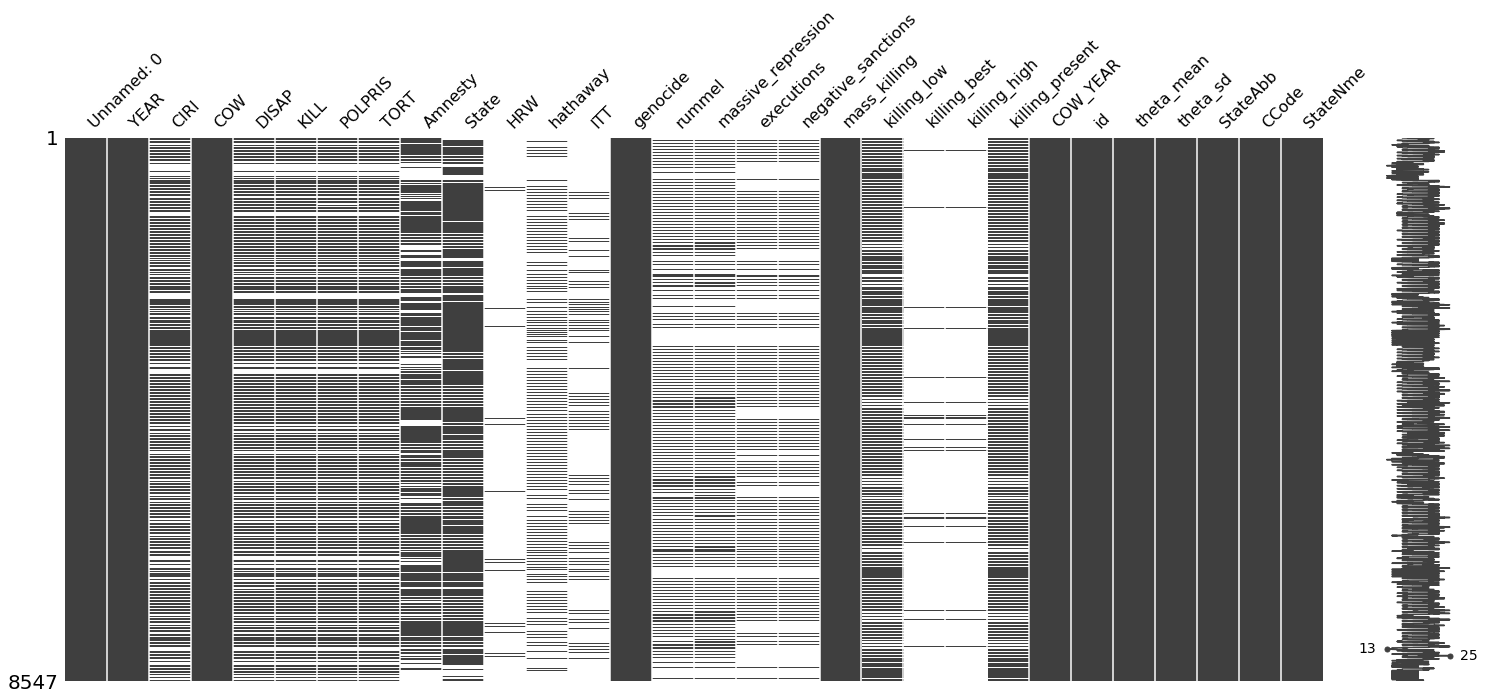

In [835]:
# Assess missingness from 1970 onwards
miss.matrix(humrights_yr)

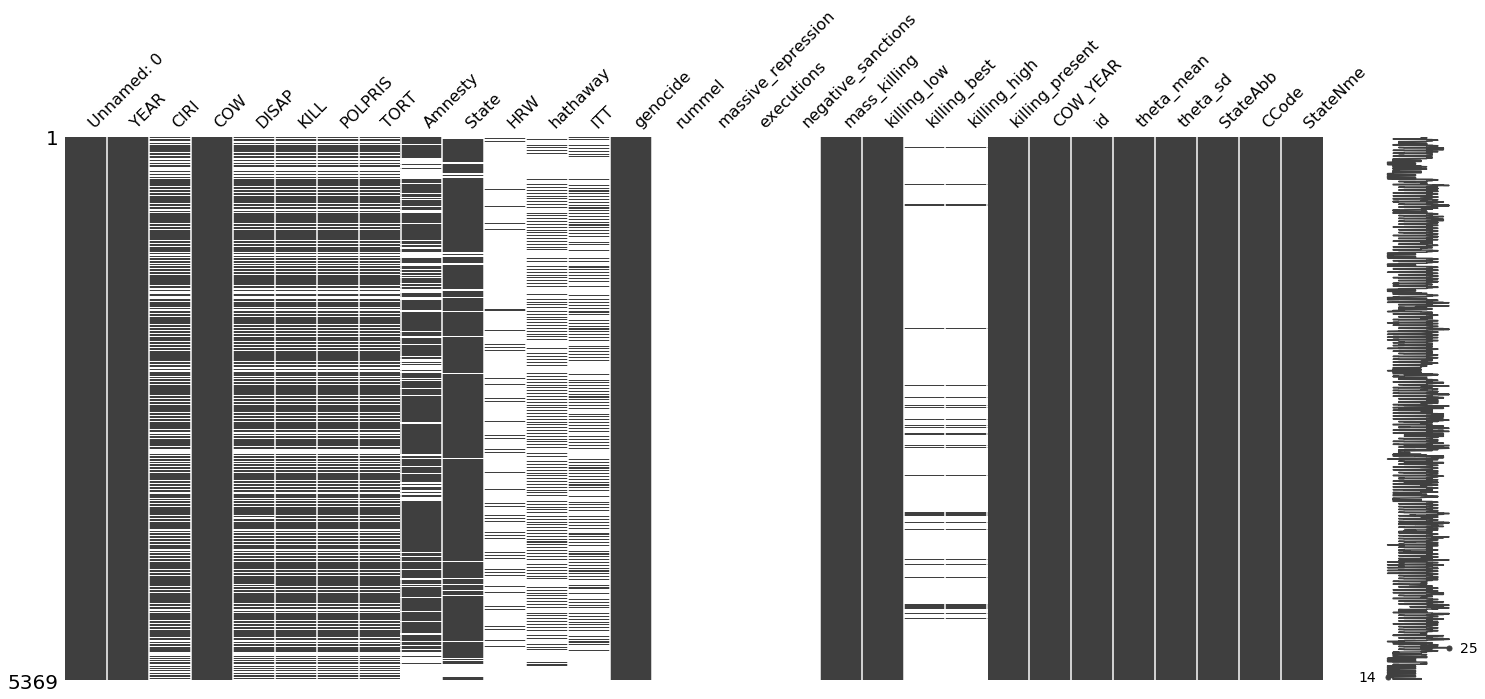

In [836]:
# Assess missingness from 1990 onwards
miss.matrix(humrights_yr[humrights_yr["YEAR"]>=1990])

In [837]:
humrights_yr.columns

Index(['Unnamed: 0', 'YEAR', 'CIRI', 'COW', 'DISAP', 'KILL', 'POLPRIS', 'TORT',
       'Amnesty', 'State', 'HRW', 'hathaway', 'ITT', 'genocide', 'rummel',
       'massive_repression', 'executions', 'negative_sanctions',
       'mass_killing', 'killing_low', 'killing_best', 'killing_high',
       'killing_present', 'COW_YEAR', 'id', 'theta_mean', 'theta_sd',
       'StateAbb', 'CCode', 'StateNme'],
      dtype='object')

In [838]:
# Filter impt variables
humrights_yr=humrights_yr.filter(["YEAR","CCode",'StateAbb', 'StateNme','DISAP', 'KILL', 'POLPRIS', 'TORT','Amnesty','State'
                    'mass_killing','killing_low','killing_present'])

In [839]:
humrights_yr

YEAR  CCode StateAbb                  StateNme  DISAP  KILL  POLPRIS  \
24     1970      2      USA  United States of America    NaN   NaN      NaN   
25     1971      2      USA  United States of America    NaN   NaN      NaN   
26     1972      2      USA  United States of America    NaN   NaN      NaN   
27     1973      2      USA  United States of America    NaN   NaN      NaN   
28     1974      2      USA  United States of America    NaN   NaN      NaN   
...     ...    ...      ...                       ...    ...   ...      ...   
11712  2013    990      WSM                     Samoa    NaN   NaN      NaN   
11713  2014    990      WSM                     Samoa    NaN   NaN      NaN   
11714  2015    990      WSM                     Samoa    NaN   NaN      NaN   
11715  2016    990      WSM                     Samoa    NaN   NaN      NaN   
11716  2017    990      WSM                     Samoa    NaN   NaN      NaN   

       TORT  Amnesty  killing_low  killing_present  
24      NaN      NaN          NaN              NaN  
25      NaN      NaN          NaN              NaN  
26      NaN      NaN          NaN              NaN  
27      NaN      NaN          NaN              NaN  
28      NaN      NaN          NaN              NaN  
...     ...      ...          ...              ...  
11712   NaN      NaN          0.0              0.0  
11713   NaN      NaN          0.0              0.0  
11714   NaN      NaN          0.0              0.0  
11715   NaN      NaN          0.0              0.0  
11716   NaN      NaN          0.0              0.0  

[8547 rows x 11 columns]

In [840]:
# Check if all country names can be standardized
cc = coco.CountryConverter()
country_raw = list(pd.unique(humrights_yr["StateNme"]))
country_cc = cc.convert(names=country_raw, to='name_short')
country_cc

German Federal Republic not found in regex
German Democratic Republic not found in regex
Yugoslavia not found in regex
Republic of Vietnam not found in regex


['United States',
 'Canada',
 'Bahamas',
 'Cuba',
 'Haiti',
 'Dominican Republic',
 'Jamaica',
 'Trinidad and Tobago',
 'Barbados',
 'Dominica',
 'Grenada',
 'St. Lucia',
 'St. Vincent and the Grenadines',
 'Antigua and Barbuda',
 'St. Kitts and Nevis',
 'Mexico',
 'Belize',
 'Guatemala',
 'Honduras',
 'El Salvador',
 'Nicaragua',
 'Costa Rica',
 'Panama',
 'Colombia',
 'Venezuela',
 'Guyana',
 'Suriname',
 'Ecuador',
 'Peru',
 'Brazil',
 'Bolivia',
 'Paraguay',
 'Chile',
 'Argentina',
 'Uruguay',
 'United Kingdom',
 'Ireland',
 'Netherlands',
 'Belgium',
 'Luxembourg',
 'France',
 'Monaco',
 'Liechtenstein',
 'Switzerland',
 'Spain',
 'Andorra',
 'Portugal',
 'Germany',
 'not found',
 'not found',
 'Poland',
 'Austria',
 'Hungary',
 'Czech Republic',
 'Slovakia',
 'Italy',
 'San Marino',
 'Malta',
 'Albania',
 'Montenegro',
 'Macedonia',
 'Croatia',
 'not found',
 'Bosnia and Herzegovina',
 'Kosovo',
 'Slovenia',
 'Greece',
 'Cyprus',
 'Bulgaria',
 'Moldova',
 'Romania',
 'Russia',
 '

For simplicity, we can drop the 4 countries that were not found in the country converter module.

In [841]:
#Standardize country names
country_raw_all = list(humrights_yr["StateNme"])
country_cc_all = cc.convert(names=country_raw_all, to='name_short')
humrights_yr=humrights_yr.assign(ctry_std = country_cc_all)

German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Federal Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
Germa

In [842]:
# Rearrange and drop other country columns
humrights_yr=humrights_yr.filter(["YEAR","ctry_std",'DISAP', 'KILL', 'POLPRIS', 'TORT','Amnesty','State'
                    'mass_killing','killing_low','killing_present'])

In [843]:
humrights_yr["ctry_std"].value_counts(dropna=False,ascending=False)

not found      96
Yemen          70
Maldives       48
Sudan          48
Philippines    48
               ..
Nauru          19
Kiribati       19
Tuvalu         18
Kosovo         10
South Sudan     7
Name: ctry_std, Length: 195, dtype: int64

Duplicates were found for Yemen. We will take groupby to combine that and others that may have duplicated.

In [857]:
# Drop "not found"
humrights_yr = humrights_yr[humrights_yr["ctry_std"]!="not found"]

In [858]:
# Combine duplicates like Yemen
humrights_yr = humrights_yr.groupby(["YEAR","ctry_std"]).mean().reset_index()

In [865]:
# Identify data source
humrights_yr["Source_HarvardHumRights"]=1

In [866]:
humrights_yr

YEAR     ctry_std  DISAP  KILL  POLPRIS  TORT  Amnesty  killing_low  \
0     1970  Afghanistan    NaN   NaN      NaN   NaN      NaN          NaN   
1     1970      Albania    NaN   NaN      NaN   NaN      NaN          NaN   
2     1970      Algeria    NaN   NaN      NaN   NaN      NaN          NaN   
3     1970       Angola    NaN   NaN      NaN   NaN      NaN          NaN   
4     1970    Argentina    NaN   NaN      NaN   NaN      NaN          NaN   
...    ...          ...    ...   ...      ...   ...      ...          ...   
8424  2017    Venezuela    NaN   NaN      NaN   NaN      4.0          0.0   
8425  2017      Vietnam    NaN   NaN      NaN   NaN      3.0          0.0   
8426  2017        Yemen    NaN   NaN      NaN   NaN      5.0          0.0   
8427  2017       Zambia    NaN   NaN      NaN   NaN      2.0          0.0   
8428  2017     Zimbabwe    NaN   NaN      NaN   NaN      3.0          0.0   

      killing_present  Source_HarvardHumRights  
0                 NaN                        1  
1                 NaN                        1  
2                 NaN                        1  
3                 NaN                        1  
4                 NaN                        1  
...               ...                      ...  
8424              0.0                        1  
8425              0.0                        1  
8426              0.0                        1  
8427              0.0                        1  
8428              0.0                        1  

[8429 rows x 10 columns]

# Read in data - Our World in Data

In [916]:
# 04 Our World in Data
milexp_gdp = pd.read_csv("Data/04 Our World in Data/military-expenditure-as-share-of-gdp.csv")
milexp_percap = pd.read_csv("Data/04 Our World in Data/military-expenditure-per-capita.csv")
milpers = pd.read_csv("Data/04 Our World in Data/military-personnel.csv")
terrain = pd.read_csv("Data/04 Our World in Data/terrain-ruggedness-index.csv")

In [931]:
#Consolidate data
owid_yr = pd.merge(milexp_gdp,milexp_percap,on=["Year","Entity","Code"],how="outer").merge(milpers,on=["Year","Entity","Code"],how="outer").merge(terrain,on=["Entity","Code"],how="outer")

In [970]:
owid_yr = owid_yr[owid_yr['Year']>=1970]

In [937]:
# Check if all country names can be standardized
cc = coco.CountryConverter()
country_raw = list(pd.unique(owid_yr["Entity"]))
country_cc = cc.convert(names=country_raw, to='name_short')
country_cc

Arab World not found in regex
Caribbean small states not found in regex
Central Europe and the Baltics not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific ( not found in regex
Euro area not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia ( not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
Heavily indebted poor countries (HIPC) not found in regex
High income not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA blend not found in regex
IDA only not found in regex
IDA total not found in regex
Late-demographic dividend not found in regex
Latin America & Caribbean not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean ( not found in regex
Leas

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'not found',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cabo Verde',
 'not found',
 'Central African Republic',
 'not found',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo Republic',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'DR Congo',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'not found',
 'not found',
 'not found',
 'not found',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'Fiji',
 'Finland',
 'not found',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Gui

In [938]:
#Standardize country names
country_raw_all = list(owid_yr["Entity"])
country_cc_all = cc.convert(names=country_raw_all, to='name_short')
owid_yr=owid_yr.assign(ctry_std = country_cc_all)

Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World

East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & 

Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia ( not found in re

Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebted poor countries (HIPC) not found in regex
Heavily indebt

IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not found in regex
IDA blend not 

Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America 

Least developed countries: UN classification not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex


Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (I

Middle income not found in regex
Middle income not found in regex
Middle income not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North Amer

Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not found in regex
Pre-demographic dividend not fou

Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (IDA & IBRD) not found in regex
Sub-Saharan Africa (I

World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
World not found in regex
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match 

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
Hesse Grand Ducal not found in regex
H

Two Sicilies not found in regex
Two Sicilies not found in regex
Two Sicilies not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Germany not found in regex
West Ger

In [939]:
# Drop "not found"
owid_yr = owid_yr[owid_yr["ctry_std"]!="not found"]

In [945]:
# Drop those without any year
owid_yr=owid_yr.dropna(subset=['Year'])

In [954]:
owid_yr.columns

Index(['Entity', 'Code', 'Year', 'Military expenditure (% of GDP)',
       'Military expenditure per capita, current USD (OWID based on COW and SIPRI)',
       'Military personnel (COW (2017))',
       'Terrain Ruggedness Index 100m (Nunn and Puga 2012)', 'ctry_std'],
      dtype='object')

In [955]:
# Rearrange and drop other country identifer columns
owid_yr=owid_yr.filter(["Year","ctry_std",'Military expenditure (% of GDP)',
                        'Military expenditure per capita, current USD (OWID based on COW and SIPRI)',
                        'Military personnel (COW (2017))',
                        'Terrain Ruggedness Index 100m (Nunn and Puga 2012)'])

In [975]:
# Combine duplicates if any
owid_yr=owid_yr.groupby(["Year","ctry_std"]).mean().reset_index()

In [977]:
# Identify data source
owid_yr["Source_OurWorldinData"]=1

In [980]:
owid_yr

Year     ctry_std  Military expenditure (% of GDP)  \
0     1970.0  Afghanistan                         1.629606   
1     1970.0      Albania                              NaN   
2     1970.0      Algeria                         2.130539   
3     1970.0    Argentina                         1.877778   
4     1970.0    Australia                         2.966036   
...      ...          ...                              ...   
8005  2017.0      Uruguay                         2.051628   
8006  2017.0    Venezuela                         0.487844   
8007  2017.0      Vietnam                         2.286511   
8008  2017.0       Zambia                         1.341520   
8009  2017.0     Zimbabwe                         1.970583   

      Military expenditure per capita, current USD (OWID based on COW and SIPRI)  \
0                                                  1.43                            
1                                                 45.90                            
2                                                  7.22                            
3                                                 21.46                            
4                                                 94.76                            
...                                                 ...                            
8005                                                NaN                            
8006                                                NaN                            
8007                                                NaN                            
8008                                                NaN                            
8009                                                NaN                            

      Military personnel (COW (2017))  \
0                             91000.0   
1                             52000.0   
2                             80000.0   
3                            140000.0   
4                             86000.0   
...                               ...   
8005                              NaN   
8006                              NaN   
8007                              NaN   
8008                              NaN   
8009                              NaN   

      Terrain Ruggedness Index 100m (Nunn and Puga 2012)  \
0                                                 2.518    
1                                                 3.427    
2                                                 0.510    
3                                                 0.775    
4                                                 0.143    
...                                                 ...    
8005                                              0.435    
8006                                              0.634    
8007                                              2.054    
8008                                              0.533    
8009                                              1.194    

      Source_OurWorldinData  
0                         1  
1                         1  
2                         1  
3                         1  
4                         1  
...                     ...  
8005                      1  
8006                      1  
8007                      1  
8008                      1  
8009                      1  

[8010 rows x 7 columns]

# Read in data - Polity

In [1064]:
# 05 Center for Systemic Peace_Polity
polity = pd.read_excel("Data/05 Center for Systemic Peace_Polity/p5v2018.xls")

In [1065]:
polity_yr = polity[polity['year']>=1970]

In [1066]:
# Check if all country names can be standardized
cc = coco.CountryConverter()
country_raw = list(pd.unique(polity_yr["country"]))
country_cc = cc.convert(names=country_raw, to='name_short')
country_cc

Vietnam North not found in regex
Germany East not found in regex
Germany West not found in regex
South Vietnam not found in regex
UAE not found in ISO3
USSR not found in regex
Yugoslavia not found in regex
Serbia and Montenegro not found in regex


['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bhutan',
 'Belarus',
 'Bangladesh',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Burundi',
 'Bulgaria',
 'Cambodia',
 'Canada',
 'Cameroon',
 'Cabo Verde',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo Republic',
 'Congo Republic',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'not found',
 'Ecuador',
 'Egypt',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Timor-Leste',
 'Finland',
 'Fiji',
 'France',
 'Gabon',
 'Gambia',
 'not found',
 'not found',
 'Ghana',
 'Germany',
 'Guinea-Bissau',
 'Greece',
 'Georgia',
 'Guatemala',
 'Guinea',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'India',
 'Indonesia',
 'Ireland',
 'Iran',
 'Iraq',
 'Israel',
 'Italy'

In [1067]:
polity_yr["country"]=polity_yr["country"].str.replace("UAE","United Arab Emirates")

C:\DataScience\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1068]:
#Standardize country names
country_raw_all = list(polity_yr["country"])
country_cc_all = cc.convert(names=country_raw_all, to='name_short')
polity_yr=polity_yr.assign(ctry_std = country_cc_all)

Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany West not found in regex
Germany West not found in regex
Germany West not found in regex
G

In [1069]:
# Drop "not found"
polity_yr = polity_yr[polity_yr["ctry_std"]!="not found"]

In [1070]:
# Combine duplicates if any
polity_yr=polity_yr.groupby(["year","ctry_std"]).mean().reset_index()

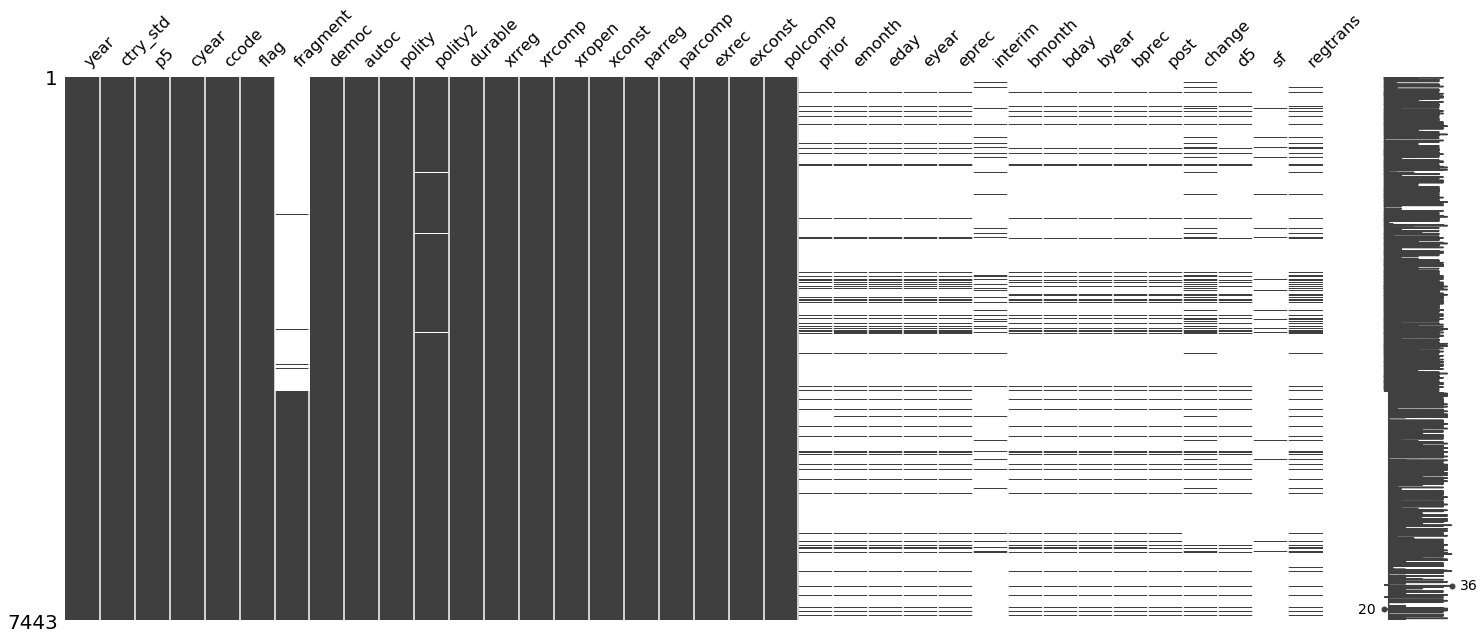

In [1071]:
# Assess missingness from 1970 onwards
miss.matrix(polity_yr)

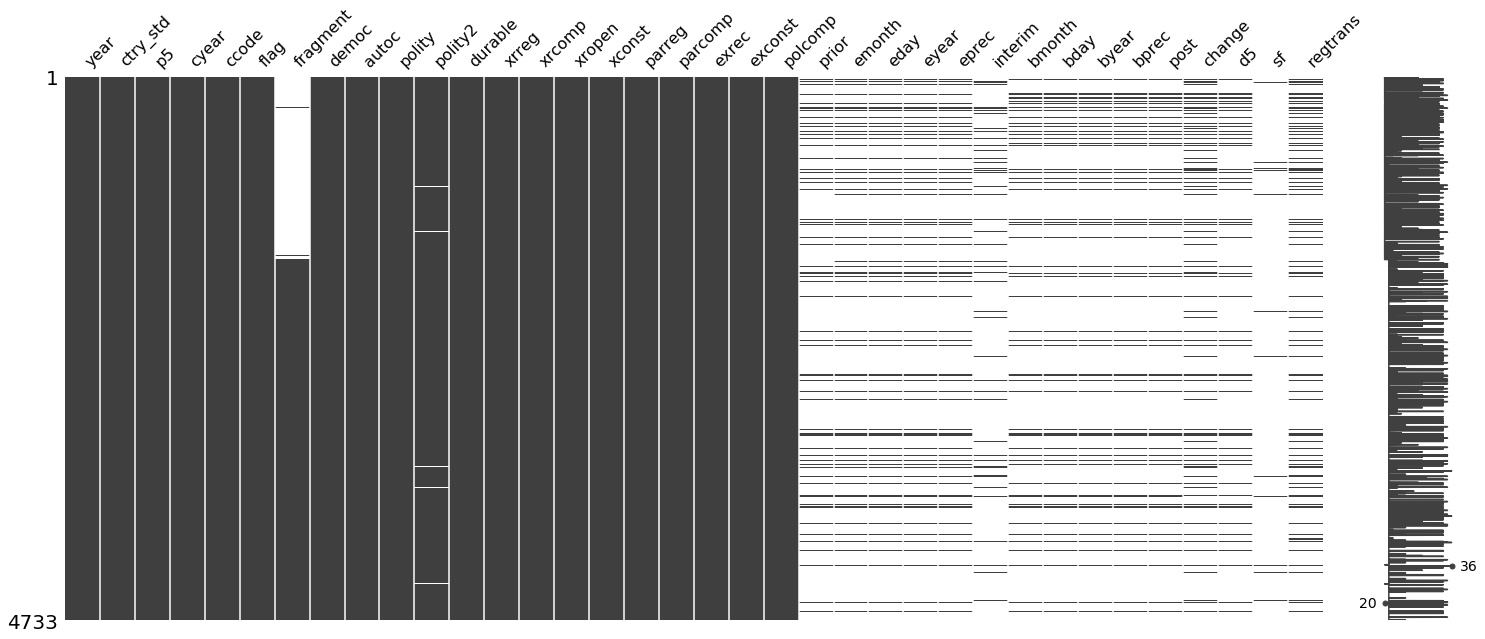

In [1072]:
# Assess missingness from 1990 onwards
miss.matrix(polity_yr[polity_yr["year"]>=1990])

In [1073]:
polity_yr.columns

Index(['year', 'ctry_std', 'p5', 'cyear', 'ccode', 'flag', 'fragment', 'democ',
       'autoc', 'polity', 'polity2', 'durable', 'xrreg', 'xrcomp', 'xropen',
       'xconst', 'parreg', 'parcomp', 'exrec', 'exconst', 'polcomp', 'prior',
       'emonth', 'eday', 'eyear', 'eprec', 'interim', 'bmonth', 'bday',
       'byear', 'bprec', 'post', 'change', 'd5', 'sf', 'regtrans'],
      dtype='object')

In [1074]:
# Convert standardized authority codes to dummies
polity_yr["interruption_dummy"]=1*(polity_yr["democ"]==-66)
polity_yr["interregnum_dummy"]=1*(polity_yr["democ"]==-77)
polity_yr["transition_dummy"]=1*(polity_yr["democ"]==-88)

In [1075]:
# Select relevant columns
# Based on missingness and definition of indicators
polity_yr=polity_yr.filter(["year","ctry_std",'democ','autoc','polity2','durable',
                  'interruption_dummy','interregnum_dummy','transition_dummy'])

In [1076]:
#Set standardized authority codes to NAN
polity_yr['democ'] = np.where((polity_yr.democ < 0), np.nan, polity_yr.democ)
polity_yr['autoc'] = np.where((polity_yr.autoc < 0), np.nan, polity_yr.autoc)

In [1079]:
# Identify data source
polity_yr["Source_Polity"]=1

In [1080]:
polity_yr

year     ctry_std  democ  autoc  polity2  durable  interruption_dummy  \
0     1970  Afghanistan    0.0    7.0     -7.0      6.0                   0   
1     1970      Albania    0.0    9.0     -9.0     24.0                   0   
2     1970      Algeria    0.0    9.0     -9.0      8.0                   0   
3     1970    Argentina    0.0    9.0     -9.0      4.0                   0   
4     1970    Australia   10.0    0.0     10.0     69.0                   0   
...    ...          ...    ...    ...      ...      ...                 ...   
7438  2018    Venezuela    1.0    4.0     -3.0      1.0                   0   
7439  2018      Vietnam    0.0    7.0     -7.0     64.0                   0   
7440  2018        Yemen    NaN    NaN      0.0      0.0                   0   
7441  2018       Zambia    6.0    0.0      6.0     17.0                   0   
7442  2018     Zimbabwe    5.0    1.0      4.0      5.0                   0   

      interregnum_dummy  transition_dummy  Source_Polity  
0                     0                 0              1  
1                     0                 0              1  
2                     0                 0              1  
3                     0                 0              1  
4                     0                 0              1  
...                 ...               ...            ...  
7438                  0                 0              1  
7439                  0                 0              1  
7440                  1                 0              1  
7441                  0                 0              1  
7442                  0                 0              1  

[7443 rows x 10 columns]

# Read in data - World Bank

In [1092]:
wbdata_period = datetime.datetime(1970, 1, 1), datetime.datetime(2018, 1, 1)

In [1093]:
wbdata_conso = wbdata.get_dataframe({"NY.GDP.PCAP.KD":"GDP per capita (constant 2010 US$)",
                                     "NY.GDP.MKTP.KD.ZG":"GDP growth (annual %)",
                                     "FP.CPI.TOTL.ZG":"Inflation, consumer prices (annual %)",
                                     "SP.POP.TOTL":"Population, total",
                                     "SI.POV.DDAY":"Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)",
                                     "SI.POV.GINI":"Inequality (Gini index)",
                                    "NY.GDP.PETR.RT.ZS":"Oil rents (% of GDP)",
                                    "SE.ADT.LITR.ZS":"Literacy rate, adult total (% of people ages 15 and above)",
                                    "SL.UEM.TOTL.NE.ZS":"Unemployment, total (% of total labor force) (national estimate)",
                                    "GC.NFN.TOTL.GD.ZS":"Net investment in nonfinancial assets (% of GDP)",
                                    "BX.TRF.PWKR.DT.GD.ZS":"Personal remittances, received (% of GDP)"},
                              data_date=wbdata_period,
                              freq="Y")

In [1094]:
wbdata_yr=wbdata_conso.reset_index()

In [1095]:
wbdata_yr

country  date  GDP per capita (constant 2010 US$)  \
0      Arab World  2018                         6456.278325   
1      Arab World  2017                         6445.933776   
2      Arab World  2016                         6518.063258   
3      Arab World  2015                         6424.358207   
4      Arab World  2014                         6352.805572   
...           ...   ...                                 ...   
12931    Zimbabwe  1974                         1464.417921   
12932    Zimbabwe  1973                         1421.876552   
12933    Zimbabwe  1972                         1435.560146   
12934    Zimbabwe  1971                         1372.823670   
12935    Zimbabwe  1970                         1305.147560   

       GDP growth (annual %)  Inflation, consumer prices (annual %)  \
0                   2.079469                               2.458142   
1                   0.820847                               1.966826   
2                   3.507128                               2.068840   
3                   3.243312                               1.814077   
4                   2.505076                               2.772885   
...                      ...                                    ...   
12931               6.625154                                    NaN   
12932               2.604715                                    NaN   
12933               8.329775                                    NaN   
12934               8.917587                                    NaN   
12935              22.565151                                    NaN   

       Population, total  \
0            419790591.0   
1            411898967.0   
2            404024435.0   
3            396028278.0   
4            387907747.0   
...                  ...   
12931          6085074.0   
12932          5877726.0   
12933          5673911.0   
12934          5476982.0   
12935          5289303.0   

       Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)  \
0                                                    NaN                     
1                                                    NaN                     
2                                                    NaN                     
3                                                    NaN                     
4                                                    NaN                     
...                                                  ...                     
12931                                                NaN                     
12932                                                NaN                     
12933                                                NaN                     
12934                                                NaN                     
12935                                                NaN                     

       Inequality (Gini index)  Oil rents (% of GDP)  \
0                          NaN             21.434614   
1                          NaN             16.793760   
2                          NaN             13.064365   
3                          NaN             15.517750   
4                          NaN             26.917303   
...                        ...                   ...   
12931                      NaN              0.000000   
12932                      NaN              0.000000   
12933                      NaN              0.000000   
12934                      NaN              0.000000   
12935                      NaN                   NaN   

       Literacy rate, adult total (% of people ages 15 and above)  \
0                                              72.869087            
1                                              75.766823            
2                                              74.840797            
3                                              73.499390            
4                                              75.713890            
...                                    

In [1096]:
# Check if all country names can be standardized
cc = coco.CountryConverter()
country_raw = list(pd.unique(wbdata_yr["country"]))
country_cc = cc.convert(names=country_raw, to='name_short')
country_cc

['not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'not found',
 'Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',


In [1097]:
#Standardize country names
country_raw_all = list(wbdata_yr["country"])
country_cc_all = cc.convert(names=country_raw_all, to='name_short')
wbdata_yr=wbdata_yr.assign(ctry_std = country_cc_all)

In [1098]:
# Drop "not found"
wbdata_yr = wbdata_yr[wbdata_yr["ctry_std"]!="not found"]

In [1101]:
# Combine duplicates if any
wbdata_yr=wbdata_yr.groupby(["date","ctry_std"]).mean().reset_index()

In [1106]:
# Convert date/year to numeric
wbdata_yr['date'] = pd.to_numeric(wbdata_yr['date'])

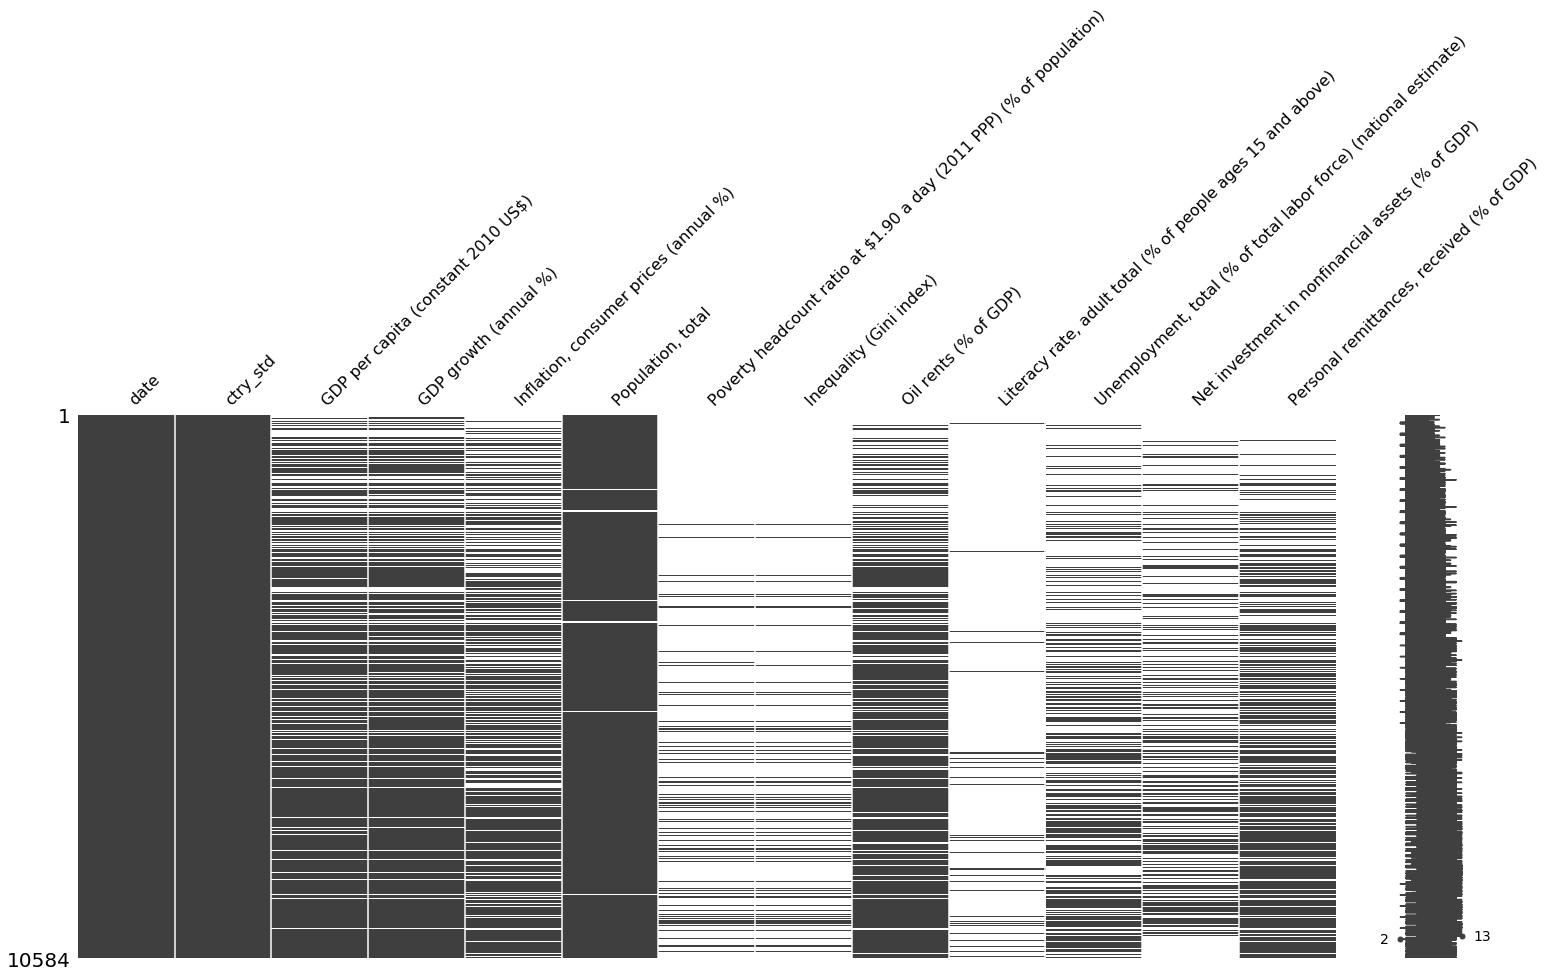

In [1107]:
# Assess missingness from 1970 onwards
miss.matrix(wbdata_yr)

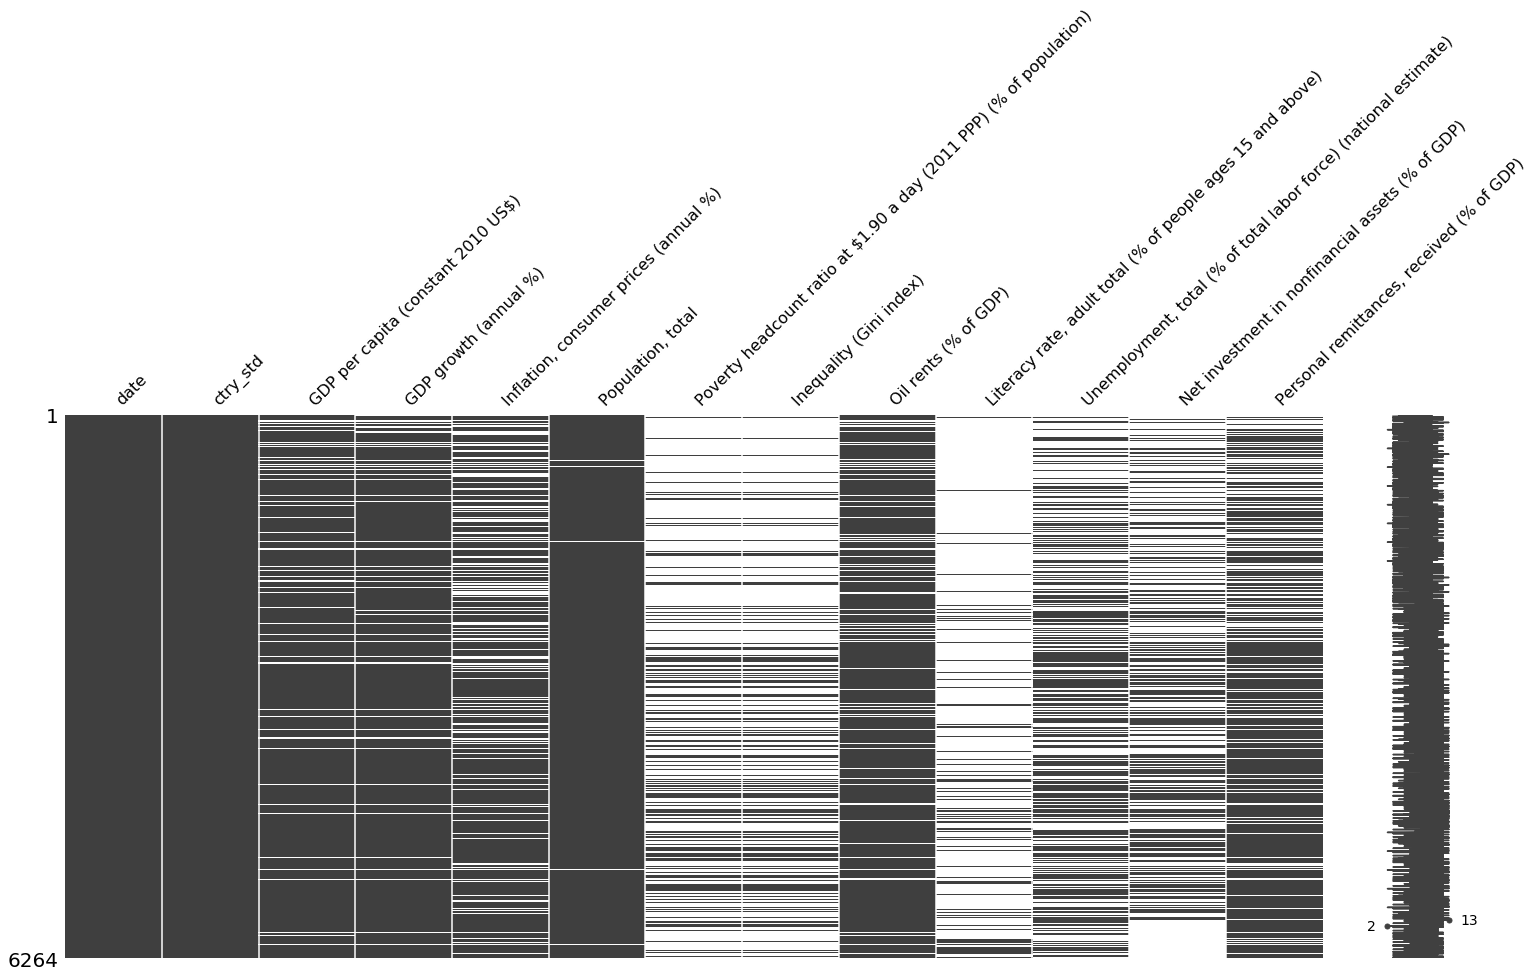

In [1108]:
# Assess missingness from 1990 onwards
miss.matrix(wbdata_yr[wbdata_yr["date"]>=1990])

The data is still sparse, but we could safely assume that these macroeconomic figures reflect broad underlying trends that do not easily shift. Since the data is distributed across time, it would not be too radical to impute their values.

In [1109]:
# Identify data source
wbdata_yr["Source_WB"]=1

In [1110]:
wbdata_yr

date        ctry_std  GDP per capita (constant 2010 US$)  \
0      1970     Afghanistan                                 NaN   
1      1970         Albania                                 NaN   
2      1970         Algeria                         2707.591775   
3      1970  American Samoa                                 NaN   
4      1970         Andorra                        41701.544427   
...     ...             ...                                 ...   
10579  2018       Venezuela                                 NaN   
10580  2018         Vietnam                         1964.475991   
10581  2018           Yemen                          632.909430   
10582  2018          Zambia                         1678.167258   
10583  2018        Zimbabwe                         1305.783295   

       GDP growth (annual %)  Inflation, consumer prices (annual %)  \
0                        NaN                                    NaN   
1                        NaN                                    NaN   
2                   8.862657                               6.600000   
3                        NaN                                    NaN   
4                        NaN                                    NaN   
...                      ...                                    ...   
10579                    NaN                                    NaN   
10580               7.075789                               3.539628   
10581               0.752599                                    NaN   
10582               4.034378                               7.494572   
10583               4.829674                                    NaN   

       Population, total  \
0             11173642.0   
1              2135479.0   
2             14464985.0   
3                27363.0   
4                24276.0   
...                  ...   
10579         28870195.0   
10580         95540395.0   
10581         28498687.0   
10582         17351822.0   
10583         14439018.0   

       Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)  \
0                                                    NaN                     
1                                                    NaN                     
2                                                    NaN                     
3                                                    NaN                     
4                                                    NaN                     
...                                                  ...                     
10579                                                NaN                     
10580                                                1.9                     
10581                                                NaN                     
10582                                                NaN                     
10583                                                NaN                     

       Inequality (Gini index)  Oil rents (% of GDP)  \
0                          NaN              0.017789   
1                          NaN                   NaN   
2                          NaN              8.273538   
3                          NaN                   NaN   
4                          NaN                   NaN   
...                        ...                   ...   
10579                      NaN                   NaN   
10580                     35.7              1.614027   
10581                      NaN              2.645542   
10582                      NaN              0.000000   
10583                      NaN              0.000000   

       Literacy rate, adult total (% of people ages 15 and above)  \
0                                                    NaN            
1                                                    NaN            
2                                                    NaN            
3                                                    NaN            
4                                                    NaN 

# Read in data - Varieties of Democracy

In [1254]:
vdems = pd.read_csv("Data/06 Varieties of Democracy (VDEMS)/V-Dem-CY-Core-v10.csv")

In [1346]:
vdems_yr = vdems[vdems['year']>=1970]

In [1347]:
vdems_yr = vdems_yr[vdems_yr['year']<=2018]

In [1348]:
# Check if all country names can be standardized
cc = coco.CountryConverter()
country_raw = list(pd.unique(vdems_yr["country_name"]))
country_cc = cc.convert(names=country_raw, to='name_short')
country_cc

['Mexico',
 'Suriname',
 'Sweden',
 'Switzerland',
 'Ghana',
 'South Africa',
 'Japan',
 'Myanmar',
 'Russia',
 'Albania',
 'Egypt',
 'Yemen',
 'Colombia',
 'Poland',
 'Brazil',
 'United States',
 'Portugal',
 'El Salvador',
 'Yemen',
 'Bangladesh',
 'Bolivia',
 'Haiti',
 'Honduras',
 'Mali',
 'Pakistan',
 'Peru',
 'Senegal',
 'South Sudan',
 'Sudan',
 'Vietnam',
 'not found',
 'Afghanistan',
 'Argentina',
 'Ethiopia',
 'India',
 'Kenya',
 'North Korea',
 'South Korea',
 'Kosovo',
 'Lebanon',
 'Nigeria',
 'Philippines',
 'Tanzania',
 'Taiwan',
 'Thailand',
 'Uganda',
 'Venezuela',
 'Benin',
 'Bhutan',
 'Burkina Faso',
 'Cambodia',
 'Indonesia',
 'Mozambique',
 'Nepal',
 'Nicaragua',
 'Niger',
 'Zambia',
 'Zimbabwe',
 'Guinea',
 "Cote d'Ivoire",
 'Mauritania',
 'Canada',
 'Australia',
 'Botswana',
 'Burundi',
 'Cabo Verde',
 'Central African Republic',
 'Chile',
 'Costa Rica',
 'Timor-Leste',
 'Ecuador',
 'France',
 'Germany',
 'Guatemala',
 'Iran',
 'Iraq',
 'Ireland',
 'Italy',
 'Jord

In [1349]:
#Standardize country names
country_raw_all = list(vdems_yr["country_name"])
country_cc_all = cc.convert(names=country_raw_all, to='name_short')
vdems_yr=vdems_yr.assign(ctry_std = country_cc_all)

In [1350]:
# Drop "not found"
vdems_yr = vdems_yr[vdems_yr["ctry_std"]!="not found"]

In [1351]:
# Combine duplicates if any
vdems_yr=vdems_yr.groupby(["year","ctry_std"]).mean().reset_index()

In [1352]:
# Select relevant columns based on definition of indicators
vdems_yr=vdems_yr.filter(["year","ctry_std",'v2x_polyarchy','v2x_libdem','v2x_partipdem','v2x_delibdem','v2x_egaldem'])

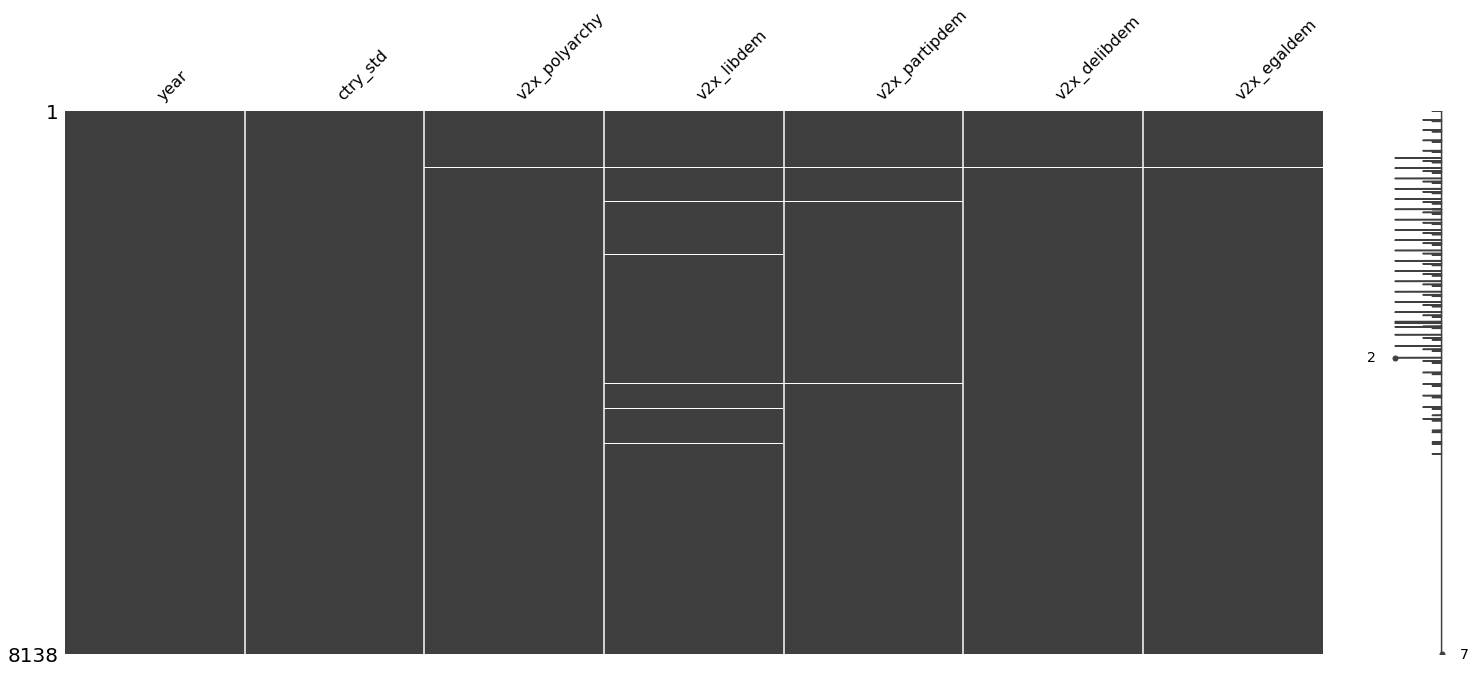

In [1353]:
# Assess missingness
miss.matrix(vdems_yr)

In [1354]:
# Check missing data
vdems_yr.isna().sum()

year              0
ctry_std          0
v2x_polyarchy    22
v2x_libdem       85
v2x_partipdem    54
v2x_delibdem     22
v2x_egaldem      22
dtype: int64

In [1355]:
# Identify data source
vdems_yr["Source_VDem"]=1

In [1356]:
vdems_yr

year     ctry_std  v2x_polyarchy  v2x_libdem  v2x_partipdem  \
0     1970  Afghanistan          0.173       0.107          0.042   
1     1970      Albania          0.178       0.068          0.051   
2     1970      Algeria          0.086       0.060          0.037   
3     1970       Angola          0.009       0.040          0.015   
4     1970    Argentina          0.108       0.087          0.155   
...    ...          ...            ...         ...            ...   
8133  2018    Venezuela          0.232       0.066          0.141   
8134  2018      Vietnam          0.217       0.131          0.178   
8135  2018        Yemen          0.104       0.040          0.064   
8136  2018       Zambia          0.347       0.250          0.227   
8137  2018     Zimbabwe          0.316       0.195          0.234   

      v2x_delibdem  v2x_egaldem  Source_VDem  
0            0.107        0.105            1  
1            0.057        0.238            1  
2            0.098        0.189            1  
3            0.024        0.019            1  
4            0.128        0.140            1  
...            ...          ...          ...  
8133         0.047        0.165            1  
8134         0.186        0.211            1  
8135         0.019        0.025            1  
8136         0.295        0.232            1  
8137         0.178        0.154            1  

[8138 rows x 8 columns]

# Consolidate all data sources

In [2241]:
# Rename columns so that they match
gtd_yr.rename(columns = {'iyear':'year'}, inplace = True) 
humrights_yr .rename(columns = {'YEAR':'year'}, inplace = True) 
owid_yr.rename(columns = {'Year':'year'}, inplace = True) 
wbdata_yr.rename(columns = {'date':'year'}, inplace = True) 

In [2242]:
# Merge GTD with Religion Dataset
terrordb_yr = gtd_yr.merge(religion_pct_yr,left_on=["year","ctry_std"],right_on=["year","ctry_std"],how="outer")

# Create master year column
#terrordb_yr['year_final'] = np.where((terrordb_yr.iyear > 0), terrordb_yr.iyear, terrordb_yr.year)

In [2243]:
# Merge with Human Rights Dataset
terrordb_yr = terrordb_yr.merge(humrights_yr,left_on=["year","ctry_std"],right_on=["year","ctry_std"],how="outer")

In [2244]:
# Merge with OWID Dataset
terrordb_yr = terrordb_yr.merge(owid_yr,left_on=["year","ctry_std"],right_on=["year","ctry_std"],how="outer")

In [2245]:
# Merge with Polity Dataset
terrordb_yr = terrordb_yr.merge(polity_yr,left_on=["year","ctry_std"],right_on=["year","ctry_std"],how="outer")

In [2246]:
# Merge with WB Dataset
terrordb_yr = terrordb_yr.merge(wbdata_yr,left_on=["year","ctry_std"],right_on=["year","ctry_std"],how="outer")

In [2247]:
# Merge with VDem Dataset
terrordb_yr = terrordb_yr.merge(vdems_yr,left_on=["year","ctry_std"],right_on=["year","ctry_std"],how="outer")

In [2250]:
terrordb_yr = terrordb_yr[terrordb_yr["year"]<=2018]

In [2251]:
# Create new dataset from 1990 onwards since GTD has less reliability before this (but use 1985 as cut-off in case we need to create lags)
terrordb_yr_90 = terrordb_yr[terrordb_yr["year"]>=1985]

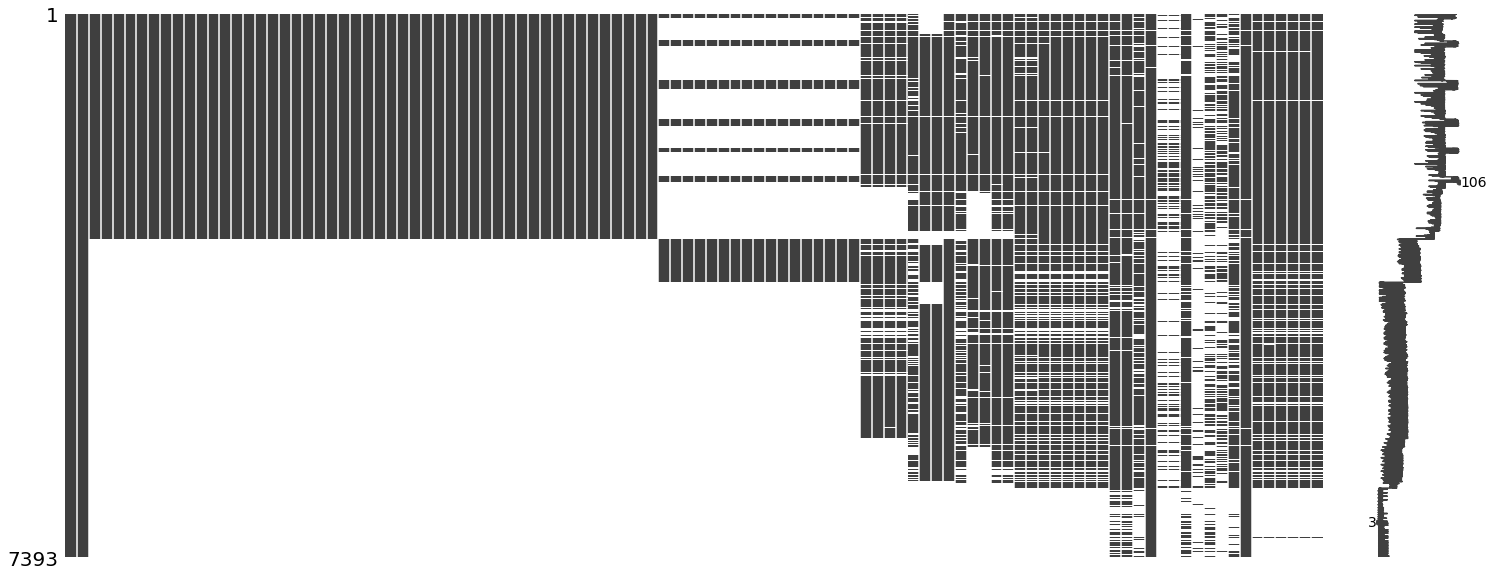

In [2252]:
# Assess missingness from 1990 onwards
miss.matrix(terrordb_yr_90)

In [2253]:
terrordb_yr_90.columns

Index(['year', 'ctry_std', 'num_yr', 'num_Q1', 'num_Q2', 'num_Q3', 'num_Q4',
       'crit1', 'crit2', 'crit3',
       ...
       'Unemployment, total (% of total labor force) (national estimate)',
       'Net investment in nonfinancial assets (% of GDP)',
       'Personal remittances, received (% of GDP)', 'Source_WB',
       'v2x_polyarchy', 'v2x_libdem', 'v2x_partipdem', 'v2x_delibdem',
       'v2x_egaldem', 'Source_VDem'],
      dtype='object', length=106)

#### It is safe to assume that non-inclusion in GTD for 1990 onwards means that there is no terror incident in the country for the year. So we can assign all GTD indicators as 0.

In [2254]:
for i in ['num_yr', 'num_Q1', 'num_Q2', 'num_Q3', 'num_Q4',
       'crit1', 'crit2', 'crit3', 'multiple', 'success', 'suicide',
       'individual', 'nperps', 'nperpcap', 'claimed', 'nkill', 'nkillter',
       'nkillciv', 'nwound', 'nwoundte', 'nwoundciv', 'ishostkid', 'nhostkid',
       'ransom', 'ransompaid', 'INT_LOG', 'Armed Assault', 'Assassination',
       'Bombing/Explosion', 'Facility/Infrastructure Attack', 'Hijacking',
       'Unarmed Assault', 'Hostage Taking', 'Business', 'Military', 'Police',
       'Private Citizens & Property', 'Religious Figures/Institutions',
       'Terrorists/Non-State Militia', 'Transportation', 'Utilities',
       'Government', 'Targ_Others', 'Explosives', 'Firearms', 'Incendiary',
       'Weap_Others', 'Source_GTD']:
    terrordb_yr_90[i] = np.where((np.isnan(terrordb_yr_90["Source_GTD"])), 0, terrordb_yr_90[i])

#### Check that all countries are accounted for for the entirety of the coverage period (1985-2018).

In [2256]:
temp = pd.DataFrame(terrordb_yr_90["ctry_std"].value_counts(ascending=False))
temp[temp["ctry_std"]<34] #There must be 34 data points per country corresponding to each of the years from 1985 to 2018

ctry_std
Guadeloupe                        4
Martinique                        4
Western Sahara                    4
French Guiana                     2
Wallis and Futuna Islands         1

In [2257]:
terrordb_yr_90[terrordb_yr_90["ctry_std"]=="Guadeloupe"]

year    ctry_std  num_yr  num_Q1  num_Q2  num_Q3  num_Q4  crit1  crit2  \
824   1985  Guadeloupe     9.0     9.0     0.0     0.0     0.0    9.0    9.0   
896   1986  Guadeloupe     1.0     0.0     0.0     0.0     1.0    1.0    1.0   
1040  1988  Guadeloupe     4.0     3.0     1.0     0.0     0.0    4.0    4.0   
1298  1991  Guadeloupe     1.0     0.0     0.0     0.0     1.0    1.0    1.0   

      crit3  multiple  success  suicide  individual  nperps  nperpcap  \
824     9.0       0.0      8.0      0.0         0.0     1.0       0.0   
896     1.0       0.0      1.0      0.0         0.0     0.0       0.0   
1040    4.0       3.0      4.0      0.0         0.0     0.0       0.0   
1298    1.0       0.0      1.0      0.0         0.0     0.0       0.0   

      claimed  nkill  nkillter  nkillciv  nwound  nwoundte  nwoundciv  \
824       0.0    2.0       0.0       0.0    18.0       0.0        0.0   
896       0.0    0.0       0.0       0.0     0.0       0.0        0.0   
1040      0.0    0.0       0.0       0.0     0.0       0.0        0.0   
1298      0.0    1.0       0.0       0.0     0.0       0.0        0.0   

      ishostkid  nhostkid  ransom  ransompaid  INT_LOG  Armed Assault  \
824         0.0       0.0     0.0         0.0      2.0            1.0   
896         0.0       0.0     0.0         0.0      0.0            0.0   
1040        0.0       0.0     0.0         0.0      0.0            0.0   
1298        0.0       0.0     0.0         0.0      0.0            0.0   

      Assassination  Bombing/Explosion  Facility/Infrastructure Attack  \
824             2.0                6.0                             0.0   
896             0.0                1.0                             0.0   
1040            0.0                4.0                             0.0   
1298            1.0                0.0                             0.0   

      Hijacking  Unarmed Assault  Hostage Taking  Business  Military  Police  \
824         0.0              0.0             0.0       4.0       0.0     2.0   
896         0.0              0.0             0.0       0.0       0.0     0.0   
1040        0.0              0.0             0.0       1.0       0.0     0.0   
1298        0.0              0.0             0.0       0.0       0.0     0.0   

      Private Citizens & Property  Religious Figures/Institutions  \
824                           0.0                             0.0   
896                           1.0                             0.0   
1040                          3.0                             0.0   
1298                          0.0                             0.0   

      Terrorists/Non-State Militia  Transportation  Utilities  Government  \
824                            0.0             0.0        0.0         2.0   
896                            0.0             0.0        0.0         0.0   
1040                           0.0             0.0        0.0         0.0   
1298                           0.0             0.0        0.0         1.0   

      Targ_Others  Explosives  Firearms  Incendiary  Weap_Others  Source_GTD  \
824           0.0         6.0       1.0         1.0          0.0         1.0   
896           0.0         0.0       0.0         0.0          0.0         1.0   
1040          0.0         4.0       0.0         0.0          0.0         1.0   
1298          0.0         0.0       1.0         0.0          0.0         1.0   

      christianity_pct  judaism_pct  islam_pct  buddhism_pct  zorogenpct  \
824                NaN          NaN        NaN           NaN         NaN   
896                NaN          NaN        NaN           NaN         NaN   
1040               NaN          NaN        NaN           NaN         NaN   
1298               NaN          NaN        NaN           NaN         NaN   

      hindgenpct  sikhgenpct  shntgenpct  bahgenpct  taogenpct  jaingenpct  \
824          NaN         NaN         NaN        NaN        NaN         NaN   
896          NaN         NaN         NaN        NaN        NaN   

A cursory look at Guadeloupe explains the lack of data points -- it exists only in the GTD. Other data sources do not have it in their database. Thus, it will be difficult to predict this country. Given its few data poits, we can safely drop it and our data won't be affected significantly.

In [2258]:
temp[temp["ctry_std"]<34].index

Index(['Guadeloupe', 'Martinique', 'Western Sahara', 'French Guiana',
       'Wallis and Futuna Islands'],
      dtype='object')

In [2259]:
terrordb_yr_90["drop_ctry"] = 0
for i in temp[temp["ctry_std"]<34].index:
    terrordb_yr_90["drop_ctry"] = terrordb_yr_90["drop_ctry"]+1*(terrordb_yr_90["ctry_std"]==i)

In [2260]:
terrordb_yr_90[terrordb_yr_90["drop_ctry"]==1]

year                   ctry_std  num_yr  num_Q1  num_Q2  num_Q3  num_Q4  \
824   1985                 Guadeloupe     9.0     9.0     0.0     0.0     0.0   
896   1986                 Guadeloupe     1.0     0.0     0.0     0.0     1.0   
944   1986             Western Sahara     1.0     0.0     0.0     1.0     0.0   
985   1987                 Martinique     1.0     0.0     0.0     1.0     0.0   
1040  1988                 Guadeloupe     4.0     3.0     1.0     0.0     0.0   
1056  1988                 Martinique     1.0     0.0     1.0     0.0     0.0   
1298  1991                 Guadeloupe     1.0     0.0     0.0     0.0     1.0   
1322  1991                 Martinique     1.0     0.0     0.0     0.0     1.0   
1456  1992                 Martinique     1.0     1.0     0.0     0.0     0.0   
1508  1992             Western Sahara     1.0     0.0     0.0     1.0     0.0   
1710  1994  Wallis and Futuna Islands     1.0     0.0     1.0     0.0     0.0   
1877  1996              French Guiana     2.0     0.0     0.0     0.0     2.0   
2000  1997              French Guiana     2.0     0.0     1.0     1.0     0.0   
2843  2007             Western Sahara     1.0     0.0     0.0     1.0     0.0   
3866  2018             Western Sahara     2.0     0.0     1.0     1.0     0.0   

      crit1  crit2  crit3  multiple  success  suicide  individual  nperps  \
824     9.0    9.0    9.0       0.0      8.0      0.0         0.0     1.0   
896     1.0    1.0    1.0       0.0      1.0      0.0         0.0     0.0   
944     1.0    1.0    1.0       0.0      1.0      0.0         0.0     0.0   
985     1.0    1.0    1.0       0.0      1.0      0.0         0.0     0.0   
1040    4.0    4.0    4.0       3.0      4.0      0.0         0.0     0.0   
1056    1.0    1.0    1.0       0.0      1.0      0.0         0.0     8.0   
1298    1.0    1.0    1.0       0.0      1.0      0.0         0.0     0.0   
1322    1.0    1.0    1.0       0.0      1.0      0.0         0.0     0.0   
1456    1.0    1.0    1.0       0.0      1.0      0.0         0.0     0.0   
1508    1.0    1.0    1.0       0.0      1.0      0.0         0.0     0.0   
1710    1.0    1.0    1.0       0.0      1.0      0.0         0.0     0.0   
1877    2.0    2.0    2.0       0.0      2.0      0.0         0.0     0.0   
2000    2.0    2.0    2.0       0.0      1.0      0.0         0.0     0.0   
2843    1.0    1.0    1.0       0.0      1.0      0.0         0.0     5.0   
3866    2.0    2.0    2.0       0.0      1.0      0.0         0.0     0.0   

      nperpcap  claimed  nkill  nkillter  nkillciv  nwound  nwoundte  \
824        0.0      0.0    2.0       0.0       0.0    18.0       0.0   
896        0.0      0.0    0.0       0.0       0.0     0.0       0.0   
944        0.0      0.0    1.0       0.0       0.0     0.0       0.0   
985        0.0      0.0    0.0       0.0       0.0     0.0       0.0   
1040       0.0      0.0    0.0       0.0       0.0     0.0       0.0   
1056       0.0      0.0    0.0       0.0       0.0     1.0       0.0   
1298       0.0      0.0    1.0       0.0       0.0     0.0       0.0   
1322       0.0      0.0    0.0       0.0       0.0     0.0       0.0   
1456       0.0      0.0    0.0       0.0       0.0     0.0       0.0   
1508       0.0      0.0    0.0       0.0       0.0     1.0       0.0   
1710       0.0      0.0    0.0       0.0       0.0     0.0       0.0   
1877       0.0      0.0    0.0       0.0       0.0     1.0       0.0   
2000       0.0      0.0    0.0       0.0       0.0    12.0       0.0   
2843       0.0      0.0    0.0       0.0       0.0     3.0       0.0   
3866       0.0      0.0    0.0       0.0       0.0     0.0       0.0   

      nwoundciv  ishostkid  nhostkid  ransom  ransompaid  INT_LOG  \
824         0.0        0.0       0.0     0.0         0.0      2.0   
896         0.0        0.0       0.0     0.0         0.0      0.0   
944         0.0        0.0       0.0     0.0         0.0      0.0   
985         0.0        0.0       0.0     0.0   

In [2261]:
# Retain only countries with complete 1985-2018 data
terrordb_yr_90=terrordb_yr_90[terrordb_yr_90["drop_ctry"]==0]

In [2262]:
# Remove temporary columns
terrordb_yr_90=terrordb_yr_90.drop(['drop_ctry'],axis=1)

In [2263]:
terrordb_yr_90=terrordb_yr_90.sort_values(['ctry_std', 'year'])

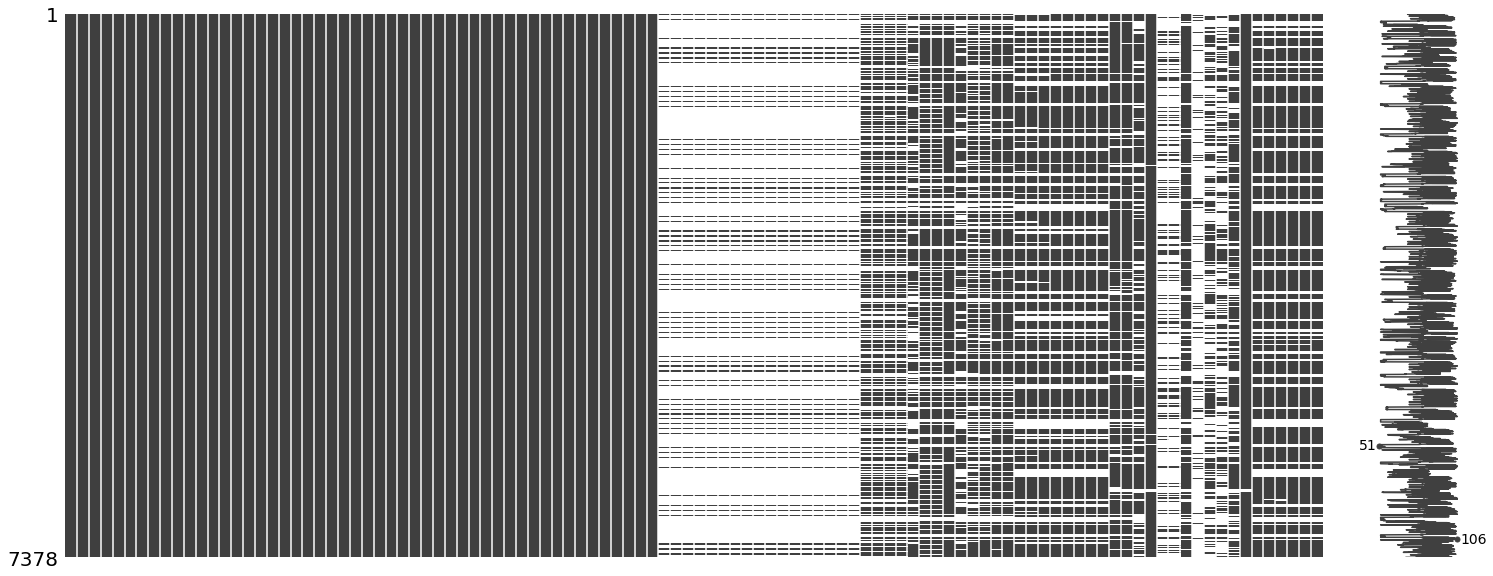

In [2264]:
# Assess missingness
miss.matrix(terrordb_yr_90)

# Data Pre-processing

In [2735]:
terrordb_yr_90_gtd_lag0 = terrordb_yr_90.filter(terrordb_yr_90.columns[:49]).sort_values(["ctry_std","year"])

In [2736]:
terrordb_yr_90_gtd_lag0.columns

Index(['year', 'ctry_std', 'num_yr', 'num_Q1', 'num_Q2', 'num_Q3', 'num_Q4',
       'crit1', 'crit2', 'crit3', 'multiple', 'success', 'suicide',
       'individual', 'nperps', 'nperpcap', 'claimed', 'nkill', 'nkillter',
       'nkillciv', 'nwound', 'nwoundte', 'nwoundciv', 'ishostkid', 'nhostkid',
       'ransom', 'ransompaid', 'INT_LOG', 'Armed Assault', 'Assassination',
       'Bombing/Explosion', 'Facility/Infrastructure Attack', 'Hijacking',
       'Unarmed Assault', 'Hostage Taking', 'Business', 'Military', 'Police',
       'Private Citizens & Property', 'Religious Figures/Institutions',
       'Terrorists/Non-State Militia', 'Transportation', 'Utilities',
       'Government', 'Targ_Others', 'Explosives', 'Firearms', 'Incendiary',
       'Weap_Others'],
      dtype='object')

In [2737]:
terrordb_yr_90_gtd_lag1 = terrordb_yr_90_gtd_lag0.copy()

# add lags
for i in terrordb_yr_90_gtd_lag1.columns[2:]:
    terrordb_yr_90_gtd_lag1[i] = terrordb_yr_90_gtd_lag1.groupby('ctry_std')[i].shift(1)
    
terrordb_yr_90_gtd_lag1.columns=terrordb_yr_90_gtd_lag1.columns+"_lag1"

In [2738]:
terrordb_yr_90_gtd_lag3 = terrordb_yr_90_gtd_lag0.copy()

# add lags
for i in terrordb_yr_90_gtd_lag3.columns[2:]:
    terrordb_yr_90_gtd_lag3[i] = terrordb_yr_90_gtd_lag3.groupby('ctry_std')[i].shift(3)
        
terrordb_yr_90_gtd_lag3.columns=terrordb_yr_90_gtd_lag3.columns+"_lag3"

In [2739]:
terrordb_yr_90_gtd_lag5 = terrordb_yr_90_gtd_lag0.copy()

# add lags
for i in terrordb_yr_90_gtd_lag5.columns[2:]:
    terrordb_yr_90_gtd_lag5[i] = terrordb_yr_90_gtd_lag5.groupby('ctry_std')[i].shift(5)
            
terrordb_yr_90_gtd_lag5.columns=terrordb_yr_90_gtd_lag5.columns+"_lag5"

# Predict Number of Terrorism Incidents based on Macro Indicators

In [2828]:
macro_lag0 = terrordb_yr_90.drop(terrordb_yr_90.columns[3:50],axis=1)

In [2829]:
macro_lag0 = macro_lag0.drop(["Source_WorldReligionsProject","Source_HarvardHumRights",
                             "Source_OurWorldinData","Source_Polity",'Source_VDem','Source_WB'],axis=1)

In [2830]:
macro_lag0.columns

Index(['year', 'ctry_std', 'num_yr', 'christianity_pct', 'judaism_pct',
       'islam_pct', 'buddhism_pct', 'zorogenpct', 'hindgenpct', 'sikhgenpct',
       'shntgenpct', 'bahgenpct', 'taogenpct', 'jaingenpct', 'confgenpct',
       'syncgenpct', 'anmgenpct', 'nonreligpct', 'othrgenpct', 'DISAP', 'KILL',
       'POLPRIS', 'TORT', 'Amnesty', 'killing_low', 'killing_present',
       'Military expenditure (% of GDP)',
       'Military expenditure per capita, current USD (OWID based on COW and SIPRI)',
       'Military personnel (COW (2017))',
       'Terrain Ruggedness Index 100m (Nunn and Puga 2012)', 'democ', 'autoc',
       'polity2', 'durable', 'interruption_dummy', 'interregnum_dummy',
       'transition_dummy', 'GDP per capita (constant 2010 US$)',
       'GDP growth (annual %)', 'Inflation, consumer prices (annual %)',
       'Population, total',
       'Poverty headcount ratio at $1.90 a day (2011 PPP) (% of population)',
       'Inequality (Gini index)', 'Oil rents (% of GDP)',
  

In [2831]:
macro_lag0=macro_lag0.sort_values(["ctry_std","year"])

In [2832]:
macro_lag0

year     ctry_std  num_yr  christianity_pct  judaism_pct  islam_pct  \
4167  1985  Afghanistan     0.0            0.0009          0.0     1.9422   
5948  1986  Afghanistan     0.0               NaN          NaN        NaN   
947   1987  Afghanistan     1.0               NaN          NaN        NaN   
1016  1988  Afghanistan    11.0               NaN          NaN        NaN   
1091  1989  Afghanistan    10.0               NaN          NaN        NaN   
...    ...          ...     ...               ...          ...        ...   
3449  2014     Zimbabwe     1.0               NaN          NaN        NaN   
8470  2015     Zimbabwe     0.0               NaN          NaN        NaN   
8557  2016     Zimbabwe     0.0               NaN          NaN        NaN   
3759  2017     Zimbabwe     3.0               NaN          NaN        NaN   
3868  2018     Zimbabwe     2.0               NaN          NaN        NaN   

      buddhism_pct  zorogenpct  hindgenpct  sikhgenpct  shntgenpct  bahgenpct  \
4167        0.0004      0.0067      0.0055      0.0002         0.0     0.0006   
5948           NaN         NaN         NaN         NaN         NaN        NaN   
947            NaN         NaN         NaN         NaN         NaN        NaN   
1016           NaN         NaN         NaN         NaN         NaN        NaN   
1091           NaN         NaN         NaN         NaN         NaN        NaN   
...            ...         ...         ...         ...         ...        ...   
3449           NaN         NaN         NaN         NaN         NaN        NaN   
8470           NaN         NaN         NaN         NaN         NaN        NaN   
8557           NaN         NaN         NaN         NaN         NaN        NaN   
3759           NaN         NaN         NaN         NaN         NaN        NaN   
3868           NaN         NaN         NaN         NaN         NaN        NaN   

      taogenpct  jaingenpct  confgenpct  syncgenpct  anmgenpct  nonreligpct  \
4167        0.0         0.0         0.0         0.0     0.0003       0.0057   
5948        NaN         NaN         NaN         NaN        NaN          NaN   
947         NaN         NaN         NaN         NaN        NaN          NaN   
1016        NaN         NaN         NaN         NaN        NaN          NaN   
1091        NaN         NaN         NaN         NaN        NaN          NaN   
...         ...         ...         ...         ...        ...          ...   
3449        NaN         NaN         NaN         NaN        NaN          NaN   
8470        NaN         NaN         NaN         NaN        NaN          NaN   
8557        NaN         NaN         NaN         NaN        NaN          NaN   
3759        NaN         NaN         NaN         NaN        NaN          NaN   
3868        NaN         NaN         NaN         NaN        NaN          NaN   

      othrgenpct  DISAP  KILL  POLPRIS  TORT  Amnesty  killing_low  \
4167      0.0092    0.0   0.0      0.0   0.0      5.0          NaN   
5948         NaN    0.0   0.0      0.0   0.0      5.0          NaN   
947          NaN    0.0   0.0      0.0   0.0      4.0          NaN   
1016         NaN    0.0   0.0      0.0   0.0      4.0          NaN   
1091         NaN    0.0   0.0      0.0   0.0      4.0          0.0   
...          ...    ...   ...      ...   ...      ...          ...   
3449         NaN    NaN   NaN      NaN   NaN      3.0          0.0   
8470         NaN    NaN   NaN      NaN   NaN      3.0          0.0   
8557         NaN    NaN   NaN      NaN   NaN      3.0          0.0   
3759         NaN    NaN   NaN      NaN   NaN      3.0          0.0   
3868         NaN    NaN   NaN      NaN   NaN      NaN          NaN   

      killing_present  Military expenditure (% of GDP)  \
4167              NaN                              NaN   
5948              NaN                              NaN   
947               NaN                              NaN   
1016              NaN                              NaN   
1091              0.0       

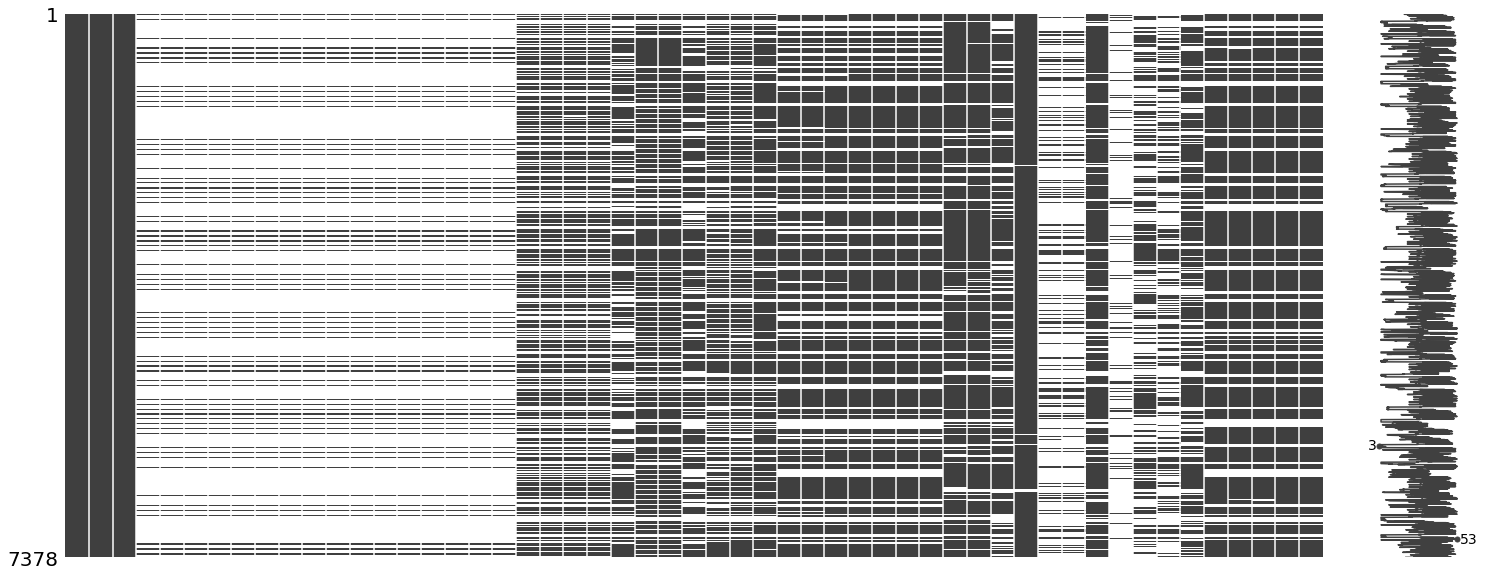

In [2833]:
#Assess missingness
miss.matrix(macro_lag0)

Looks like our data is distributed across countries. Only the frequency is an issue.

In [2834]:
macro_lag0_interp = macro_lag0.groupby("ctry_std").apply(lambda group: group.interpolate(method="linear"))

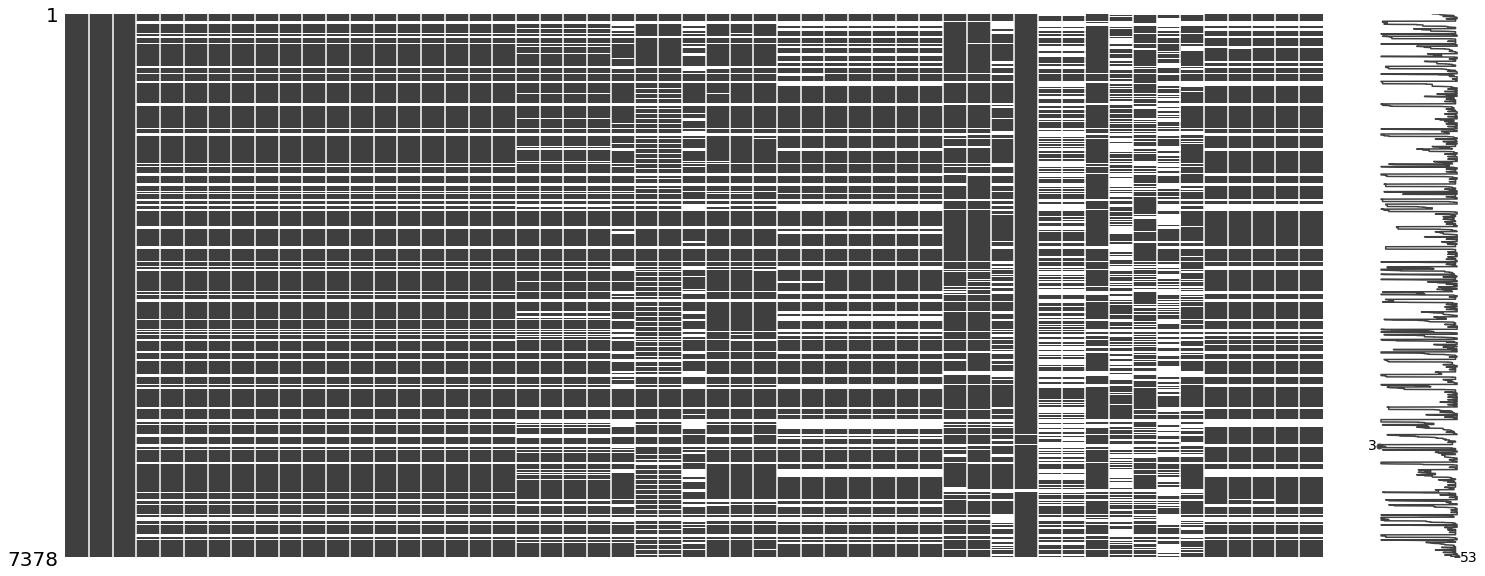

In [2835]:
#Assess missingness
miss.matrix(macro_lag0_interp)

In [2836]:
macro_lag1_interp = macro_lag0_interp.copy()

# add lags
for i in macro_lag1_interp.columns[2:]:
    macro_lag1_interp[i] = macro_lag1_interp.groupby('ctry_std')[i].shift(1)
    
macro_lag1_interp.columns=macro_lag1_interp.columns+"_lag1"

In [2837]:
dat_macro1 = pd.concat([macro_lag0.filter(macro_lag0.columns[:3]),
                      macro_lag1_interp.filter(macro_lag1_interp_nonull.columns[3:])], axis=1)

In [2838]:
dat_macro1 = dat_macro1[dat_macro1["year"]>=1990]

In [2839]:
dat_macro1["isnull"] = dat_macro1.isna().sum(axis=1)

In [2840]:
dat_macro1_nonull = dat_macro1[dat_macro1["isnull"]==0]

In [2841]:
dat_macro1_nonull = dat_macro1_nonull.drop(columns=['isnull'])

In [2842]:
dat = dat_macro1_nonull.drop(columns=['year','ctry_std'])

In [2843]:
# Split into training and test data
y = dat[['num_yr']]
X = dat.drop(columns=['num_yr'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

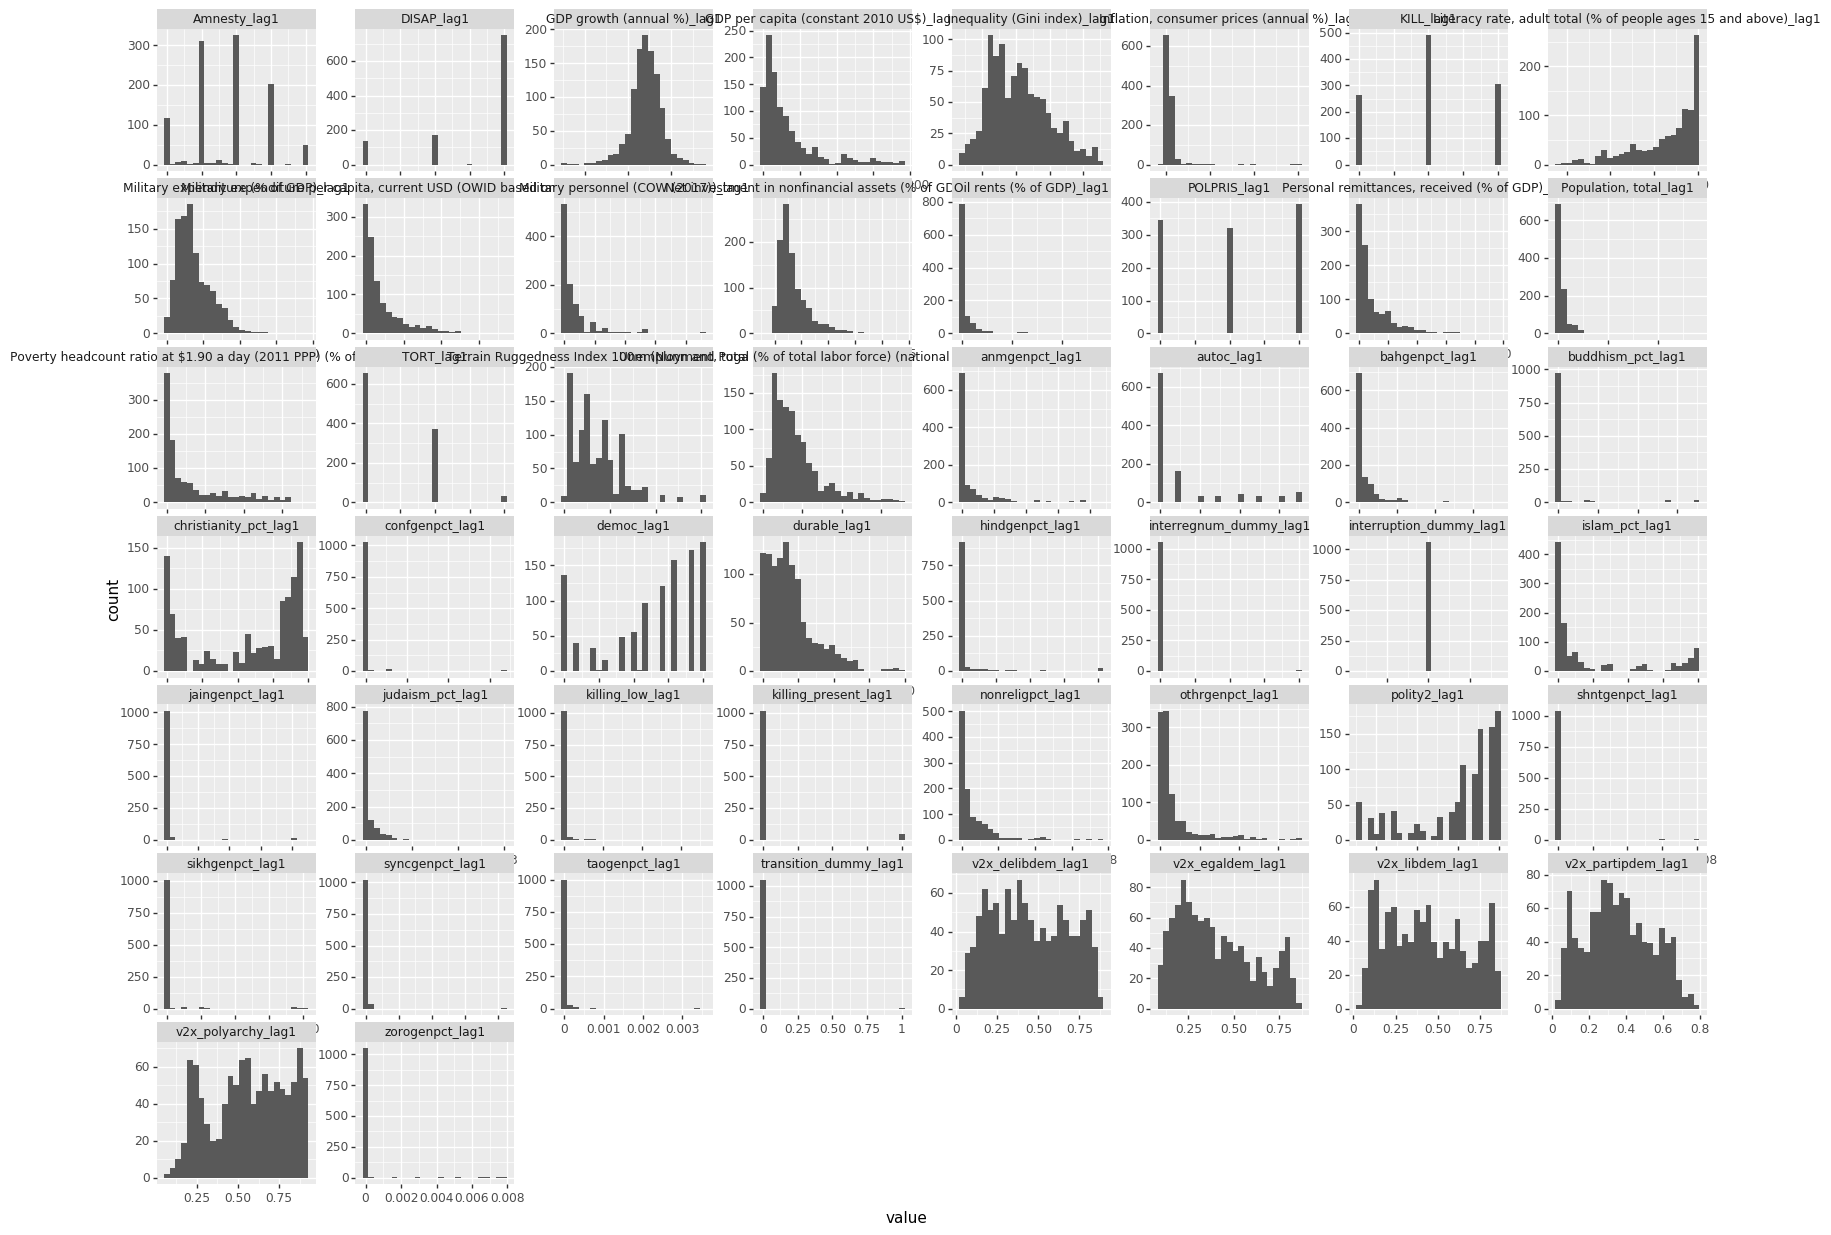

<ggplot: (-9223371875658765684)>

In [2844]:
# Plot the continuous variables 
d = train_X.select_dtypes(include=[np.int64,np.float64]).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(20,15),
          subplots_adjust={'wspace':0.25})
)

In [2845]:
np.abs(train_X.corr())

christianity_pct_lag1  \
christianity_pct_lag1                                            1.000000   
judaism_pct_lag1                                                 0.177617   
islam_pct_lag1                                                   0.784124   
buddhism_pct_lag1                                                0.343649   
zorogenpct_lag1                                                  0.147526   
hindgenpct_lag1                                                  0.290277   
sikhgenpct_lag1                                                  0.209369   
shntgenpct_lag1                                                  0.047322   
bahgenpct_lag1                                                   0.101389   
taogenpct_lag1                                                   0.022630   
jaingenpct_lag1                                                  0.199394   
confgenpct_lag1                                                  0.103634   
syncgenpct_lag1                                                  0.112140   
anmgenpct_lag1                                                   0.023654   
nonreligpct_lag1                                                 0.058868   
othrgenpct_lag1                                                  0.109544   
DISAP_lag1                                                       0.261203   
KILL_lag1                                                        0.273114   
POLPRIS_lag1                                                     0.432880   
TORT_lag1                                                        0.218206   
Amnesty_lag1                                                     0.297197   
killing_low_lag1                                                 0.024459   
killing_present_lag1                                             0.053496   
Military expenditure (% of GDP)_lag1                             0.295997   
Military expenditure per capita, current USD (O...               0.066649   
Military personnel (COW (2017))_lag1                             0.403855   
Terrain Ruggedness Index 100m (Nunn and Puga 20...               0.064532   
democ_lag1                                                       0.393626   
autoc_lag1                                                       0.427576   
polity2_lag1                                                     0.420262   
durable_lag1                                                     0.092100   
interruption_dummy_lag1                                               NaN   
interregnum_dummy_lag1                                           0.044024   
transition_dummy_lag1                                            0.049590   
GDP per capita (constant 2010 US$)_lag1                          0.219454   
GDP growth (annual %)_lag1                                       0.111406   
Inflation, consumer prices (annual %)_lag1                       0.095723   
Population, total_lag1                                           0.287808   
Poverty headcount ratio at $1.90 a day (2011 PP...               0.088027   
Inequality (Gini index)_lag1                                     0.434057   
Oil rents (% of GDP)_lag1                                        0.199171   
Literacy rate, adult total (% of people ages 15...               0.289746   
Unemployment, total (% of total labor force) (n...               0.127680   
Net investment in nonfinancial assets (% of GDP...               0.122459   
Personal remittances, received (% of GDP)_lag1                   0.007192   
v2x_polyarchy_lag1                                               0.398876   
v2x_libdem_lag1                                                  0.365187   
v2x_partipdem_lag1                                               0.426128   
v2x_delibdem_lag1                                                0.325937   
v2x_egaldem_lag1                                                 0.334193   

                                                    judaism_pct_lag1  \
christianity_pct_lag1                               

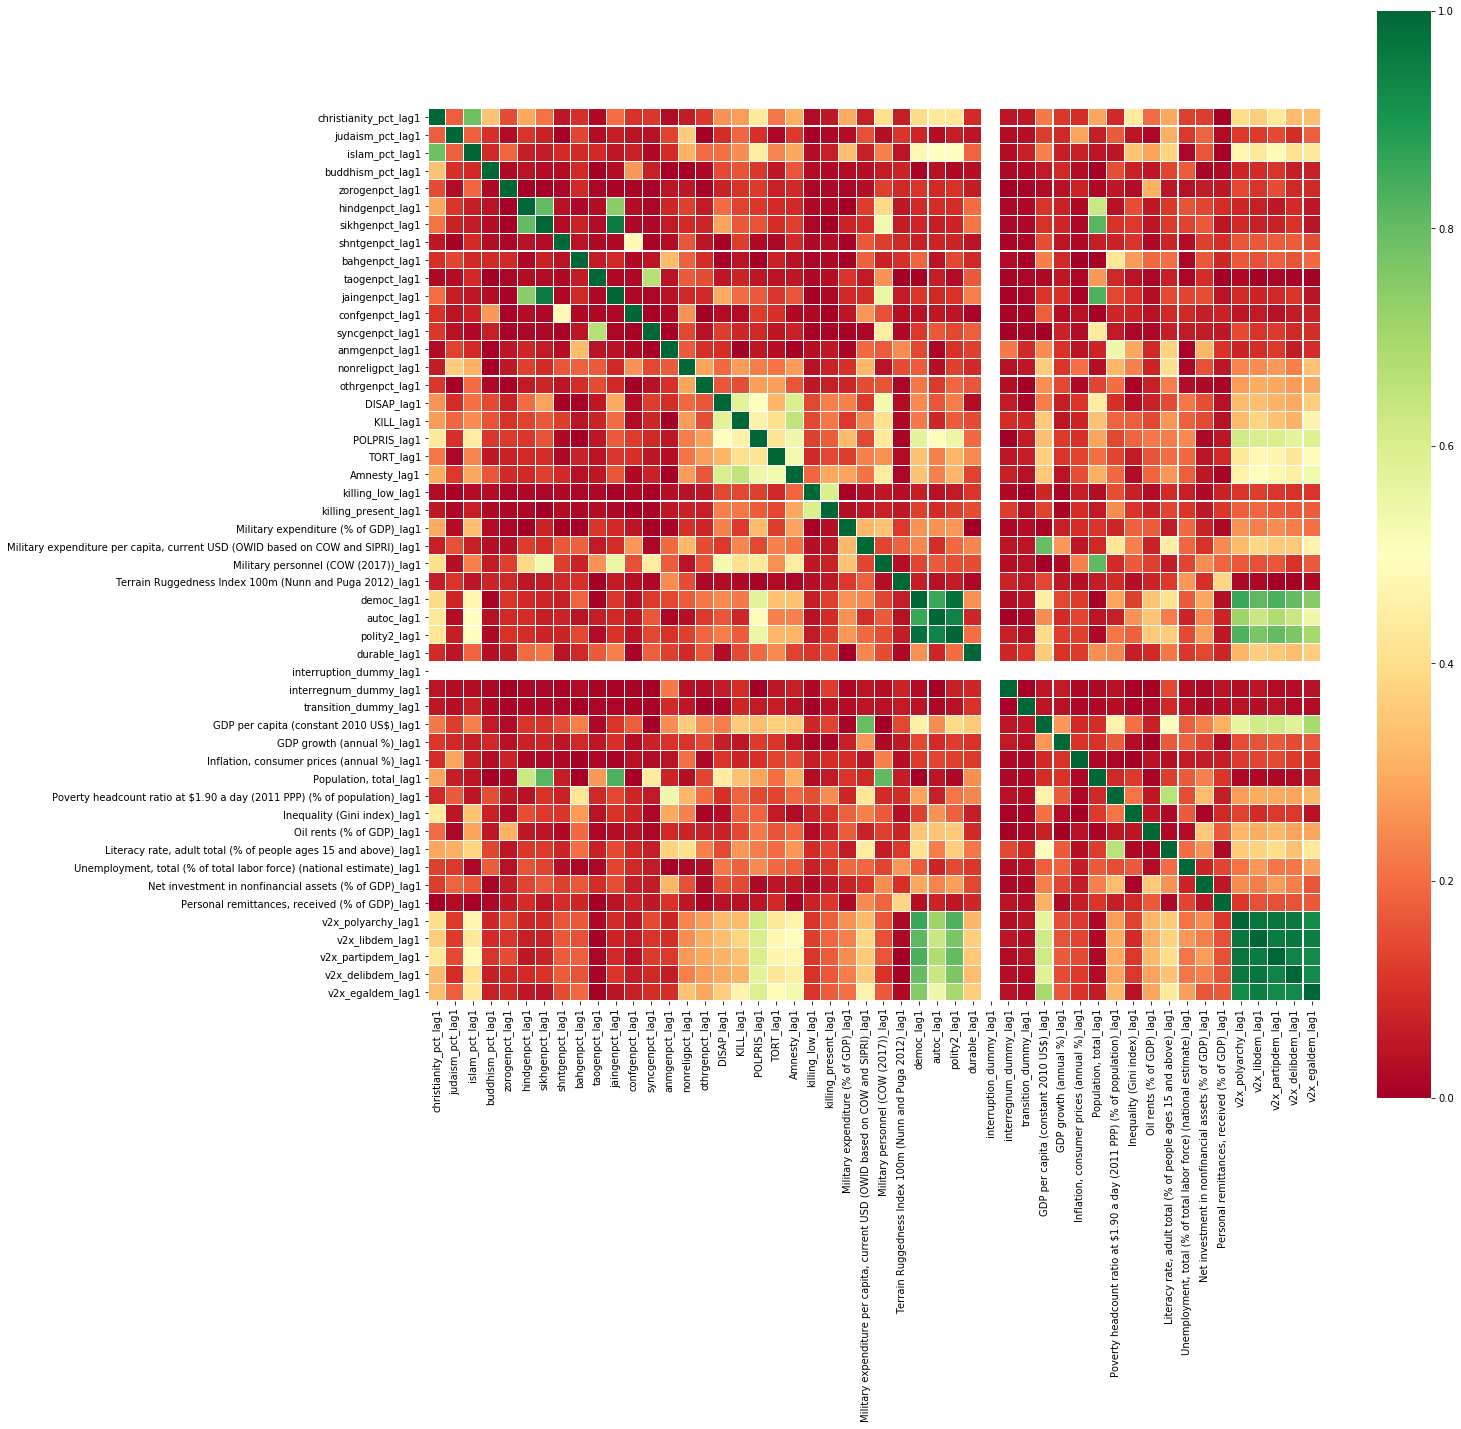

In [2846]:
# Plot heatmap
plt.figure(figsize = (20,20))
sns.heatmap(np.abs(train_X.corr()),cmap="RdYlGn",vmin=0,vmax=1,linewidths=.1,square=True)
plt.show()

In [2847]:
## CROSS VALIDATION
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

In [2848]:
## INITIALIZE PIPELINE
## Pre-process the data
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [2849]:
## SELECT MODELS & TUNING PARAMETERS
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree
    {'model': [DT()],
     'model__max_depth':[2,3,4,5]},
    
    # Random forest
    {'model' : [RF()],
    'model__max_depth':[2,3,4,5],
    'model__n_estimators':[500,1000,1500,2000],
    'model__max_features':[5,8,10,13]}
    
]

In [2850]:
# Combine in a GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='r2',
                      n_jobs=-1)

In [2851]:
# Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model', None)],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'model': [GaussianNB(priors=None,
                                               var_smoothing=1e-09)]},
                         {'model': [KNeighborsClassifier(algorithm='aut...
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          n_est

Rationale behind r2 (vs MSE):

The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

Source: https://scikit-learn.org/dev/modules/model_evaluation.html#r2-score

MSE: Mean Squared Error loss function simple sum of the squared difference between actual and predicted value divided by a number of samples.

https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn

In [2852]:
# Extract best fit score
search.best_score_ 

0.6890855380529104

In [2853]:
# Extract parameters of best model
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=5, max_features=10, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 5,
 'model__max_features': 10,
 'model__n_estimators': 500}

In [2854]:
rf_mod = search.best_estimator_

In [2855]:
# Take in-sample performance
m.r2_score(train_y,rf_mod.predict(train_X))

0.9090197640137181

In [2856]:
m.mean_squared_error(train_y,rf_mod.predict(train_X))

4674.58889186648

In [2857]:
# Take out-of-sample performance
m.r2_score(test_y,rf_mod.predict(test_X))

0.4698256521629105

In [2858]:
m.mean_squared_error(test_y,rf_mod.predict(test_X))

4619.149840856487

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

## Variable Importance

In [2859]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance

In [2860]:
# Permute features to determine importance
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

In [2861]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

variable            vi  \
0                           Oil rents (% of GDP)_lag1  9.860274e-02   
1                                        Amnesty_lag1  9.098580e-02   
2                               christianity_pct_lag1  8.150469e-02   
3                              Population, total_lag1  6.968781e-02   
4                Military personnel (COW (2017))_lag1  6.602187e-02   
5                        Inequality (Gini index)_lag1  5.509335e-02   
6   Military expenditure per capita, current USD (...  3.988456e-02   
7                                      islam_pct_lag1  3.689420e-02   
8                                     sikhgenpct_lag1  3.223843e-02   
9   Net investment in nonfinancial assets (% of GD...  2.403526e-02   
10     Personal remittances, received (% of GDP)_lag1  2.014385e-02   
11                                       durable_lag1  1.758173e-02   
12               Military expenditure (% of GDP)_lag1  1.629190e-02   
13  Literacy rate, adult total (% of people ages 1...  1.428809e-02   
14                                         DISAP_lag1  1.285971e-02   
15  Unemployment, total (% of total labor force) (...  1.135704e-02   
16                                    hindgenpct_lag1  1.122865e-02   
17                                   killing_low_lag1  9.923343e-03   
18                                    othrgenpct_lag1  8.941282e-03   
19  Poverty headcount ratio at $1.90 a day (2011 P...  8.521565e-03   
20                                   nonreligpct_lag1  8.301449e-03   
21                                   v2x_egaldem_lag1  8.190956e-03   
22                         GDP growth (annual %)_lag1  7.194961e-03   
23                                 v2x_partipdem_lag1  7.038464e-03   
24                                         autoc_lag1  6.685609e-03   
25         Inflation, consumer prices (annual %)_lag1  6.334690e-03   
26                                    v2x_libdem_lag1  6.198674e-03   
27                                       POLPRIS_lag1  5.990167e-03   
28            GDP per capita (constant 2010 US$)_lag1  5.964295e-03   
29                                  v2x_delibdem_lag1  5.830288e-03   
30                                  buddhism_pct_lag1  5.672623e-03   
31                                 v2x_polyarchy_lag1  5.546126e-03   
32                                          KILL_lag1  4.852334e-03   
33  Terrain Ruggedness Index 100m (Nunn and Puga 2...  4.537063e-03   
34                               killing_present_lag1  4.042318e-03   
35                                       polity2_lag1  3.328087e-03   
36                                         democ_lag1  2.813413e-03   
37                                     anmgenpct_lag1  2.630121e-03   
38                                     bahgenpct_lag1  2.498265e-03   
39                                    jaingenpct_lag1  2.120754e-03   
40                                   judaism_pct_lag1  1.643110e-03   
41                                    syncgenpct_lag1  1.262122e-03   
42                                    zorogenpct_lag1  6.321956e-04   
43                                    confgenpct_lag1  5.060865e-04   
44                                          TORT_lag1  7.082049e-05   
45                                    shntgenpct_lag1  6.452195e-07   
46                                     taogenpct_lag1  1.861888e-07   
47                              transition_dummy_lag1  0.000000e+00   
48                             interregnum_dummy_lag1  0.000000e+00   
49                            interruption_dummy_lag1  0.000000e+00   

             std           low          high  
0   5.668661e-03  8.726542e-02  1.099401e-01  
1   6.847990e-03  7.728982e-02  1.046818e-01  
2   1.169535e-02  5.811398e-02  1.048954e-01  
3   6.287101e-03  5.711361e-02  8.226201e-02  
4   5.089203e-03  5.584347e-02  7.620028e-02  
5   5.567747e-03  4.395786e-02  6.622884e-02  
6   4.008714e-03  3.186713e-02  4.790199e-02  
7   5.061574e-03  2.677105e-02  4.701735e-02  


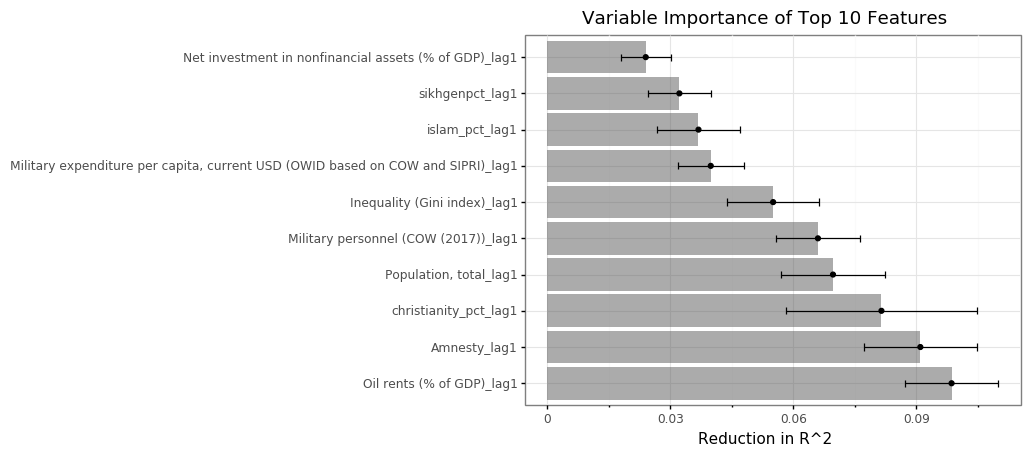

<ggplot: (-9223371876344261768)>

In [2862]:
# Visualize
(
    ggplot(vi_dat[:10],
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[:10].variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in R^2",x="",title="Variable Importance of Top 10 Features")
)

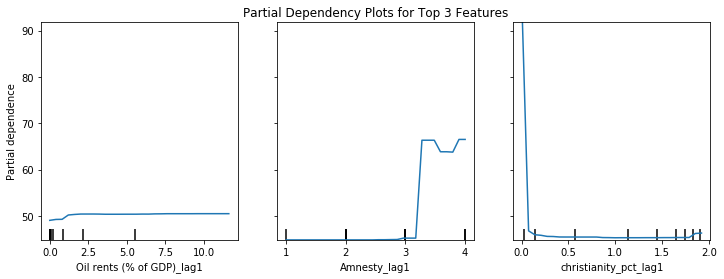

In [2863]:
# Target top 3 most important features
features = vi_dat["variable"][:3]

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Partial Dependency Plots for Top 3 Features")
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=3,
    n_jobs=-1, grid_resolution=30,ax=ax
)

# Model 2.1.2: Macro model - Complete country years; test data is latest

In [2865]:
dat_test = dat_macro1_nonull[dat_macro1_nonull["year"]>=2015].drop(columns=['year','ctry_std'])

In [2866]:
dat_train = dat_macro1_nonull[dat_macro1_nonull["year"]<=2014].drop(columns=['year','ctry_std'])

In [2867]:
len(dat_test)

359

In [2868]:
len(dat_train)

1053

In [2869]:
# Split into training and test data
train_X = dat_train.drop(columns=['num_yr'])
train_y = dat_train[['num_yr']]
test_X = dat_test.drop(columns=['num_yr'])
test_y = dat_test[['num_yr']]

In [2870]:
## CROSS VALIDATION
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

In [2871]:
## INITIALIZE PIPELINE
## Pre-process the data
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [2872]:
## SELECT MODELS & TUNING PARAMETERS
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree
    {'model': [DT()],
     'model__max_depth':[2,3,4,5]},
    
    # Random forest
    {'model' : [RF()],
    'model__max_depth':[2,3,4,5],
    'model__n_estimators':[500,1000,1500,2000],
    'model__max_features':[5,8,10,13]}
    
]

In [2873]:
# Combine in a GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='r2',
                      n_jobs=-1)

In [2874]:
# Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model', None)],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'model': [GaussianNB(priors=None,
                                               var_smoothing=1e-09)]},
                         {'model': [KNeighborsClassifier(algorithm='aut...
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          n_est

Rationale behind r2 (vs MSE):

The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

Source: https://scikit-learn.org/dev/modules/model_evaluation.html#r2-score

MSE: Mean Squared Error loss function simple sum of the squared difference between actual and predicted value divided by a number of samples.

https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn

In [2875]:
# Extract best fit score
search.best_score_ 

0.6984206526240351

In [2876]:
# Extract parameters of best model
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=5, max_features=10, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 5,
 'model__max_features': 10,
 'model__n_estimators': 500}

In [2877]:
rf_mod = search.best_estimator_

In [2878]:
# Take in-sample performance
m.r2_score(train_y,rf_mod.predict(train_X))

0.920078336251849

In [2879]:
m.mean_squared_error(train_y,rf_mod.predict(train_X))

1630.185497371781

In [2880]:
# Take out-of-sample performance
m.r2_score(test_y,rf_mod.predict(test_X))

0.17677561727205482

In [2881]:
m.mean_squared_error(test_y,rf_mod.predict(test_X))

81580.80271386704

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

## Variable Importance

In [2882]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance

In [2883]:
# Permute features to determine importance
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

In [2884]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

variable        vi           std  \
0                Military personnel (COW (2017))_lag1  0.152632  1.838342e-02   
1                              Population, total_lag1  0.094571  9.200851e-03   
2                                     sikhgenpct_lag1  0.092207  1.304239e-02   
3      Personal remittances, received (% of GDP)_lag1  0.077987  1.371683e-02   
4                                          DISAP_lag1  0.057050  1.331626e-02   
5                        Inequality (Gini index)_lag1  0.049858  8.993749e-03   
6                                        Amnesty_lag1  0.041799  4.700354e-03   
7   Unemployment, total (% of total labor force) (...  0.027318  3.512604e-03   
8                               christianity_pct_lag1  0.026479  5.339993e-03   
9   Literacy rate, adult total (% of people ages 1...  0.024658  2.431481e-03   
10                                    hindgenpct_lag1  0.014424  2.082828e-03   
11                                          KILL_lag1  0.013748  3.018221e-03   
12                                     islam_pct_lag1  0.012439  1.805418e-03   
13  Poverty headcount ratio at $1.90 a day (2011 P...  0.012317  3.969973e-03   
14               Military expenditure (% of GDP)_lag1  0.011695  2.765237e-03   
15                          Oil rents (% of GDP)_lag1  0.010068  2.957509e-03   
16                                   nonreligpct_lag1  0.009404  1.888191e-03   
17                                  buddhism_pct_lag1  0.008876  7.025105e-04   
18  Military expenditure per capita, current USD (...  0.008346  3.083378e-03   
19         Inflation, consumer prices (annual %)_lag1  0.008124  9.147977e-04   
20  Net investment in nonfinancial assets (% of GD...  0.008101  1.387768e-03   
21                                   v2x_egaldem_lag1  0.007302  2.122026e-03   
22                                       durable_lag1  0.007211  6.756009e-04   
23  Terrain Ruggedness Index 100m (Nunn and Puga 2...  0.005122  9.904512e-04   
24                                       POLPRIS_lag1  0.004967  1.613545e-03   
25                                  v2x_delibdem_lag1  0.004725  6.414526e-04   
26                                    othrgenpct_lag1  0.004695  9.194365e-04   
27                                 v2x_polyarchy_lag1  0.003748  7.086147e-04   
28                                     bahgenpct_lag1  0.003521  6.758406e-04   
29                                 v2x_partipdem_lag1  0.003414  1.573085e-03   
30                                    v2x_libdem_lag1  0.003306  1.034429e-03   
31                                       polity2_lag1  0.003224  6.594327e-04   
32                                     anmgenpct_lag1  0.003135  7.614206e-04   
33            GDP per capita (constant 2010 US$)_lag1  0.003082  1.067350e-03   
34                                    jaingenpct_lag1  0.002678  8.857784e-04   
35                                    syncgenpct_lag1  0.002300  5.625271e-04   
36                                         democ_lag1  0.001898  4.587849e-04   
37                                    confgenpct_lag1  0.001672  2.031205e-04   
38                         GDP growth (annual %)_lag1  0.001515  5.063394e-04   
39                                         autoc_lag1  0.001290  4.401888e-04   
40                                    zorogenpct_lag1  0.001242  1.784835e-04   
41                                   judaism_pct_lag1  0.000628  2.000326e-04   
42                              transition_dummy_lag1  0.000171  1.367769e-05   
43                                          TORT_lag1  0.000062  6.609491e-05   
44                                   killing_low_lag1  0.000040  7.501582e-06   
45                                     taogenpct_lag1  0.000034  7.322196e-06   
46                               killing_present_lag1  0.000014  5.737718e-06   
47                                    shntgenpct_lag1  0.000005  3.186485e-06   
48                             interregnum_dummy_lag1  0.000002  2.943293e-0

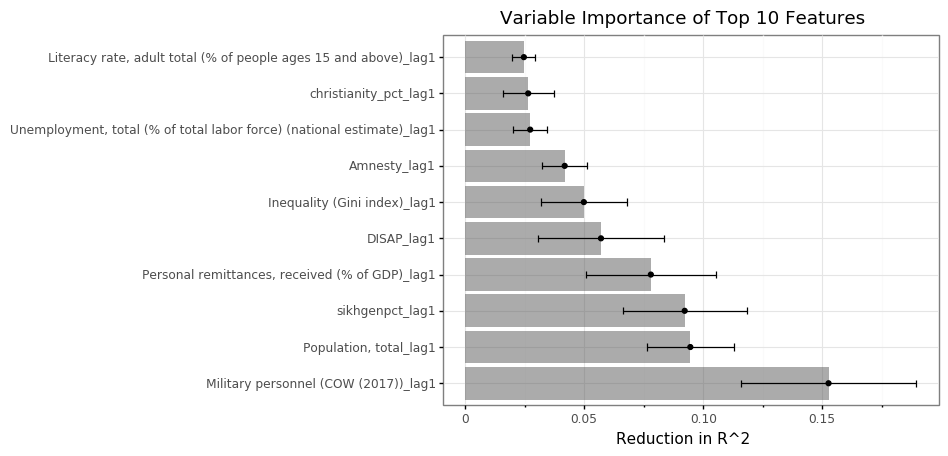

<ggplot: (-9223371876163523632)>

In [2885]:
# Visualize
(
    ggplot(vi_dat[:10],
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[:10].variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in R^2",x="",title="Variable Importance of Top 10 Features")
)

In [2886]:
vi_dat["variable"][:3]

0    Military personnel (COW (2017))_lag1
1                  Population, total_lag1
2                         sikhgenpct_lag1
Name: variable, dtype: object

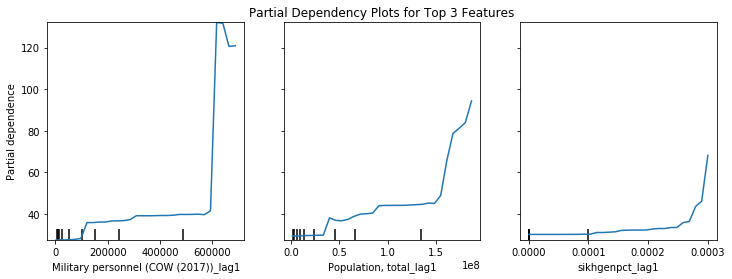

In [2887]:
# Target top 3 most important features
features = vi_dat["variable"][:3]

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Partial Dependency Plots for Top 3 Features")
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=3,
    n_jobs=-1, grid_resolution=30,ax=ax
)

### ICE Plot

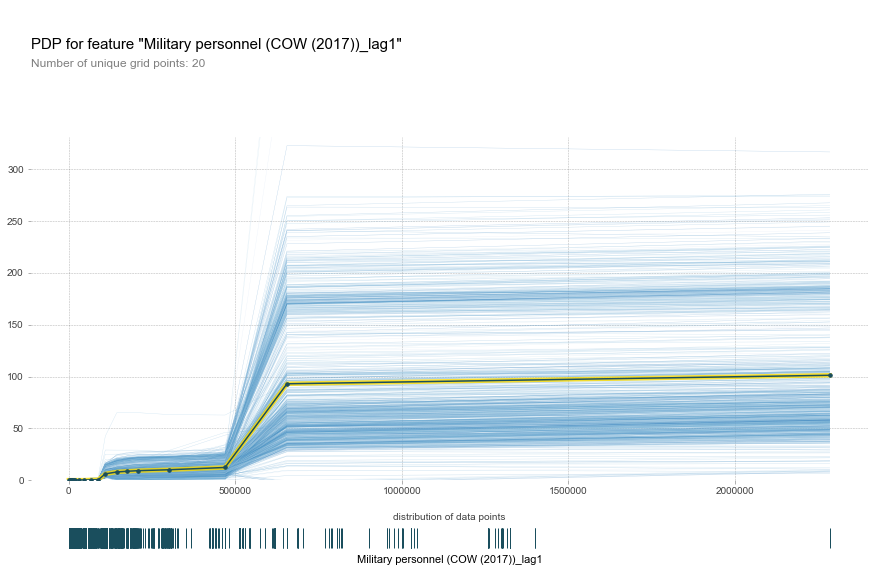

In [2888]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="Military personnel (COW (2017))_lag1",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'Military personnel (COW (2017))_lag1',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

# Model 2.2: Macro model - Minimize null columns

In [2889]:
# Columns with less than 25% missing data
temp = pd.DataFrame(dat_macro1.isna().sum(axis=0).sort_values())

vars2 = temp[temp[0]<len(dat_macro1)/4].index

In [2890]:
dat_macro2 = dat_macro1.filter(vars2)

In [2891]:
dat_macro2

year  num_yr  isnull     ctry_std  Population, total_lag1  \
1174  1990     2.0      11  Afghanistan              11868877.0   
1254  1991    30.0      11  Afghanistan              12412308.0   
1371  1992    36.0      11  Afghanistan              13299017.0   
1511  1993     3.0      11  Afghanistan              14485546.0   
1578  1994     9.0      11  Afghanistan              15816603.0   
...    ...     ...     ...          ...                     ...   
3449  2014     1.0       0     Zimbabwe              13350356.0   
8470  2015     0.0       0     Zimbabwe              13586681.0   
8557  2016     0.0       0     Zimbabwe              13814629.0   
3759  2017     3.0       0     Zimbabwe              14030390.0   
3868  2018     2.0       0     Zimbabwe              14236745.0   

      GDP growth (annual %)_lag1  GDP per capita (constant 2010 US$)_lag1  \
1174                         NaN                                      NaN   
1254                         NaN                                      NaN   
1371                         NaN                                      NaN   
1511                         NaN                                      NaN   
1578                         NaN                                      NaN   
...                          ...                                      ...   
3449                    1.989493                              1225.558112   
8470                    2.376929                              1232.864865   
8557                    1.779873                              1234.103352   
3759                    0.755869                              1224.309922   
3868                    4.704035                              1263.321322   

      Oil rents (% of GDP)_lag1  killing_present_lag1  killing_low_lag1  \
1174                        NaN                   0.0               0.0   
1254                        NaN                   0.0               0.0   
1371                        NaN                   0.0               0.0   
1511                        NaN                   0.0               0.0   
1578                        NaN                   1.0              26.0   
...                         ...                   ...               ...   
3449                        0.0                   0.0               0.0   
8470                        0.0                   0.0               0.0   
8557                        0.0                   0.0               0.0   
3759                        0.0                   0.0               0.0   
3868                        0.0                   0.0               0.0   

      Military personnel (COW (2017))_lag1  \
1174                               55000.0   
1254                               58000.0   
1371                               45000.0   
1511                               45000.0   
1578                               45000.0   
...                                    ...   
3449                               29000.0   
8470                               29000.0   
8557                               29000.0   
3759                               29000.0   
3868                               29000.0   

      Terrain Ruggedness Index 100m (Nunn and Puga 2012)_lag1  \
1174                                              2.518         
1254                                              2.518         
1371                                              2.518         
1511                                              2.518         
1578                                              2.518         
...                                                 ...         
3449                                              1.194         
8470                                              1.194         
8557                                              1.194         
3759                                              1.194         
3868                                              1.194         

      Military expenditure per capita, cu

In [2892]:
dat_macro2.isna().sum(axis=0)

year                                                                                  0
num_yr                                                                                0
isnull                                                                                0
ctry_std                                                                              0
Population, total_lag1                                                               40
GDP growth (annual %)_lag1                                                          583
GDP per capita (constant 2010 US$)_lag1                                             691
Oil rents (% of GDP)_lag1                                                           755
killing_present_lag1                                                                788
killing_low_lag1                                                                    788
Military personnel (COW (2017))_lag1                                                886
Terrain Ruggedness Index 100m (N

But dropping incomplete data points may cause us to drop high incidence areas.

## Pivot to high incidence areas

In [2893]:
highincidence = dat_macro1.groupby("ctry_std").sum().sort_values(by="num_yr", ascending=False).reset_index()[["ctry_std","num_yr"]]

In [2894]:
sum(highincidence["num_yr"]>=200)

59

59 countries with at least 200 terrorism incidents across 1990-2018.

In [2895]:
listhigh = list(highincidence[highincidence["num_yr"]>=200]["ctry_std"])

In [2896]:
dat_macro2b = dat_macro1

In [2897]:
dat_macro2b["high_incidence"] = 0
for i in listhigh:
    dat_macro2b["high_incidence"] = dat_macro2b["high_incidence"]+1*(dat_macro2b["ctry_std"]==i)

In [2898]:
dat_macro2b = dat_macro2b[dat_macro2b["high_incidence"]==1]

In [2899]:
temp = pd.DataFrame(dat_macro2b.isna().sum(axis=0).sort_values()).reset_index()
listcol = list(temp[temp[0]<len(dat_macro2b)/4]["index"])

In [2900]:
dat_macro2b = dat_macro2b.filter(listcol)

In [2901]:
dat_macro2b = dat_macro2b.drop(columns=["isnull","ctry_std","high_incidence"])

In [2902]:
dat_macro2b

year  num_yr  Population, total_lag1  v2x_egaldem_lag1  \
1174  1990     2.0              11868877.0             0.118   
1254  1991    30.0              12412308.0             0.103   
1371  1992    36.0              13299017.0             0.100   
1511  1993     3.0              14485546.0             0.075   
1578  1994     9.0              15816603.0             0.048   
...    ...     ...                     ...               ...   
3448  2014   763.0              25147109.0             0.132   
3548  2015   664.0              25823485.0             0.124   
3656  2016   525.0              26497889.0             0.051   
3757  2017   227.0              27168210.0             0.037   
3867  2018   325.0              27834821.0             0.031   

      v2x_delibdem_lag1  v2x_partipdem_lag1  v2x_polyarchy_lag1  \
1174              0.039               0.038               0.101   
1254              0.041               0.026               0.089   
1371              0.041               0.026               0.091   
1511              0.039               0.036               0.093   
1578              0.029               0.039               0.093   
...                 ...                 ...                 ...   
3448              0.309               0.176               0.345   
3548              0.267               0.161               0.332   
3656              0.046               0.093               0.179   
3757              0.026               0.068               0.112   
3867              0.021               0.063               0.101   

      v2x_libdem_lag1  killing_present_lag1  killing_low_lag1  Amnesty_lag1  \
1174            0.055                   0.0               0.0           4.0   
1254            0.047                   0.0               0.0           4.0   
1371            0.059                   0.0               0.0           4.0   
1511            0.040                   0.0               0.0           4.0   
1578            0.032                   1.0              26.0           4.0   
...               ...                   ...               ...           ...   
3448            0.158                   0.0               0.0           4.0   
3548            0.151                   0.0               0.0           5.0   
3656            0.058                   0.0               0.0           5.0   
3757            0.040                   0.0               0.0           5.0   
3867            0.036                   0.0               0.0           5.0   

      polity2_lag1  Military personnel (COW (2017))_lag1  \
1174          -8.0                               55000.0   
1254          -8.0                               58000.0   
1371          -8.0                               45000.0   
1511           0.0                               45000.0   
1578           0.0                               45000.0   
...            ...                                   ...   
3448           3.0                               67000.0   
3548           0.0                               67000.0   
3656           0.0                               67000.0   
3757           0.0                               67000.0   
3867           0.0                               67000.0   

      interruption_dummy_lag1  interregnum_dummy_lag1  \
1174                      0.0                     0.0   
1254                      0.0                     0.0   
1371                      0.0                     0.0   
1511                      0.0                     1.0   
1578                      0.0                     1.0   
...                       ...                     ...   
3448                      0.0                     0.0   
3548                      0.0                     1.0   
3656                      0.0                     1.0   
3757                      0.0                     1.0   
3867                      0.0                     1.0   

      GDP growth (annual %)_lag1  durable_lag1  transition_dummy_lag1  \
1174

In [2903]:
dat_macro2b_y = dat_macro2b[["num_yr","year"]]

In [2904]:
dat_macro2b_x = dat_macro2b.drop(columns=["num_yr"])

In [2905]:
from sklearn.impute import KNNImputer

In [2906]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")

In [2907]:
dat_macro2b_x_imputed = pd.DataFrame(imputer.fit_transform(dat_macro2b_x))

In [2908]:
dat_macro2b_x_imputed.columns = dat_macro2b_x.columns

In [2909]:
dat_macro2b_x_imputed

year  Population, total_lag1  v2x_egaldem_lag1  v2x_delibdem_lag1  \
0     1990.0              11868877.0             0.118              0.039   
1     1991.0              12412308.0             0.103              0.041   
2     1992.0              13299017.0             0.100              0.041   
3     1993.0              14485546.0             0.075              0.039   
4     1994.0              15816603.0             0.048              0.029   
...      ...                     ...               ...                ...   
1706  2014.0              25147109.0             0.132              0.309   
1707  2015.0              25823485.0             0.124              0.267   
1708  2016.0              26497889.0             0.051              0.046   
1709  2017.0              27168210.0             0.037              0.026   
1710  2018.0              27834821.0             0.031              0.021   

      v2x_partipdem_lag1  v2x_polyarchy_lag1  v2x_libdem_lag1  \
0                  0.038               0.101            0.055   
1                  0.026               0.089            0.047   
2                  0.026               0.091            0.059   
3                  0.036               0.093            0.040   
4                  0.039               0.093            0.032   
...                  ...                 ...              ...   
1706               0.176               0.345            0.158   
1707               0.161               0.332            0.151   
1708               0.093               0.179            0.058   
1709               0.068               0.112            0.040   
1710               0.063               0.101            0.036   

      killing_present_lag1  killing_low_lag1  Amnesty_lag1  polity2_lag1  \
0                      0.0               0.0           4.0          -8.0   
1                      0.0               0.0           4.0          -8.0   
2                      0.0               0.0           4.0          -8.0   
3                      0.0               0.0           4.0           0.0   
4                      1.0              26.0           4.0           0.0   
...                    ...               ...           ...           ...   
1706                   0.0               0.0           4.0           3.0   
1707                   0.0               0.0           5.0           0.0   
1708                   0.0               0.0           5.0           0.0   
1709                   0.0               0.0           5.0           0.0   
1710                   0.0               0.0           5.0           0.0   

      Military personnel (COW (2017))_lag1  interruption_dummy_lag1  \
0                                  55000.0                      0.0   
1                                  58000.0                      0.0   
2                                  45000.0                      0.0   
3                                  45000.0                      0.0   
4                                  45000.0                      0.0   
...                                    ...                      ...   
1706                               67000.0                      0.0   
1707                               67000.0                      0.0   
1708                               67000.0                      0.0   
1709                               67000.0                      0.0   
1710                               67000.0                      0.0   

      interregnum_dummy_lag1  GDP growth (annual %)_lag1  durable_lag1  \
0                        0.0                    7.518978           0.0   
1                        0.0                    0.523358           1.0   
2                        0.0                    4.129508           2.0   
3                        1.0                    5.615809           0.0   
4                        1.0                    3.384425           0.0   
...                      ...                         ...           ...   
1706              

In [2910]:
# Split into training and test data
train_X = dat_macro2b_x_imputed[dat_macro2b_x_imputed["year"]<2012].drop(columns=['year'])
train_y = dat_macro2b_y[dat_macro2b_y["year"]<2012].drop(columns=['year'])
test_X = dat_macro2b_x_imputed[dat_macro2b_x_imputed["year"]>=2012].drop(columns=['year'])
test_y = dat_macro2b_y[dat_macro2b_y["year"]>=2012].drop(columns=['year'])

In [2911]:
## CROSS VALIDATION
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

In [2912]:
## INITIALIZE PIPELINE
## Pre-process the data
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [2913]:
## SELECT MODELS & TUNING PARAMETERS
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree
    {'model': [DT()],
     'model__max_depth':[2,3,4,5]},
    
    # Random forest
    {'model' : [RF()],
    'model__max_depth':[2,3,4,5],
    'model__n_estimators':[500,1000,1500,2000],
    'model__max_features':[5,8,10,13]}
    
]

In [2914]:
# Combine in a GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='r2',
                      n_jobs=-1)

In [2915]:
# Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model', None)],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'model': [GaussianNB(priors=None,
                                               var_smoothing=1e-09)]},
                         {'model': [KNeighborsClassifier(algorithm='aut...
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          n_est

Rationale behind r2 (vs MSE):

The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

Source: https://scikit-learn.org/dev/modules/model_evaluation.html#r2-score

MSE: Mean Squared Error loss function simple sum of the squared difference between actual and predicted value divided by a number of samples.

https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn

In [2916]:
# Extract best fit score
search.best_score_ 

0.5823132000742592

In [2917]:
# Extract parameters of best model
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=5, max_features=10, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 5,
 'model__max_features': 10,
 'model__n_estimators': 1500}

In [2918]:
rf_mod = search.best_estimator_

In [2919]:
# Take in-sample performance
m.r2_score(train_y,rf_mod.predict(train_X))

0.7517907699582962

In [2920]:
m.mean_squared_error(train_y,rf_mod.predict(train_X))

3406.6340233495835

In [2921]:
# Take out-of-sample performance
m.r2_score(test_y,rf_mod.predict(test_X))

0.07688990238338023

In [2922]:
m.mean_squared_error(test_y,rf_mod.predict(test_X))

202228.3385408897

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

## Variable Importance

In [2923]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance

In [2924]:
# Permute features to determine importance
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

In [2925]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

variable            vi  \
0                             interruption_dummy_lag1  1.575346e-01   
1                                        Amnesty_lag1  1.029495e-01   
2                Military personnel (COW (2017))_lag1  8.866583e-02   
3                           Oil rents (% of GDP)_lag1  6.918165e-02   
4                                      islam_pct_lag1  5.340962e-02   
5   Unemployment, total (% of total labor force) (...  4.336698e-02   
6                              Population, total_lag1  3.847801e-02   
7                               christianity_pct_lag1  3.774963e-02   
8                                          DISAP_lag1  2.786671e-02   
9                                   v2x_delibdem_lag1  2.738335e-02   
10                                    sikhgenpct_lag1  2.334315e-02   
11                                       durable_lag1  1.961776e-02   
12                                 v2x_partipdem_lag1  1.903748e-02   
13                                    v2x_libdem_lag1  1.760787e-02   
14                                    jaingenpct_lag1  1.609551e-02   
15                                 v2x_polyarchy_lag1  1.546683e-02   
16                                    hindgenpct_lag1  1.415951e-02   
17         Inflation, consumer prices (annual %)_lag1  1.364464e-02   
18               Military expenditure (% of GDP)_lag1  1.034471e-02   
19                                   v2x_egaldem_lag1  9.269541e-03   
20     Personal remittances, received (% of GDP)_lag1  9.140421e-03   
21                                         democ_lag1  6.858791e-03   
22                                   nonreligpct_lag1  6.708401e-03   
23            GDP per capita (constant 2010 US$)_lag1  6.527143e-03   
24                                       polity2_lag1  6.087416e-03   
25  Military expenditure per capita, current USD (...  5.903611e-03   
26                                     anmgenpct_lag1  5.808955e-03   
27                                         autoc_lag1  5.159846e-03   
28  Terrain Ruggedness Index 100m (Nunn and Puga 2...  4.878637e-03   
29                                    othrgenpct_lag1  4.253865e-03   
30                                  buddhism_pct_lag1  3.594847e-03   
31                                    zorogenpct_lag1  3.578781e-03   
32                                       POLPRIS_lag1  2.759084e-03   
33                                     bahgenpct_lag1  2.598883e-03   
34                         GDP growth (annual %)_lag1  2.595546e-03   
35                                          KILL_lag1  2.346151e-03   
36                                   judaism_pct_lag1  1.773139e-03   
37                                    syncgenpct_lag1  1.201613e-03   
38                                   killing_low_lag1  3.853280e-04   
39                               killing_present_lag1  3.077198e-04   
40                                    confgenpct_lag1  2.096955e-04   
41                                     taogenpct_lag1  1.711037e-04   
42                                          TORT_lag1  1.103614e-04   
43                             interregnum_dummy_lag1  8.112889e-05   
44                                    shntgenpct_lag1  1.281518e-06   
45                              transition_dummy_lag1  3.705223e-08   

             std           low          high  
0   1.288749e-02  1.317597e-01  1.833096e-01  
1   1.091422e-02  8.112103e-02  1.247779e-01  
2   5.687164e-03  7.729150e-02  1.000402e-01  
3   8.677818e-03  5.182601e-02  8.653728e-02  
4   5.766452e-03  4.187671e-02  6.494252e-02  
5   3.039771e-03  3.728744e-02  4.944652e-02  
6   4.410151e-03  2.965771e-02  4.729831e-02  
7   3.389298e-03  3.097103e-02  4.452822e-02  
8   2.721404e-03  2.242391e-02  3.330952e-02  
9   4.864538e-03  1.765427e-02  3.711242e-02  
10  1.608151e-03  2.012684e-02  2.655945e-02  
11  2.930442e-03  1.375688e-02  2.547865e-02  
12  3.682839e-03  1.167180e-02  2.640315e-02  
13  3.144895e-03  1.131808e-02  2.389766e-02  
14

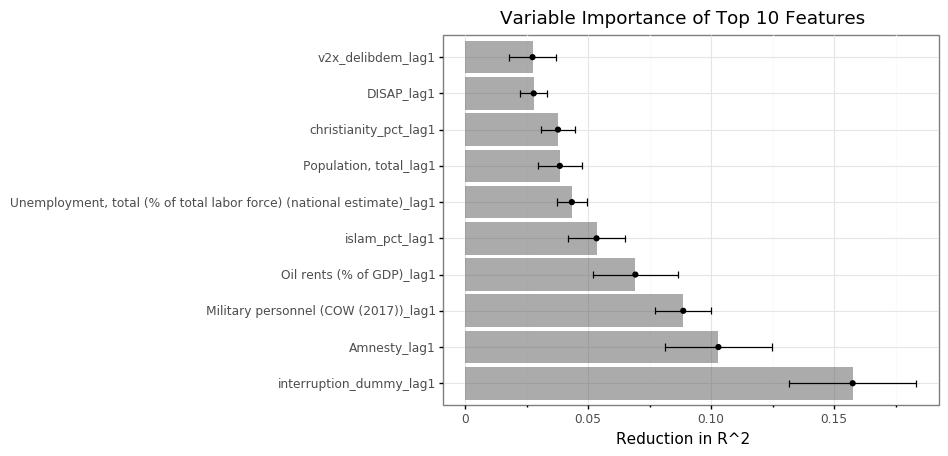

<ggplot: (-9223371876169892288)>

In [2926]:
# Visualize
(
    ggplot(vi_dat[:10],
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[:10].variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in R^2",x="",title="Variable Importance of Top 10 Features")
)

In [2927]:
vi_dat["variable"][:3]

0                 interruption_dummy_lag1
1                            Amnesty_lag1
2    Military personnel (COW (2017))_lag1
Name: variable, dtype: object

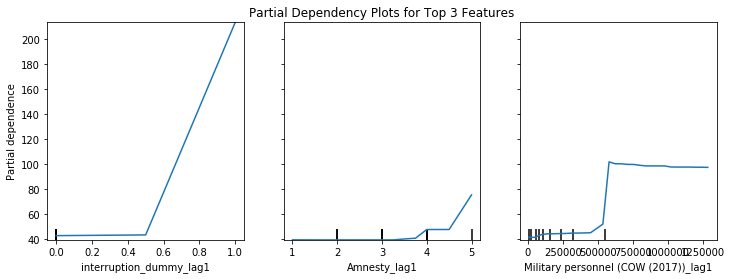

In [2928]:
# Target top 3 most important features
features = vi_dat["variable"][:3]

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Partial Dependency Plots for Top 3 Features")
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=3,
    n_jobs=-1, grid_resolution=30,ax=ax
)

### ICE Plot

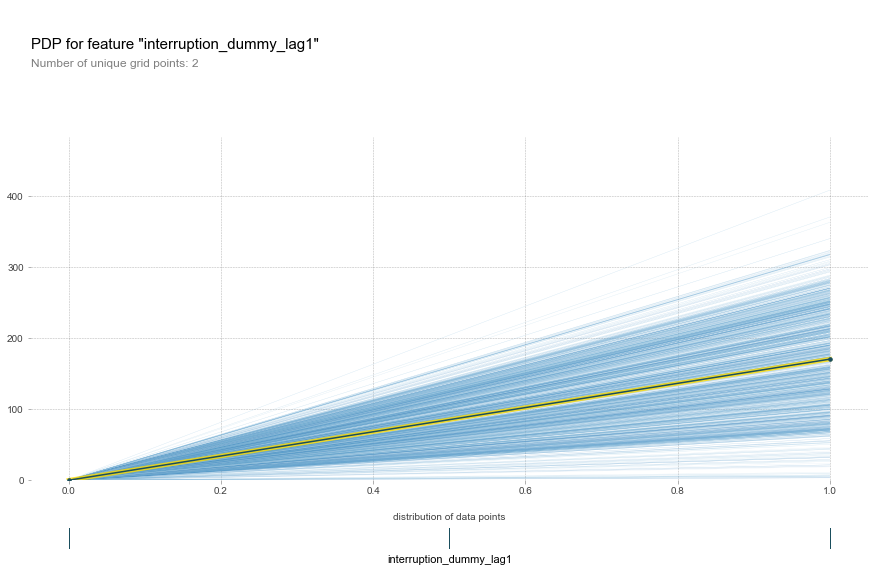

In [2929]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature=vi_dat["variable"][0],num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,vi_dat["variable"][0],plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

## Model: all GTD variables (split based on year)

In [2936]:
dat_model1 = pd.concat([terrordb_yr_90_gtd_lag0.filter(terrordb_yr_90_gtd_lag0.columns[:3]),
                       terrordb_yr_90_gtd_lag1.filter(terrordb_yr_90_gtd_lag1.columns[2:])], axis=1)

In [2937]:
dat_model1 = dat_model1[dat_model1["year"]>=1990]

In [2938]:
dat = dat_model1.drop(columns=["ctry_std","num_Q1_lag1","num_Q2_lag1","num_Q3_lag1","num_Q4_lag1"])

In [2943]:
len(dat>2000)/4

1573.25

In [2945]:
len(dat[dat["year"]>2011])

1519

In [2946]:
dat[dat["year"]>2011]

year  num_yr  num_yr_lag1  crit1_lag1  crit2_lag1  crit3_lag1  \
3171  2012  1469.0        421.0       419.0       420.0       383.0   
3255  2013  1443.0       1469.0      1464.0      1469.0      1048.0   
3350  2014  1824.0       1443.0      1442.0      1443.0      1157.0   
3450  2015  1928.0       1824.0      1819.0      1824.0      1607.0   
3549  2016  1617.0       1928.0      1923.0      1925.0      1731.0   
...    ...     ...          ...         ...         ...         ...   
3449  2014     1.0          3.0         2.0         3.0         3.0   
8470  2015     0.0          1.0         1.0         1.0         1.0   
8557  2016     0.0          0.0         0.0         0.0         0.0   
3759  2017     3.0          0.0         0.0         0.0         0.0   
3868  2018     2.0          3.0         3.0         3.0         3.0   

      multiple_lag1  success_lag1  suicide_lag1  individual_lag1  nperps_lag1  \
3171           25.0         397.0          80.0              0.0        176.0   
3255          123.0        1344.0         136.0              2.0        938.0   
3350          148.0        1333.0         130.0              0.0       2082.0   
3450          237.0        1665.0         187.0              0.0      14273.0   
3549          406.0        1627.0         151.0              0.0      18976.0   
...             ...           ...           ...              ...          ...   
3449            0.0           3.0           0.0              0.0          0.0   
8470            0.0           1.0           0.0              0.0          0.0   
8557            0.0           0.0           0.0              0.0          0.0   
3759            0.0           0.0           0.0              0.0          0.0   
3868            0.0           3.0           0.0              0.0          0.0   

      nperpcap_lag1  claimed_lag1  nkill_lag1  nkillter_lag1  nkillciv_lag1  \
3171           18.0          87.0      1525.0          260.0         1253.0   
3255          218.0         488.0      3521.0          981.0         2551.0   
3350           78.0         405.0      3709.0         1218.0         2409.0   
3450           95.0         596.0      5414.0         2479.0         2881.0   
3549           88.0         670.0      6216.0         3131.0         2955.0   
...             ...           ...         ...            ...            ...   
3449            0.0           0.0         1.0            0.0            1.0   
8470            0.0           0.0         0.0            0.0            0.0   
8557            0.0           0.0         0.0            0.0            0.0   
3759            0.0           0.0         0.0            0.0            0.0   
3868            0.0           0.0         0.0            0.0            0.0   

      nwound_lag1  nwoundte_lag1  nwoundciv_lag1  ishostkid_lag1  \
3171       1941.0            4.0          1937.0            44.0   
3255       4661.0          183.0          4375.0            59.0   
3350       4322.0          264.0          3885.0            90.0   
3450       5111.0          950.0          3928.0           139.0   
3549       6987.0         1682.0          4896.0           214.0   
...           ...            ...             ...             ...   
3449          1.0            0.0             1.0             0.0   
8470          0.0            0.0             0.0             0.0   
8557          0.0            0.0             0.0             0.0   
3759          0.0            0.0             0.0             0.0   
3868          1.0            0.0             1.0             1.0   

      nhostkid_lag1  ransom_lag1  ransompaid_lag1  INT_LOG_lag1  \
3171          334.0          1.0              1.0           3.0   
3255          278.0          2.0              2.0           3.0   
3350          311.0          0.0              0.0           2.0   
3450          753.0          2.0              2.0           5.0   
3549         1198.0          4.0              4.0           1.0   
...         

In [2947]:
# Split into training and test data
train_X = dat[dat["year"]<=2011].drop(columns=['num_yr',"year"])
train_y = dat[dat["year"]<=2011]['num_yr']
test_X = dat[dat["year"]>2011].drop(columns=['num_yr',"year"])
test_y = dat[dat["year"]>2011]['num_yr']

In [2948]:
## CROSS VALIDATION
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

In [2949]:
## INITIALIZE PIPELINE
## Pre-process the data
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [2950]:
## SELECT MODELS & TUNING PARAMETERS
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree
    {'model': [DT()],
     'model__max_depth':[2,3,4,5]},
    
    # Random forest
    {'model' : [RF()],
    'model__max_depth':[2,3,4,5],
    'model__n_estimators':[500,1000,1500,2000],
    'model__max_features':[5,8,10,13]}
    
]

In [2951]:
# Combine in a GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='r2',
                      n_jobs=-1)

In [2952]:
# Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model', None)],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'model': [GaussianNB(priors=None,
                                               var_smoothing=1e-09)]},
                         {'model': [KNeighborsClassifier(algorithm='aut...
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          n_est

Rationale behind r2 (vs MSE):

The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

Source: https://scikit-learn.org/dev/modules/model_evaluation.html#r2-score

MSE: Mean Squared Error loss function simple sum of the squared difference between actual and predicted value divided by a number of samples.

https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn

In [2953]:
# Extract best fit score
search.best_score_ 

0.8038940321997765

In [2954]:
# Extract parameters of best model
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=4, max_features=5, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 4,
 'model__max_features': 5,
 'model__n_estimators': 500}

In [2955]:
rf_mod = search.best_estimator_

In [2956]:
# Take in-sample performance
m.r2_score(train_y,rf_mod.predict(train_X))

0.8691118167059257

In [2957]:
m.mean_squared_error(train_y,rf_mod.predict(train_X))

542.8403889701741

In [2958]:
# Take out-of-sample performance
m.r2_score(test_y,rf_mod.predict(test_X))

0.6830599899345748

In [2959]:
m.mean_squared_error(test_y,rf_mod.predict(test_X))

21521.946894601155

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

## Variable Importance

In [2960]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance

In [2961]:
# Permute features to determine importance
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

In [2962]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

variable        vi       std       low  \
0                            crit1_lag1  0.027768  0.000858  0.026051   
1                            crit2_lag1  0.021304  0.000693  0.019917   
2                          success_lag1  0.019582  0.000702  0.018178   
3                            crit3_lag1  0.018228  0.000673  0.016881   
4                           num_yr_lag1  0.018207  0.000632  0.016943   
5                       Explosives_lag1  0.015665  0.000409  0.014848   
6                Bombing/Explosion_lag1  0.015516  0.000445  0.014626   
7                         nkillciv_lag1  0.010534  0.000469  0.009595   
8                    Armed Assault_lag1  0.009601  0.000317  0.008966   
9                        nwoundciv_lag1  0.008024  0.000367  0.007291   
10     Private Citizens & Property_lag1  0.008017  0.000292  0.007433   
11                        Firearms_lag1  0.007746  0.000421  0.006904   
12                      Government_lag1  0.007675  0.000279  0.007117   
13                          Police_lag1  0.007593  0.000254  0.007086   
14                          nwound_lag1  0.005969  0.000262  0.005446   
15                  Hostage Taking_lag1  0.005660  0.000198  0.005264   
16                           nkill_lag1  0.005412  0.000251  0.004911   
17                     Targ_Others_lag1  0.005364  0.000226  0.004912   
18  Religious Figures/Institutions_lag1  0.005255  0.000227  0.004801   
19                         suicide_lag1  0.003385  0.000255  0.002876   
20                   Assassination_lag1  0.003280  0.000243  0.002795   
21                        nperpcap_lag1  0.003170  0.000231  0.002709   
22                        nkillter_lag1  0.002959  0.000229  0.002501   
23                       ishostkid_lag1  0.002061  0.000093  0.001875   
24                        Military_lag1  0.002061  0.000097  0.001868   
25                        Business_lag1  0.001844  0.000424  0.000995   
26                        nhostkid_lag1  0.001747  0.000136  0.001476   
27                  Transportation_lag1  0.001632  0.000081  0.001470   
28                     Weap_Others_lag1  0.001256  0.000133  0.000990   
29                        multiple_lag1  0.001221  0.000050  0.001122   
30                       Utilities_lag1  0.001187  0.000030  0.001127   
31    Terrorists/Non-State Militia_lag1  0.000891  0.000078  0.000735   
32                         INT_LOG_lag1  0.000622  0.000050  0.000522   
33                       Hijacking_lag1  0.000619  0.000044  0.000530   
34                        nwoundte_lag1  0.000577  0.000038  0.000501   
35                          ransom_lag1  0.000380  0.000033  0.000314   
36  Facility/Infrastructure Attack_lag1  0.000339  0.000028  0.000283   
37                          nperps_lag1  0.000298  0.000089  0.000120   
38                      Incendiary_lag1  0.000254  0.000061  0.000132   
39                      ransompaid_lag1  0.000237  0.000049  0.000138   
40                         claimed_lag1  0.000172  0.000024  0.000124   
41                 Unarmed Assault_lag1  0.000094  0.000024  0.000046   
42                      individual_lag1  0.000000  0.000000  0.000000   

        high  
0   0.029485  
1   0.022691  
2   0.020986  
3   0.019575  
4   0.019471  
5   0.016483  
6   0.016405  
7   0.011472  
8   0.010235  
9   0.008758  
10  0.008602  
11  0.008587  
12  0.008233  
13  0.008101  
14  0.006492  
15  0.006055  
16  0.005913  
17  0.005817  
18  0.005709  
19  0.003894  
20  0.003766  
21  0.003632  
22  0.003417  
23  0.002247  
24  0.002254  
25  0.002693  
26  0.002019  
27  0.001794  
28  0.001522  
29  0.001321  
30  0.001247  
31  0.001047  
32  0.000721  
33  0.000707  
34  0.000653  
35  0.000445  
36  0.000396  
37  0.000476  
38  0.000375  
39  0.000335  
40  0.000221  
41  0.000143  
42  0.000000

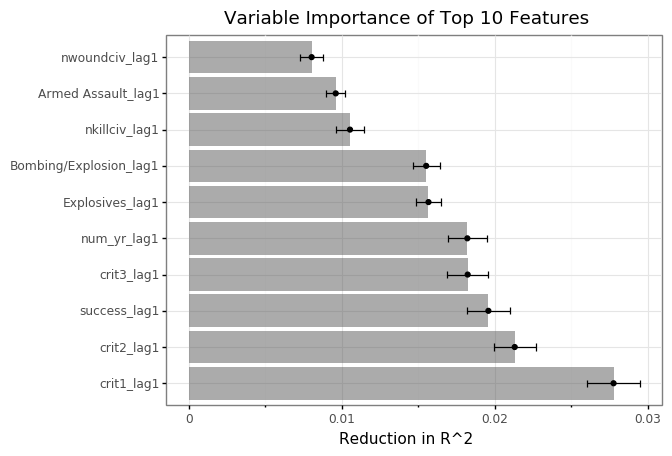

<ggplot: (-9223371875672390664)>

In [2963]:
# Visualize
(
    ggplot(vi_dat[:10],
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[:10].variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in R^2",x="",title="Variable Importance of Top 10 Features")
)

In [2964]:
vi_dat["variable"][:3]

0      crit1_lag1
1      crit2_lag1
2    success_lag1
Name: variable, dtype: object

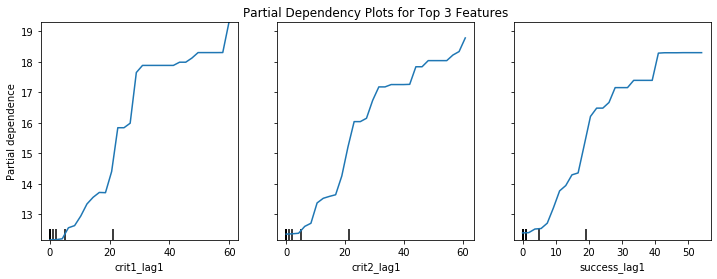

In [2965]:
# Target top 3 most important features
features = vi_dat["variable"][:3]

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Partial Dependency Plots for Top 3 Features")
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=3,
    n_jobs=-1, grid_resolution=30,ax=ax
)

### ICE Plot

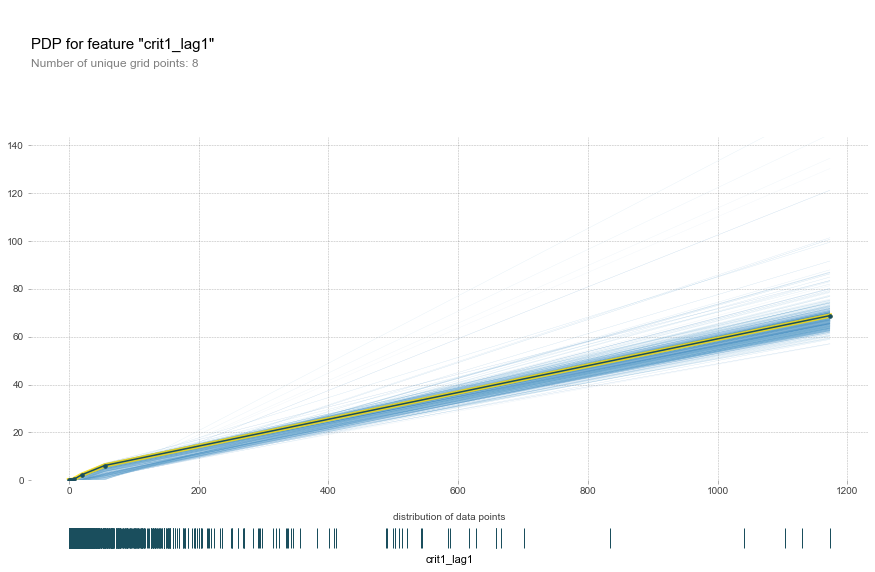

In [2966]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature=vi_dat["variable"][0],num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,vi_dat["variable"][0],plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

### Model: GTD with less variables

In [2973]:
dat_model2 = pd.concat([terrordb_yr_90_gtd_lag0.filter(terrordb_yr_90_gtd_lag0.columns[:3]),
                       terrordb_yr_90_gtd_lag1.filter(terrordb_yr_90_gtd_lag1.columns[2:])], axis=1)

In [2974]:
dat_model2 = dat_model2[dat_model2["year"]>=1990]

In [2975]:
events_total = pd.DataFrame(dat_model2.groupby(["ctry_std"]).sum()["num_yr"]).sort_values(by="num_yr",ascending=False)

In [2976]:
"No of countries with zero terrorism incidents from 1990-2018: " + str(len(events_total[events_total["num_yr"]==0]))

'No of countries with zero terrorism incidents from 1990-2018: 37'

In [2977]:
events_total

num_yr
ctry_std             
Iraq          26024.0
Pakistan      14642.0
Afghanistan   14486.0
India         11643.0
Philippines    6475.0
...               ...
Cabo Verde        0.0
Saint-Martin      0.0
Nauru             0.0
Bermuda           0.0
Kiribati          0.0

[217 rows x 1 columns]

In [2978]:
events_total[events_total["num_yr"]==0].index

Index(['Turks and Caicos Islands', 'Micronesia, Fed. Sts.', 'Tuvalu', 'Monaco',
       'Marshall Islands', 'Aruba', 'Mauritius', 'Mongolia',
       'United States Virgin Islands', 'Liechtenstein', 'Andorra',
       'American Samoa', 'Isle of Man', 'Tonga', 'British Virgin Islands',
       'Guam', 'Grenada', 'Samoa', 'San Marino', 'Sao Tome and Principe',
       'Puerto Rico', 'Seychelles', 'Faeroe Islands', 'Sint Maarten', 'Palau',
       'Curacao', 'Oman', 'Northern Mariana Islands', 'Gibraltar',
       'St. Vincent and the Grenadines', 'Cayman Islands', 'Greenland',
       'Cabo Verde', 'Saint-Martin', 'Nauru', 'Bermuda', 'Kiribati'],
      dtype='object', name='ctry_std')

In [2979]:
dat_model2["drop_ctry"] = 0
for i in events_total[events_total["num_yr"]==0].index:
    dat_model2["drop_ctry"] = dat_model2["drop_ctry"]+1*(dat_model2["ctry_std"]==i)

In [2980]:
dat_model2[dat_model2["drop_ctry"]==1]

year                      ctry_std  num_yr  num_yr_lag1  num_Q1_lag1  \
9953   1990                American Samoa     0.0          0.0          0.0   
9990   1991                American Samoa     0.0          0.0          0.0   
10023  1992                American Samoa     0.0          0.0          0.0   
10052  1993                American Samoa     0.0          0.0          0.0   
10081  1994                American Samoa     0.0          0.0          0.0   
...     ...                           ...     ...          ...          ...   
10550  2014  United States Virgin Islands     0.0          0.0          0.0   
10571  2015  United States Virgin Islands     0.0          0.0          0.0   
10592  2016  United States Virgin Islands     0.0          0.0          0.0   
10612  2017  United States Virgin Islands     0.0          0.0          0.0   
10658  2018  United States Virgin Islands     0.0          0.0          0.0   

       num_Q2_lag1  num_Q3_lag1  num_Q4_lag1  crit1_lag1  crit2_lag1  \
9953           0.0          0.0          0.0         0.0         0.0   
9990           0.0          0.0          0.0         0.0         0.0   
10023          0.0          0.0          0.0         0.0         0.0   
10052          0.0          0.0          0.0         0.0         0.0   
10081          0.0          0.0          0.0         0.0         0.0   
...            ...          ...          ...         ...         ...   
10550          0.0          0.0          0.0         0.0         0.0   
10571          0.0          0.0          0.0         0.0         0.0   
10592          0.0          0.0          0.0         0.0         0.0   
10612          0.0          0.0          0.0         0.0         0.0   
10658          0.0          0.0          0.0         0.0         0.0   

       crit3_lag1  multiple_lag1  success_lag1  suicide_lag1  individual_lag1  \
9953          0.0            0.0           0.0           0.0              0.0   
9990          0.0            0.0           0.0           0.0              0.0   
10023         0.0            0.0           0.0           0.0              0.0   
10052         0.0            0.0           0.0           0.0              0.0   
10081         0.0            0.0           0.0           0.0              0.0   
...           ...            ...           ...           ...              ...   
10550         0.0            0.0           0.0           0.0              0.0   
10571         0.0            0.0           0.0           0.0              0.0   
10592         0.0            0.0           0.0           0.0              0.0   
10612         0.0            0.0           0.0           0.0              0.0   
10658         0.0            0.0           0.0           0.0              0.0   

       nperps_lag1  nperpcap_lag1  claimed_lag1  nkill_lag1  nkillter_lag1  \
9953           0.0            0.0           0.0         0.0            0.0   
9990           0.0            0.0           0.0         0.0            0.0   
10023          0.0            0.0           0.0         0.0            0.0   
10052          0.0            0.0           0.0         0.0            0.0   
10081          0.0            0.0           0.0         0.0            0.0   
...            ...            ...           ...         ...            ...   
10550          0.0            0.0           0.0         0.0            0.0   
10571          0.0            0.0           0.0         0.0            0.0   
10592          0.0            0.0           0.0         0.0            0.0   
10612          0.0            0.0           0.0         0.0            0.0   
10658          0.0            0.0           0.0         0.0            0.0   

       nkillciv_lag1  nwound_lag1  nwoundte_lag1  nwoundciv_lag1  \
9953             0.0          0.0            0.0             0.0   
9990             0.0          0.0            0.0             0.0   
10023            0.0          0.0            0.0             0.0   
10052      

In [2981]:
# Retain only countries with terrorist incidents
dat_model2=dat_model2[dat_model2["drop_ctry"]==0]

In [2982]:
dat_model2

year     ctry_std  num_yr  num_yr_lag1  num_Q1_lag1  num_Q2_lag1  \
1174  1990  Afghanistan     2.0         10.0          2.0          2.0   
1254  1991  Afghanistan    30.0          2.0          1.0          0.0   
1371  1992  Afghanistan    36.0         30.0          2.0          4.0   
1511  1993  Afghanistan     3.0         36.0          7.0          7.0   
1578  1994  Afghanistan     9.0          3.0          1.0          1.0   
...    ...          ...     ...          ...          ...          ...   
3449  2014     Zimbabwe     1.0          3.0          2.0          0.0   
8470  2015     Zimbabwe     0.0          1.0          1.0          0.0   
8557  2016     Zimbabwe     0.0          0.0          0.0          0.0   
3759  2017     Zimbabwe     3.0          0.0          0.0          0.0   
3868  2018     Zimbabwe     2.0          3.0          0.0          0.0   

      num_Q3_lag1  num_Q4_lag1  crit1_lag1  crit2_lag1  crit3_lag1  \
1174          5.0          1.0        10.0        10.0        10.0   
1254          0.0          1.0         2.0         2.0         2.0   
1371         12.0         12.0        30.0        29.0        27.0   
1511          7.0         15.0        36.0        31.0        34.0   
1578          0.0          1.0         3.0         2.0         3.0   
...           ...          ...         ...         ...         ...   
3449          0.0          1.0         2.0         3.0         3.0   
8470          0.0          0.0         1.0         1.0         1.0   
8557          0.0          0.0         0.0         0.0         0.0   
3759          0.0          0.0         0.0         0.0         0.0   
3868          3.0          0.0         3.0         3.0         3.0   

      multiple_lag1  success_lag1  suicide_lag1  individual_lag1  nperps_lag1  \
1174            0.0           6.0           0.0              0.0          0.0   
1254            0.0           2.0           0.0              0.0          0.0   
1371            6.0          30.0           0.0              0.0          0.0   
1511            0.0          29.0           0.0              0.0         10.0   
1578            0.0           3.0           0.0              0.0          0.0   
...             ...           ...           ...              ...          ...   
3449            0.0           3.0           0.0              0.0          0.0   
8470            0.0           1.0           0.0              0.0          0.0   
8557            0.0           0.0           0.0              0.0          0.0   
3759            0.0           0.0           0.0              0.0          0.0   
3868            0.0           3.0           0.0              0.0          0.0   

      nperpcap_lag1  claimed_lag1  nkill_lag1  nkillter_lag1  nkillciv_lag1  \
1174            0.0           0.0        10.0            0.0            0.0   
1254            0.0           0.0        12.0            0.0            0.0   
1371            0.0           0.0        68.0            0.0            0.0   
1511            0.0           0.0        49.0            0.0            0.0   
1578            0.0           0.0         0.0            0.0            0.0   
...             ...           ...         ...            ...            ...   
3449            0.0           0.0         1.0            0.0            1.0   
8470            0.0           0.0         0.0            0.0            0.0   
8557            0.0           0.0         0.0            0.0            0.0   
3759            0.0           0.0         0.0            0.0            0.0   
3868            0.0           0.0         0.0            0.0            0.0   

      nwound_lag1  nwoundte_lag1  nwoundciv_lag1  ishostkid_lag1  \
1174         84.0            0.0             0.0             0.0   
1254        122.0            0.0             0.0             0.0   
1371        127.0            0.0             0.0             4.0   
1511        185.0            0.0             0.0             4.0   
1578          

In [2983]:
# Remove temporary columns
dat_model2=dat_model2.drop(['drop_ctry'],axis=1)

In [2984]:
# Important variables from previous model
list(vi_dat["variable"])[:20]

['crit1_lag1',
 'crit2_lag1',
 'success_lag1',
 'crit3_lag1',
 'num_yr_lag1',
 'Explosives_lag1',
 'Bombing/Explosion_lag1',
 'nkillciv_lag1',
 'Armed Assault_lag1',
 'nwoundciv_lag1',
 'Private Citizens & Property_lag1',
 'Firearms_lag1',
 'Government_lag1',
 'Police_lag1',
 'nwound_lag1',
 'Hostage Taking_lag1',
 'nkill_lag1',
 'Targ_Others_lag1',
 'Religious Figures/Institutions_lag1',
 'suicide_lag1']

In [2989]:
dat = dat_model2.filter(["num_yr","year",'crit1_lag1',
 'crit2_lag1',
 'success_lag1',
 'crit3_lag1',
 'num_yr_lag1',
 'Explosives_lag1',
 'Bombing/Explosion_lag1',
 'nkillciv_lag1',
 'Armed Assault_lag1',
 'nwoundciv_lag1',
 'Private Citizens & Property_lag1',
 'Firearms_lag1',
 'Government_lag1',
 'Police_lag1',
 'nwound_lag1',
 'Hostage Taking_lag1',
 'nkill_lag1',
 'Targ_Others_lag1',
 'Religious Figures/Institutions_lag1',
 'suicide_lag1'])

In [2994]:
len(dat)/4

1305.0

In [2999]:
len(dat[dat["year"]>=2012])

1260

In [3000]:
# Split into training and test data
train_X = dat[dat["year"]<=2012].drop(columns=['num_yr',"year"])
train_y = dat[dat["year"]<=2012]['num_yr']
test_X = dat[dat["year"]>2012].drop(columns=['num_yr',"year"])
test_y = dat[dat["year"]>2012]['num_yr']

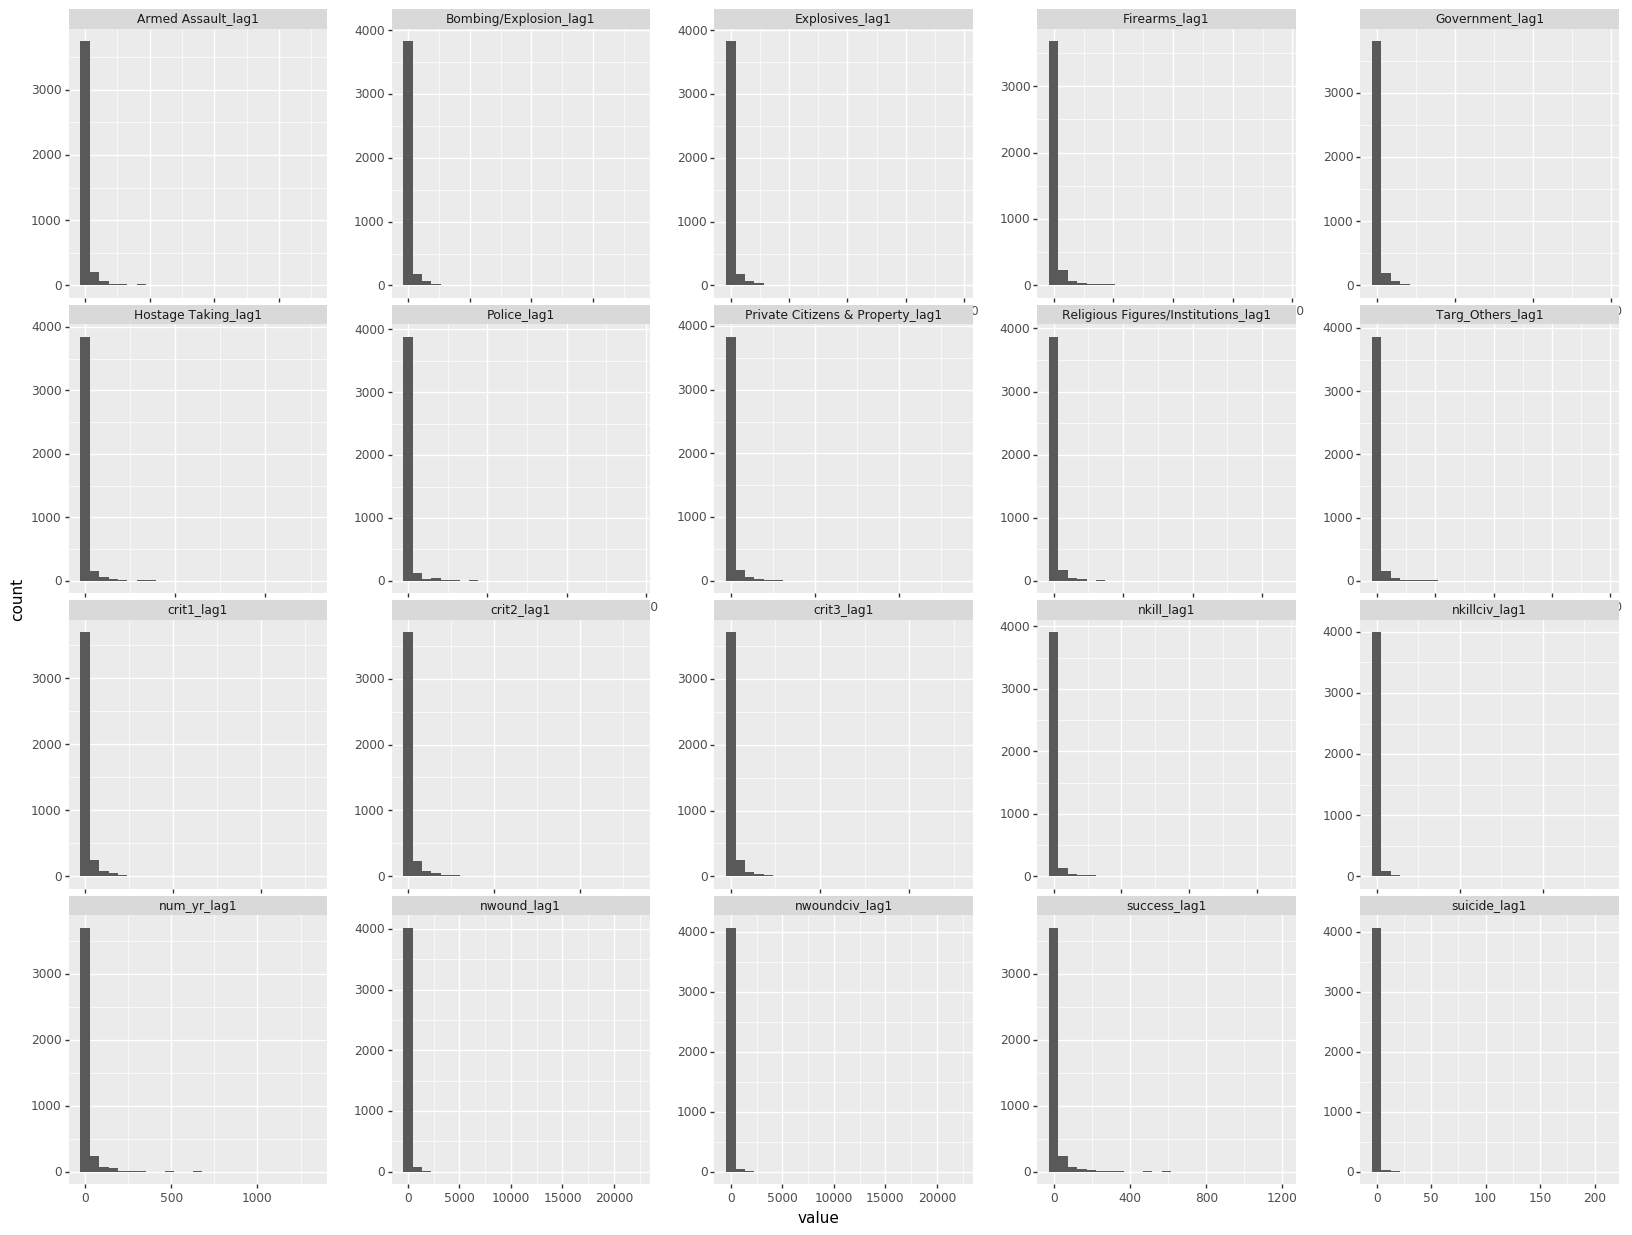

<ggplot: (-9223371876085058796)>

In [3001]:
# Plot the continuous variables 
d = train_X.select_dtypes(include=[np.int64,np.float64]).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(20,15),
          subplots_adjust={'wspace':0.25})
)

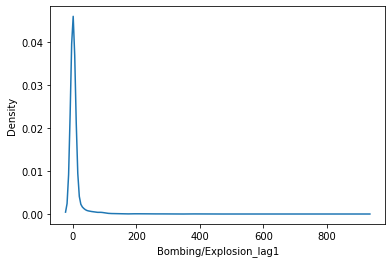

In [3002]:
sns.distplot(train_X["Bombing/Explosion_lag1"], hist=False, kde=True) 

In [3004]:
from scipy import stats 

fitted_data, fitted_lambda = stats.boxcox(train_X["Bombing/Explosion_lag1"]+1)

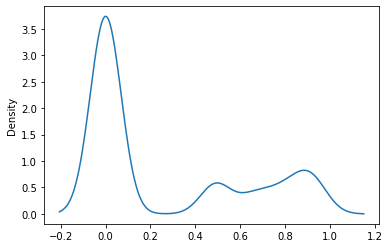

In [3005]:
#plot the distribution of the transformed data values
sns.distplot(fitted_data, hist=False, kde=True) 

In [3006]:
# Add 1 to prepare for box cox transformation
train_X = train_X+1

In [3007]:
fitted_data, fitted_lambda = stats.boxcox(train_X['success_lag1']+1)

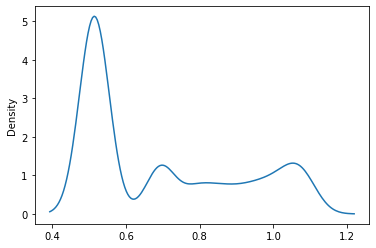

In [3008]:
#plot the distribution of the transformed data values
sns.distplot(fitted_data, hist=False, kde=True) 

In [3009]:
train_X.corr()

crit1_lag1  crit2_lag1  success_lag1  \
crit1_lag1                             1.000000    0.999701      0.998585   
crit2_lag1                             0.999701    1.000000      0.998669   
success_lag1                           0.998585    0.998669      1.000000   
crit3_lag1                             0.995599    0.995974      0.994606   
num_yr_lag1                            0.999730    0.999865      0.998747   
Explosives_lag1                        0.938901    0.937420      0.934122   
Bombing/Explosion_lag1                 0.941274    0.939725      0.937323   
nkillciv_lag1                          0.683765    0.682584      0.690855   
Armed Assault_lag1                     0.907558    0.908338      0.912859   
nwoundciv_lag1                         0.511622    0.511059      0.513299   
Private Citizens & Property_lag1       0.922723    0.925268      0.925085   
Firearms_lag1                          0.915678    0.916349      0.920655   
Government_lag1                        0.921144    0.919543      0.915858   
Police_lag1                            0.871628    0.872370      0.868773   
nwound_lag1                            0.574791    0.574035      0.577799   
Hostage Taking_lag1                    0.718812    0.717471      0.722273   
nkill_lag1                             0.770827    0.769773      0.781848   
Targ_Others_lag1                       0.801906    0.799794      0.807727   
Religious Figures/Institutions_lag1    0.719365    0.719254      0.723144   
suicide_lag1                           0.603038    0.601908      0.611629   

                                     crit3_lag1  num_yr_lag1  Explosives_lag1  \
crit1_lag1                             0.995599     0.999730         0.938901   
crit2_lag1                             0.995974     0.999865         0.937420   
success_lag1                           0.994606     0.998747         0.934122   
crit3_lag1                             1.000000     0.996076         0.940271   
num_yr_lag1                            0.996076     1.000000         0.935536   
Explosives_lag1                        0.940271     0.935536         1.000000   
Bombing/Explosion_lag1                 0.942310     0.937905         0.998939   
nkillciv_lag1                          0.694395     0.680006         0.742672   
Armed Assault_lag1                     0.896929     0.910195         0.756433   
nwoundciv_lag1                         0.521443     0.508671         0.584402   
Private Citizens & Property_lag1       0.938210     0.924652         0.903277   
Firearms_lag1                          0.898924     0.917868         0.757383   
Government_lag1                        0.925969     0.919196         0.888057   
Police_lag1                            0.869962     0.871253         0.810839   
nwound_lag1                            0.579745     0.572201         0.619845   
Hostage Taking_lag1                    0.727043     0.719196         0.600483   
nkill_lag1                             0.766552     0.768630         0.734726   
Targ_Others_lag1                       0.809612     0.803245         0.710372   
Religious Figures/Institutions_lag1    0.729526     0.717882         0.749653   
suicide_lag1                           0.607047     0.598758         0.675146   

                                     Bombing/Explosion_lag1  nkillciv_lag1  \
crit1_lag1                                         0.941274       0.683765   
crit2_lag1                                         0.939725       0.682584   
success_lag1                                       0.937323       0.690855   
crit3_lag1                                         0.942310       0.694395   
num_yr_lag1                                        0.937905       0.680006   
Explosives_lag1                                    0.998939       0.742672   
Bombing/Explosion_lag1                             1.000000       0.747380   
nkillciv_lag1                                      0.747380       1.000000   
Armed Assault_l

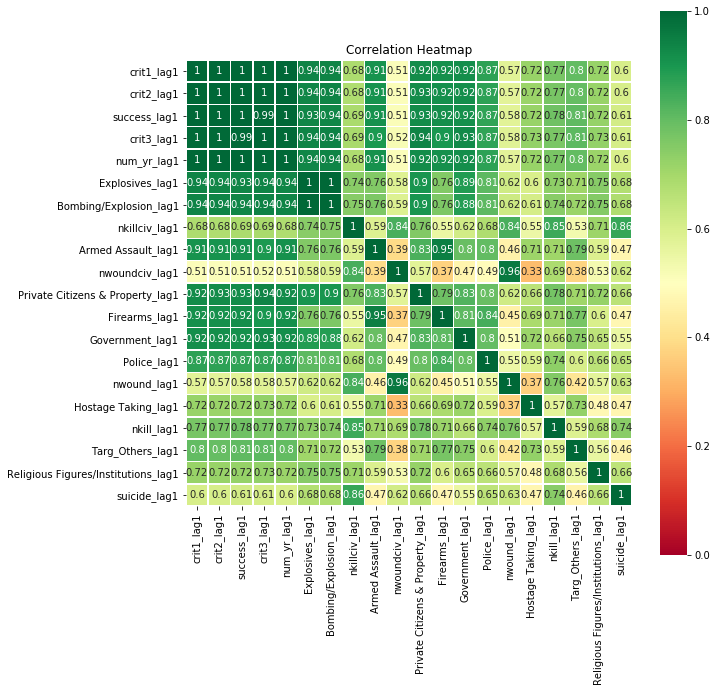

In [3010]:
# Plot heatmap
plt.figure(figsize = (10,10))
plt.title("Correlation Heatmap")
sns.heatmap(train_X.corr(),cmap="RdYlGn",vmin=0,vmax=1,linewidths=.5,annot=True,square=True)
plt.show()

Most are highly correlated (above 0.8, so let's add back all variables and choose less correlated ones for Model 2).

## Next trial:

In [3011]:
# Important variables from Model 1
list(vi_dat["variable"])

['crit1_lag1',
 'crit2_lag1',
 'success_lag1',
 'crit3_lag1',
 'num_yr_lag1',
 'Explosives_lag1',
 'Bombing/Explosion_lag1',
 'nkillciv_lag1',
 'Armed Assault_lag1',
 'nwoundciv_lag1',
 'Private Citizens & Property_lag1',
 'Firearms_lag1',
 'Government_lag1',
 'Police_lag1',
 'nwound_lag1',
 'Hostage Taking_lag1',
 'nkill_lag1',
 'Targ_Others_lag1',
 'Religious Figures/Institutions_lag1',
 'suicide_lag1',
 'Assassination_lag1',
 'nperpcap_lag1',
 'nkillter_lag1',
 'ishostkid_lag1',
 'Military_lag1',
 'Business_lag1',
 'nhostkid_lag1',
 'Transportation_lag1',
 'Weap_Others_lag1',
 'multiple_lag1',
 'Utilities_lag1',
 'Terrorists/Non-State Militia_lag1',
 'INT_LOG_lag1',
 'Hijacking_lag1',
 'nwoundte_lag1',
 'ransom_lag1',
 'Facility/Infrastructure Attack_lag1',
 'nperps_lag1',
 'Incendiary_lag1',
 'ransompaid_lag1',
 'claimed_lag1',
 'Unarmed Assault_lag1',
 'individual_lag1']

In [3012]:
dat = dat_model2.filter(["num_yr","year",'crit1_lag1',
 'crit2_lag1',
 'success_lag1',
 'crit3_lag1',
 'num_yr_lag1',
 'Explosives_lag1',
 'Bombing/Explosion_lag1',
 'nkillciv_lag1',
 'Armed Assault_lag1',
 'nwoundciv_lag1',
 'Private Citizens & Property_lag1',
 'Firearms_lag1',
 'Government_lag1',
 'Police_lag1',
 'nwound_lag1',
 'Hostage Taking_lag1',
 'nkill_lag1',
 'Targ_Others_lag1',
 'Religious Figures/Institutions_lag1',
 'suicide_lag1',
 'Assassination_lag1',
 'nperpcap_lag1',
 'nkillter_lag1',
 'ishostkid_lag1',
 'Military_lag1',
 'Business_lag1',
 'nhostkid_lag1',
 'Transportation_lag1',
 'Weap_Others_lag1',
 'multiple_lag1',
 'Utilities_lag1',
 'Terrorists/Non-State Militia_lag1',
 'INT_LOG_lag1',
 'Hijacking_lag1',
 'nwoundte_lag1',
 'ransom_lag1',
 'Facility/Infrastructure Attack_lag1',
 'nperps_lag1',
 'Incendiary_lag1',
 'ransompaid_lag1',
 'claimed_lag1',
 'Unarmed Assault_lag1',
 'individual_lag1'])

In [3015]:
len(dat)/4

1305.0

In [3013]:
len(dat[dat["year"]>=2012])

1260

In [3016]:
# Split into training and test data
train_X = dat[dat["year"]<=2012].drop(columns=['num_yr',"year"])
train_y = dat[dat["year"]<=2012]['num_yr']
test_X = dat[dat["year"]>2012].drop(columns=['num_yr',"year"])
test_y = dat[dat["year"]>2012]['num_yr']

In [3017]:
np.abs(train_X.corr())

crit1_lag1  crit2_lag1  success_lag1  \
crit1_lag1                             1.000000    0.999701      0.998585   
crit2_lag1                             0.999701    1.000000      0.998669   
success_lag1                           0.998585    0.998669      1.000000   
crit3_lag1                             0.995599    0.995974      0.994606   
num_yr_lag1                            0.999730    0.999865      0.998747   
Explosives_lag1                        0.938901    0.937420      0.934122   
Bombing/Explosion_lag1                 0.941274    0.939725      0.937323   
nkillciv_lag1                          0.683765    0.682584      0.690855   
Armed Assault_lag1                     0.907558    0.908338      0.912859   
nwoundciv_lag1                         0.511622    0.511059      0.513299   
Private Citizens & Property_lag1       0.922723    0.925268      0.925085   
Firearms_lag1                          0.915678    0.916349      0.920655   
Government_lag1                        0.921144    0.919543      0.915858   
Police_lag1                            0.871628    0.872370      0.868773   
nwound_lag1                            0.574791    0.574035      0.577799   
Hostage Taking_lag1                    0.718812    0.717471      0.722273   
nkill_lag1                             0.770827    0.769773      0.781848   
Targ_Others_lag1                       0.801906    0.799794      0.807727   
Religious Figures/Institutions_lag1    0.719365    0.719254      0.723144   
suicide_lag1                           0.603038    0.601908      0.611629   
Assassination_lag1                     0.745733    0.750875      0.746332   
nperpcap_lag1                          0.253404    0.253992      0.251332   
nkillter_lag1                          0.451766    0.450527      0.455747   
ishostkid_lag1                         0.722939    0.721634      0.726477   
Military_lag1                          0.645183    0.643005      0.645428   
Business_lag1                          0.840295    0.838867      0.831900   
nhostkid_lag1                          0.332613    0.332292      0.336208   
Transportation_lag1                    0.806304    0.807942      0.807913   
Weap_Others_lag1                       0.440157    0.443060      0.441794   
multiple_lag1                          0.756457    0.755574      0.753809   
Utilities_lag1                         0.473870    0.472971      0.480032   
Terrorists/Non-State Militia_lag1      0.685475    0.682767      0.675294   
INT_LOG_lag1                           0.194671    0.193982      0.182132   
Hijacking_lag1                         0.294655    0.294874      0.291548   
nwoundte_lag1                          0.248109    0.246292      0.248516   
ransom_lag1                            0.352232    0.353073      0.353790   
Facility/Infrastructure Attack_lag1    0.500496    0.497345      0.489607   
nperps_lag1                            0.041262    0.041013      0.041890   
Incendiary_lag1                        0.535654    0.538979      0.532499   
ransompaid_lag1                        0.352232    0.353073      0.353790   
claimed_lag1                           0.459129    0.455082      0.451730   
Unarmed Assault_lag1                   0.246830    0.256362      0.249671   
individual_lag1                        0.019446    0.019183      0.014587   

                                     crit3_lag1  num_yr_lag1  Explosives_lag1  \
crit1_lag1                             0.995599     0.999730         0.938901   
crit2_lag1                             0.995974     0.999865         0.937420   
success_lag1                           0.994606     0.998747         0.934122   
crit3_lag1                             1.000000     0.996076         0.940271   
num_yr_lag1                            0.996076     1.000000         0.935536   
Explosives_lag1                        0.940271     0.935536         1.000000   
Bombing/Explosion_lag1                 0.942310     0.937905         0.998939   


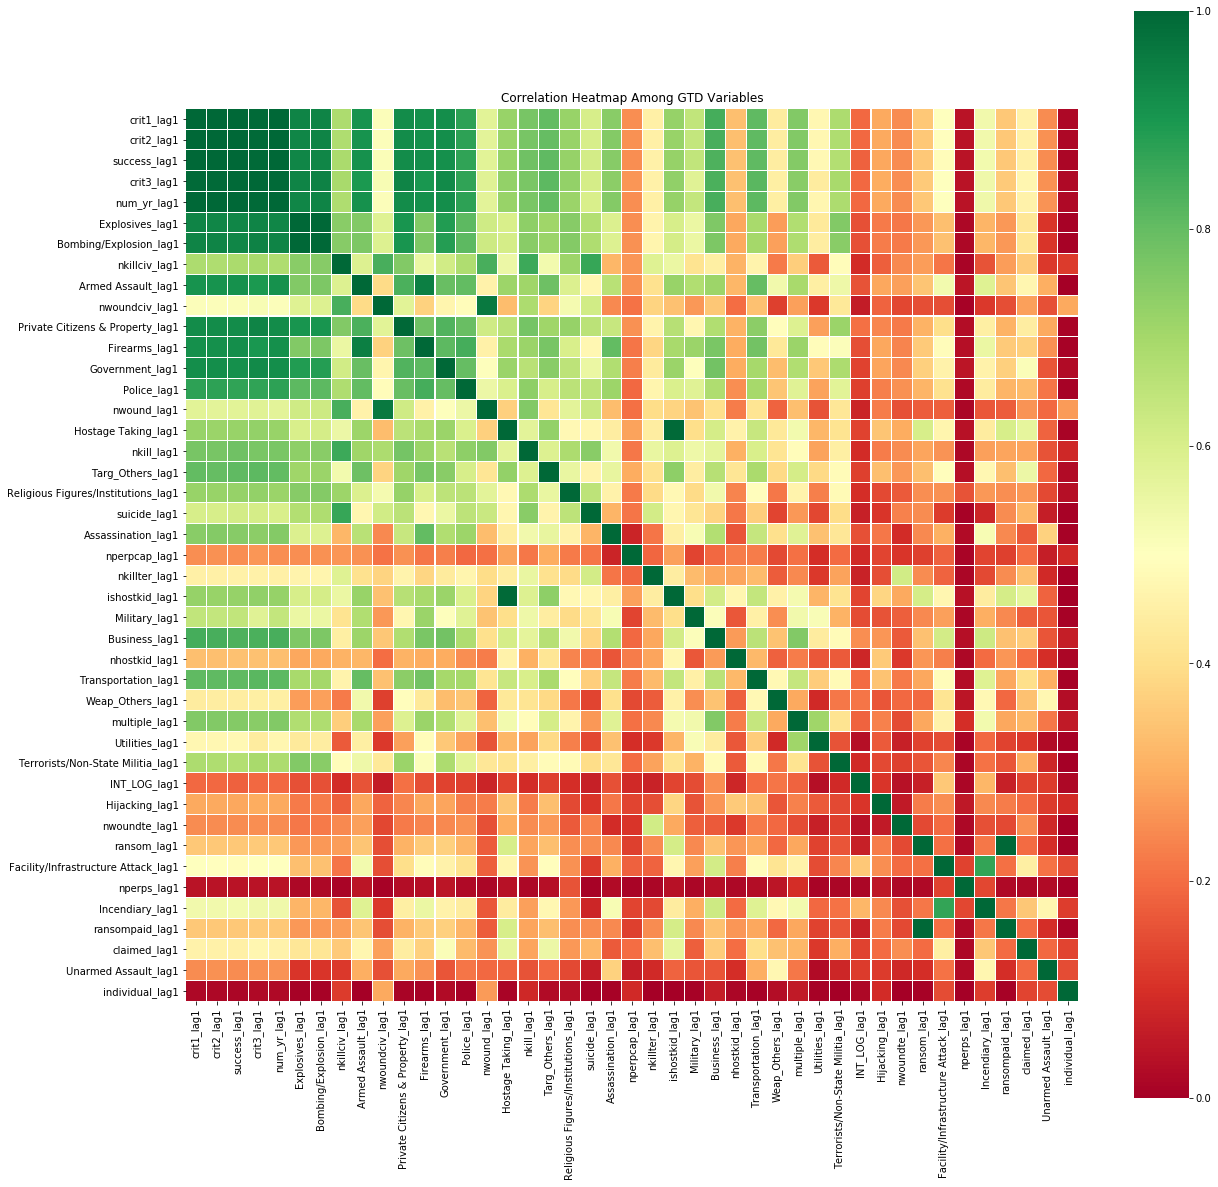

In [3019]:
# Plot heatmap
plt.figure(figsize = (20,20))
plt.title("Correlation Heatmap Among GTD Variables")
sns.heatmap(np.abs(train_X.corr()),cmap="RdYlGn",vmin=0,vmax=1,linewidths=.1,square=True)
plt.show()

Most of the highly important variables are highly correlated (above 0.8, so let's add back all variables and choose less correlated ones for Model 2).

In [3020]:
np.abs(train_X.corr()).reset_index()

index  crit1_lag1  crit2_lag1  success_lag1  \
0                            crit1_lag1    1.000000    0.999701      0.998585   
1                            crit2_lag1    0.999701    1.000000      0.998669   
2                          success_lag1    0.998585    0.998669      1.000000   
3                            crit3_lag1    0.995599    0.995974      0.994606   
4                           num_yr_lag1    0.999730    0.999865      0.998747   
5                       Explosives_lag1    0.938901    0.937420      0.934122   
6                Bombing/Explosion_lag1    0.941274    0.939725      0.937323   
7                         nkillciv_lag1    0.683765    0.682584      0.690855   
8                    Armed Assault_lag1    0.907558    0.908338      0.912859   
9                        nwoundciv_lag1    0.511622    0.511059      0.513299   
10     Private Citizens & Property_lag1    0.922723    0.925268      0.925085   
11                        Firearms_lag1    0.915678    0.916349      0.920655   
12                      Government_lag1    0.921144    0.919543      0.915858   
13                          Police_lag1    0.871628    0.872370      0.868773   
14                          nwound_lag1    0.574791    0.574035      0.577799   
15                  Hostage Taking_lag1    0.718812    0.717471      0.722273   
16                           nkill_lag1    0.770827    0.769773      0.781848   
17                     Targ_Others_lag1    0.801906    0.799794      0.807727   
18  Religious Figures/Institutions_lag1    0.719365    0.719254      0.723144   
19                         suicide_lag1    0.603038    0.601908      0.611629   
20                   Assassination_lag1    0.745733    0.750875      0.746332   
21                        nperpcap_lag1    0.253404    0.253992      0.251332   
22                        nkillter_lag1    0.451766    0.450527      0.455747   
23                       ishostkid_lag1    0.722939    0.721634      0.726477   
24                        Military_lag1    0.645183    0.643005      0.645428   
25                        Business_lag1    0.840295    0.838867      0.831900   
26                        nhostkid_lag1    0.332613    0.332292      0.336208   
27                  Transportation_lag1    0.806304    0.807942      0.807913   
28                     Weap_Others_lag1    0.440157    0.443060      0.441794   
29                        multiple_lag1    0.756457    0.755574      0.753809   
30                       Utilities_lag1    0.473870    0.472971      0.480032   
31    Terrorists/Non-State Militia_lag1    0.685475    0.682767      0.675294   
32                         INT_LOG_lag1    0.194671    0.193982      0.182132   
33                       Hijacking_lag1    0.294655    0.294874      0.291548   
34                        nwoundte_lag1    0.248109    0.246292      0.248516   
35                          ransom_lag1    0.352232    0.353073      0.353790   
36  Facility/Infrastructure Attack_lag1    0.500496    0.497345      0.489607   
37                          nperps_lag1    0.041262    0.041013      0.041890   
38                      Incendiary_lag1    0.535654    0.538979      0.532499   
39                      ransompaid_lag1    0.352232    0.353073      0.353790   
40                         claimed_lag1    0.459129    0.455082      0.451730   
41                 Unarmed Assault_lag1    0.246830    0.256362      0.249671   
42                      individual_lag1    0.019446    0.019183      0.014587   

    crit3_lag1  num_yr_lag1  Explosives_lag1  Bombing/Explosion_lag1  \
0     0.995599     0.999730         0.938901                0.941274   
1     0.995974     0.999865         0.937420                0.939725   
2     0.994606     0.998747         0.934122                0.937323   
3     1.000000     0.996076         0.940271                0.942310   
4     0.996076     1.000000         0.935536                0.937905   
5     0.940271     0.935536         1

We have 43 variables

In [3029]:
vars = list(pd.unique(np.abs(train_X.corr()).reset_index()["index"]))

In [3030]:
# Get variables with correlation of at least 0.8
corr = np.abs(train_X.corr()).reset_index().melt(id_vars="index")
corr2 = corr[(corr["value"]>=0.8) & (corr["value"]!=1)]

In [3031]:
for i in vars:
    for j in list(corr2[corr2["index"]==i]["variable"]):
        if j in vars:
            vars.remove(j)

In [3032]:
vars

['crit1_lag1',
 'nkillciv_lag1',
 'Hostage Taking_lag1',
 'Religious Figures/Institutions_lag1',
 'Assassination_lag1',
 'nperpcap_lag1',
 'nkillter_lag1',
 'Military_lag1',
 'nhostkid_lag1',
 'Weap_Others_lag1',
 'multiple_lag1',
 'Utilities_lag1',
 'Terrorists/Non-State Militia_lag1',
 'INT_LOG_lag1',
 'Hijacking_lag1',
 'nwoundte_lag1',
 'ransom_lag1',
 'Facility/Infrastructure Attack_lag1',
 'nperps_lag1',
 'ransompaid_lag1',
 'claimed_lag1',
 'Unarmed Assault_lag1',
 'individual_lag1']

In [3033]:
vars.append("num_yr")

In [3034]:
vars.append("year")

In [3036]:
dat = dat_model2.filter(vars)

In [3037]:
dat.min()

crit1_lag1                                0.0
nkillciv_lag1                             0.0
Hostage Taking_lag1                       0.0
Religious Figures/Institutions_lag1       0.0
Assassination_lag1                        0.0
nperpcap_lag1                             0.0
nkillter_lag1                             0.0
Military_lag1                             0.0
nhostkid_lag1                             0.0
Weap_Others_lag1                          0.0
multiple_lag1                             0.0
Utilities_lag1                            0.0
Terrorists/Non-State Militia_lag1         0.0
INT_LOG_lag1                              0.0
Hijacking_lag1                            0.0
nwoundte_lag1                             0.0
ransom_lag1                               0.0
Facility/Infrastructure Attack_lag1       0.0
nperps_lag1                               0.0
ransompaid_lag1                           0.0
claimed_lag1                              0.0
Unarmed Assault_lag1              

In [3041]:
temp = dat.copy()

In [3042]:
temp = temp + 1

for i in temp.columns[:-1]:
    fitted_data, fitted_lambda = stats.boxcox(temp[i])
    temp[i] = fitted_data

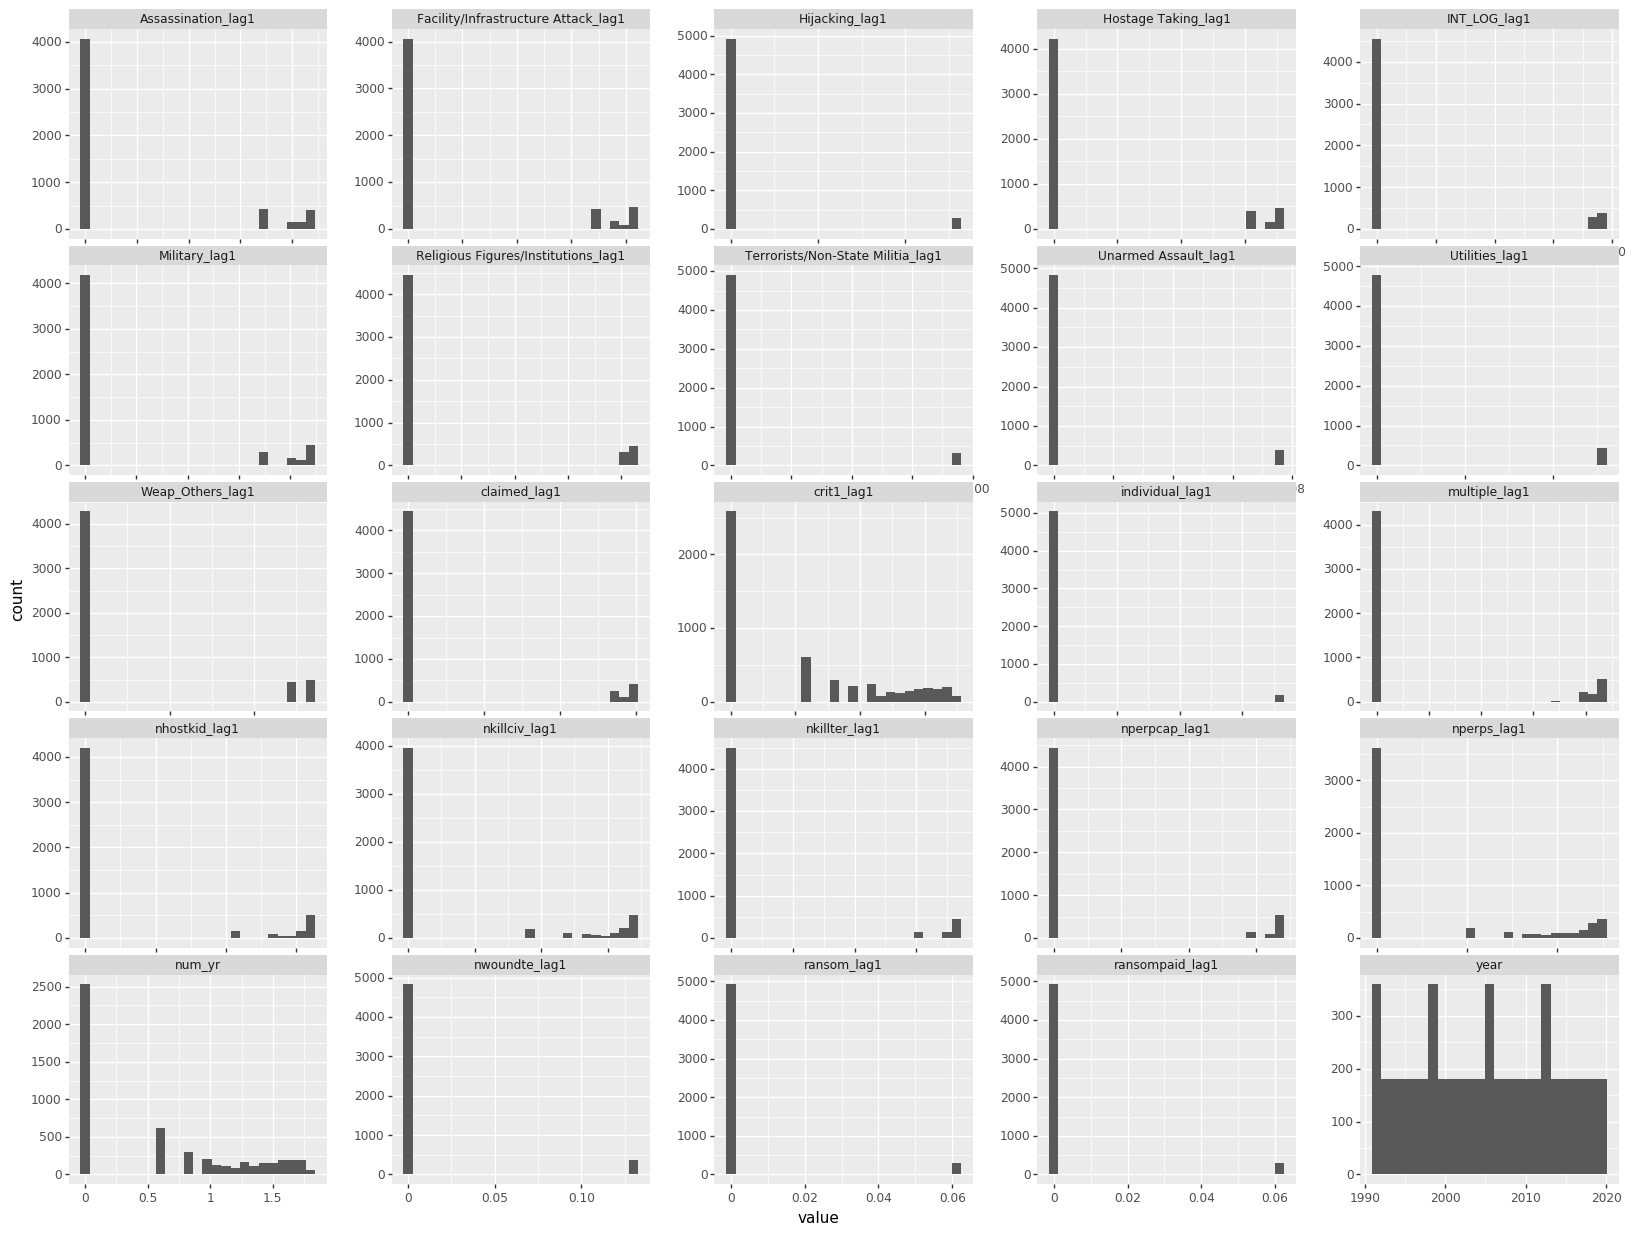

<ggplot: (-9223371876299898492)>

In [3043]:
# Plot the continuous variables 
d = temp.select_dtypes(include=[np.int64,np.float64]).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(20,15),
          subplots_adjust={'wspace':0.25})
)

In [3044]:
dat = temp.copy()

In [3045]:
len(dat)/4

1305.0

In [3047]:
len(dat[dat["year"]>=2013])

1260

In [3048]:
# Split into training and test data
train_X = dat[dat["year"]<2013].drop(columns=['num_yr',"year"])
train_y = dat[dat["year"]<2013]['num_yr']
test_X = dat[dat["year"]>=2013].drop(columns=['num_yr',"year"])
test_y = dat[dat["year"]>=2013]['num_yr']

In [3049]:
## CROSS VALIDATION
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

In [3050]:
## INITIALIZE PIPELINE
## Pre-process the data
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [3051]:
## SELECT MODELS & TUNING PARAMETERS
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree
    {'model': [DT()],
     'model__max_depth':[2,3,4,5]},
    
    # Random forest
    {'model' : [RF()],
    'model__max_depth':[2,3,4,5],
    'model__n_estimators':[500,1000,1500,2000],
    'model__max_features':[5,8,10,13]}
    
]

In [3052]:
# Combine in a GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='r2',
                      n_jobs=-1)

In [3053]:
# Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model', None)],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'model': [GaussianNB(priors=None,
                                               var_smoothing=1e-09)]},
                         {'model': [KNeighborsClassifier(algorithm='aut...
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          n_est

Rationale behind r2 (vs MSE):

The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

Source: https://scikit-learn.org/dev/modules/model_evaluation.html#r2-score

MSE: Mean Squared Error loss function simple sum of the squared difference between actual and predicted value divided by a number of samples.

https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn

In [3054]:
# Extract best fit score
search.best_score_ 

0.5680505397237188

In [3055]:
# Extract parameters of best model
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=5, max_features=13, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 5,
 'model__max_features': 13,
 'model__n_estimators': 1000}

In [3056]:
rf_mod = search.best_estimator_

In [3057]:
# Take in-sample performance
m.r2_score(train_y,rf_mod.predict(train_X))

0.5955704864203224

In [3058]:
m.mean_squared_error(train_y,rf_mod.predict(train_X))

0.15659311739023463

In [3059]:
# Take out-of-sample performance
m.r2_score(test_y,rf_mod.predict(test_X))

0.7237167261236247

In [3060]:
m.mean_squared_error(test_y,rf_mod.predict(test_X))

0.12936508506618802

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

## Variable Importance

In [3061]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance

In [3062]:
# Permute features to determine importance
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

In [3063]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

variable        vi       std       low  \
0                            crit1_lag1  0.621494  0.014898  0.591699   
1                           nperps_lag1  0.033508  0.002354  0.028801   
2                         nhostkid_lag1  0.014548  0.001601  0.011345   
3                         multiple_lag1  0.009143  0.001427  0.006289   
4                         nperpcap_lag1  0.007891  0.001366  0.005159   
5                         nkillciv_lag1  0.007508  0.000848  0.005812   
6                         Military_lag1  0.005591  0.000701  0.004189   
7                          claimed_lag1  0.005018  0.000708  0.003602   
8                    Assassination_lag1  0.003381  0.000297  0.002788   
9                   Hostage Taking_lag1  0.002523  0.000283  0.001957   
10  Facility/Infrastructure Attack_lag1  0.002351  0.000468  0.001415   
11                     Weap_Others_lag1  0.002040  0.000264  0.001512   
12                        nkillter_lag1  0.001784  0.000328  0.001128   
13  Religious Figures/Institutions_lag1  0.001295  0.000091  0.001114   
14                         INT_LOG_lag1  0.000752  0.000103  0.000547   
15                       Hijacking_lag1  0.000642  0.000305  0.000031   
16                 Unarmed Assault_lag1  0.000457  0.000076  0.000306   
17    Terrorists/Non-State Militia_lag1  0.000449  0.000183  0.000083   
18                       Utilities_lag1  0.000284  0.000077  0.000130   
19                      individual_lag1  0.000162  0.000032  0.000098   
20                        nwoundte_lag1  0.000134  0.000027  0.000080   
21                          ransom_lag1  0.000054  0.000011  0.000031   
22                      ransompaid_lag1  0.000052  0.000018  0.000016   

        high  
0   0.651289  
1   0.038215  
2   0.017751  
3   0.011997  
4   0.010622  
5   0.009203  
6   0.006993  
7   0.006434  
8   0.003974  
9   0.003088  
10  0.003288  
11  0.002567  
12  0.002441  
13  0.001477  
14  0.000957  
15  0.001252  
16  0.000608  
17  0.000816  
18  0.000438  
19  0.000225  
20  0.000188  
21  0.000076  
22  0.000088

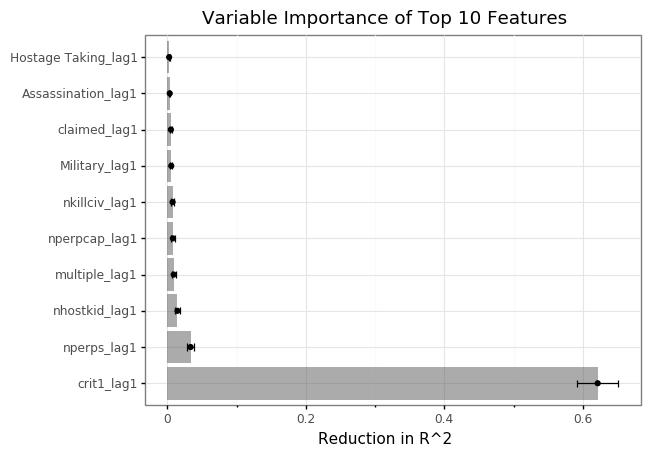

<ggplot: (-9223371876449681416)>

In [3064]:
# Visualize
(
    ggplot(vi_dat[:10],
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[:10].variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in R^2",x="",title="Variable Importance of Top 10 Features")
)

In making predictions, the model relies the most on the following variables: Bombing/Explosion, crit1, crit3, crit2, success, and num_yr.

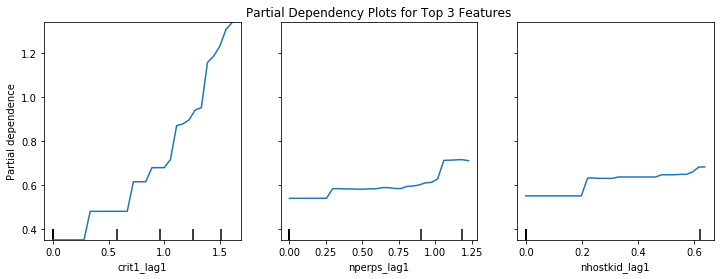

In [3065]:
# Target top 3 most important features
features = vi_dat["variable"][:3]

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Partial Dependency Plots for Top 3 Features")
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=3,
    n_jobs=-1, grid_resolution=30,ax=ax
)

### ICE Plot

In [3066]:
from pdpbox import pdp

In [3067]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="Bombing/Explosion_lag1",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'Bombing/Explosion_lag1',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

ValueError: feature does not exist: Bombing/Explosion_lag1

# Model 3: No Box Cox Transformation

In [ ]:
dat = dat_model2.filter(vars)

In [ ]:
# Plot the continuous variables 
d = dat.select_dtypes(include=[np.int64,np.float64]).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(20,15),
          subplots_adjust={'wspace':0.25})
)

In [ ]:
# Split into training and test data
train_X = dat[dat["year"]<2013].drop(columns=['num_yr',"year"])
train_y = dat[dat["year"]<2013]['num_yr']
test_X = dat[dat["year"]>=2013].drop(columns=['num_yr',"year"])
test_y = dat[dat["year"]>=2013]['num_yr']

In [ ]:
## CROSS VALIDATION
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

In [ ]:
## INITIALIZE PIPELINE
## Pre-process the data
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [ ]:
## SELECT MODELS & TUNING PARAMETERS
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree
    {'model': [DT()],
     'model__max_depth':[2,3,4,5]},
    
    # Random forest
    {'model' : [RF()],
    'model__max_depth':[2,3,4,5],
    'model__n_estimators':[500,1000,1500,2000],
    'model__max_features':[5,8,10,13]}
    
]

In [ ]:
# Combine in a GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='r2',
                      n_jobs=-1)

In [ ]:
# Fit the model to the training data
search.fit(train_X,train_y)

Rationale behind r2 (vs MSE):

The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

Source: https://scikit-learn.org/dev/modules/model_evaluation.html#r2-score

MSE: Mean Squared Error loss function simple sum of the squared difference between actual and predicted value divided by a number of samples.

https://coderzcolumn.com/tutorials/machine-learning/model-evaluation-scoring-metrics-scikit-learn-sklearn

In [ ]:
# Extract best fit score
search.best_score_ 

In [ ]:
# Extract parameters of best model
search.best_params_

In [ ]:
rf_mod = search.best_estimator_

In [ ]:
# Take in-sample performance
m.r2_score(train_y,rf_mod.predict(train_X))

In [ ]:
m.mean_squared_error(train_y,rf_mod.predict(train_X))

In [ ]:
# Take out-of-sample performance
m.r2_score(test_y,rf_mod.predict(test_X))

In [ ]:
m.mean_squared_error(test_y,rf_mod.predict(test_X))

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error

## Variable Importance

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance

In [ ]:
# Permute features to determine importance
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=30)

In [ ]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

In [ ]:
# Visualize
(
    ggplot(vi_dat[:10],
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[:10].variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in R^2",x="",title="Variable Importance of Top 10 Features")
)

In making predictions, the model relies the most on the following variables: Bombing/Explosion, crit1, crit3, crit2, success, and num_yr.

In [ ]:
# Target top 3 most important features
features = vi_dat["variable"][:3]

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Partial Dependency Plots for Top 3 Features")
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=3,
    n_jobs=-1, grid_resolution=30,ax=ax
)

### ICE Plot

In [ ]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature=vi_dat["variable"][0],num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,vi_dat["variable"][0],plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))